# Statistical Analysis <a id='stats'></a>

1. Age group differences <br>
    1. [Memory task performance](#memory-performance) <br>
    2. [Network measures](#network-measures) <br>
    3. [Rest-activity measures](#rest-activity-measures) <br>
2. [NBS analysis](#nbs-analysis) <br>
3. Regression analyses <br>
    1. [Rest-activity measures and memory performance](#rar-memory) <br>
    2. [Functional connectivity and memory performance](#fc-memory) <br>
    3. [Rest-activity measures and functional connectivity](#rar-fc) <br>

In [1]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib  # load the beta maps in python
from nilearn import plotting  # plot nifti images
from bct import nbs
from scipy.io import savemat
from mne.viz import plot_connectivity_circle

/usr/local/lib/python3.9/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
data_dir = '/Volumes/psybrain/ADM/derivatives'
results_dir = '/Volumes/schnyer/Megan/adm_mem-fc/analysis/stats/'
nibs_dir='/Volumes/psybrain/ADM/derivatives/nibs/nibetaseries'

tasks = ['MemMatch1', 'MemMatch2', 'MemMatch3']
trial_types = ['cue', 'match', 'mismatch']

atlas_file='/Volumes/psybrain/ADM/derivatives/nibs/power264-master/power264MNI.nii.gz'
atlas_lut='/Volumes/psybrain/ADM/derivatives/nibs/power264_labels.tsv'

In [3]:
import re
mod = pd.read_csv('/Volumes/psybrain/ADM/derivatives/nibs/results/modularity.csv')
mod['subject'] = mod['subject'].astype(str)

pc0 = pd.read_csv('/Volumes/psybrain/ADM/derivatives/nibs/results/participation_coefficient.csv')
pc0['subject'] = pc0['subject'].astype(str)

df = pd.read_csv('/Users/mcmahonmc/Box/CogNeuroLab/Aging Decision Making R01/data/dataset_2020-10-10.csv')
df['subject'] = df['record_id'].astype(str)
df.set_index('subject')

mem = pd.read_csv('/Users/mcmahonmc/Box/CogNeuroLab/Aging Decision Making R01/data/mri-behavioral/mem_results_06-2021.csv')
mem['subject'] = mem['record_id'].astype(str)
mem.set_index('subject')

edges_df = pd.read_csv('/Volumes/schnyer/Megan/adm_mem-fc/analysis/edges_df.csv')
edges_df.columns = edges_df.columns.str.replace('Unnamed: 0', 'subject')
edges_df['subject'] = edges_df['subject'].astype(str)
edges_df = edges_df.set_index('subject')

# edges['subject'] = edges.index.astype(str)
# edges.reset_index().set_index('subject')
df = pd.merge(df, mem, how='outer').set_index('subject')
mod['mod_mean'] = mod.mean(axis=1)
df = pd.merge(df, mod[['subject', 'mod_mean']].set_index('subject'), left_index=True, right_index=True, how='outer')
df = pd.merge(df, pc0.set_index('subject'), left_index=True, right_index=True, how = 'outer')
df = pd.merge(df, edges_df, left_index=True, right_index=True, how = 'outer').drop(['Unnamed: 0', 'record_id', 'files'], axis=1)
# df = pd.merge(df, pd.DataFrame({'subject': subjects, 'dmn_fpn_fc': x['cue'][dmn][:,fpn].mean(axis=1).mean(axis=0)}).set_index('subject'), left_index=True, right_index=True, how = 'outer')
df = df.reset_index().dropna(how='all')


df['Group'] = np.where(df['subject'].astype(int) > 40000, "Older Adults", "Young Adults")
df = df.set_index('subject')
df.columns = [re.sub("[ ,-]", "_", re.sub("[\.,`,\$]", "_", str(c))) for c in df.columns]
df = df.drop('40930')
df['acc_mean_test_log'] = np.log(df['acc_mean_test'])
df = df.loc[:, ~df.columns.str.endswith('_fa')]
df = df.drop(['cc_vol'], axis=1)

df.to_csv('/Volumes/schnyer/Megan/adm_mem-fc/data/dataset_2021-11-10.csv')
df

/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_62451/2438831985.py:24: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mod['mod_mean'] = mod.mean(axis=1)


,IS,IV,RA,L5,L5_starttime,M10,M10_starttime,duration_mean_active,duration_mean_daily,duration_mean_rest,...,pc_dmn_fpn_18,pc_dmn_fpn_20,pc_dmn_fpn_mean,pc_dmn_mean,pc_fpn_mean,edge_0,edge_1,edge_2,edge_3,acc_mean_test_log
subject,,,,,,,,,,,,,,,,,,,,,
30004,0.43,0.57,0.85,12.61,19:54:30,156.15,5:17:30,937.071429,1263.428571,436.428571,...,0.205587,0.218853,0.178769,0.585333,0.755358,0.451471,0.509899,0.257227,0.688757,-0.028171
30008,0.48,0.68,0.90,7.56,20:26:30,147.40,2:00:30,872.928571,1251.214286,501.857143,...,0.206955,0.218107,0.194311,0.586016,0.720762,0.425655,0.824386,1.032888,0.311497,-0.057158
30009,0.42,1.31,0.92,11.58,19:34:30,286.35,6:21:30,981.214286,1317.000000,455.142857,...,0.211377,0.222053,0.192073,0.482981,0.814453,0.508419,0.634550,0.578941,0.278736,-0.028171
30012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,914.857143,1288.571429,465.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.216223
30015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,899.857143,1438.714286,452.000000,...,0.261610,0.277564,0.237269,0.651844,0.738657,0.264530,0.418911,0.402329,0.096133,-0.117783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40861,0.33,1.33,0.59,26.04,15:42:30,102.37,0:49:30,809.000000,1439.928571,569.428571,...,0.290175,0.298779,0.274548,0.724093,0.804171,0.351552,0.386455,0.557694,0.199891,NaN
40876,0.49,0.93,0.83,14.47,21:08:30,152.05,7:38:30,829.214286,1268.500000,536.125000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.149532
40878,0.64,0.56,0.88,11.87,18:31:30,179.77,5:42:30,877.000000,1440.000000,472.642857,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.251314


In [4]:
df.groupby(['Group', 'sex'])['age'].describe()

count       mean       std   min    25%   50%    75%  \
Group        sex                                                            
Older Adults Female   45.0  67.844444  5.563499  60.0  64.00  67.0  71.00   
             Male     12.0  69.083333  6.082140  60.0  65.50  69.5  71.25   
Young Adults Female   28.0  21.535714  3.815001  18.0  18.75  20.0  23.25   
             Male     18.0  21.166667  3.823303  18.0  19.00  19.5  22.50   

                      max  
Group        sex           
Older Adults Female  81.0  
             Male    81.0  
Young Adults Female  30.0  
             Male    30.0

In [5]:
df.dropna(subset=['mod_mean', 'actamp']).groupby('Group')['age'].describe()

,count,mean,std,min,25%,50%,75%,max
Group,,,,,,,,
Older Adults,33.0,66.575758,4.847875,60.0,63.0,66.0,70.0,79.0
Young Adults,43.0,21.139535,3.582905,18.0,18.5,20.0,22.5,30.0


## Memory Performance <a id='memory-performance'></a>

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


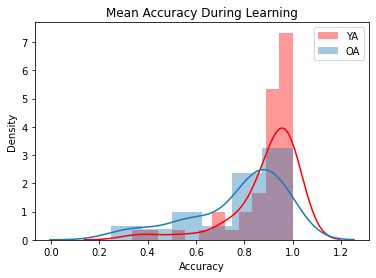

In [6]:
sns.distplot(df[df['Group'] == 'Young Adults']['acc_mean_learning'].dropna(), label = 'YA', color = 'red')
sns.distplot(df[df['Group'] == 'Older Adults']['acc_mean_learning'].dropna(), label = 'OA')
plt.legend()
plt.title('Mean Accuracy During Learning')
plt.xlabel('Accuracy')
plt.savefig(results_dir + 'hist_accuracy-learning.png', dpi=300)

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


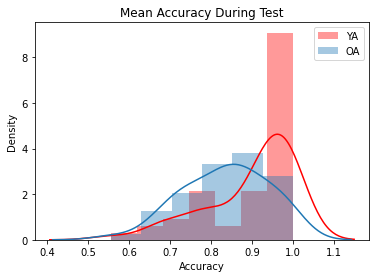

In [7]:
sns.distplot(df[df['Group'] == 'Young Adults']['acc_mean_test'].dropna(), label = 'YA', color = 'red')
sns.distplot(df[df['Group'] == 'Older Adults']['acc_mean_test'].dropna(), label = 'OA')
plt.legend()
plt.title('Mean Accuracy During Test')
plt.xlabel('Accuracy')
plt.savefig(results_dir + 'hist_accuracy-test.png', dpi=300)

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

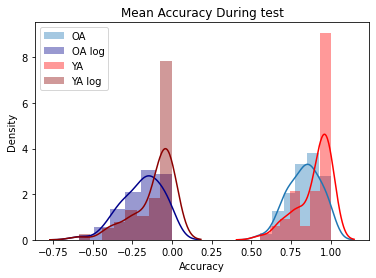

In [8]:
sns.distplot(df[df['Group'] == 'Older Adults']['acc_mean_test'].dropna(), label = 'OA')
sns.distplot(df[df['Group'] == 'Older Adults']['acc_mean_test_log'].dropna(), label = 'OA log', color = 'darkblue')
sns.distplot(df[df['Group'] == 'Young Adults']['acc_mean_test'].dropna(), label = 'YA', color = 'red')
sns.distplot(df[df['Group'] == 'Young Adults']['acc_mean_test_log'].dropna(), label = 'YA log', color = 'darkred')

plt.legend()
plt.title('Mean Accuracy During test')
plt.xlabel('Accuracy')
plt.savefig(results_dir + 'hist_accuracy-test-log.png', dpi=300)

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


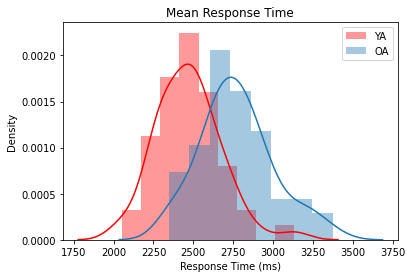

In [9]:
sns.distplot(df[df['Group'] == 'Young Adults']['rt_c_mean_test'].dropna(), label = 'YA', color = 'red')
sns.distplot(df[df['Group'] == 'Older Adults']['rt_c_mean_test'].dropna(), label = 'OA')
plt.legend()
plt.title('Mean Response Time')
plt.xlabel('Response Time (ms)')
plt.savefig(results_dir + 'hist_rtc-test.png', dpi=300)

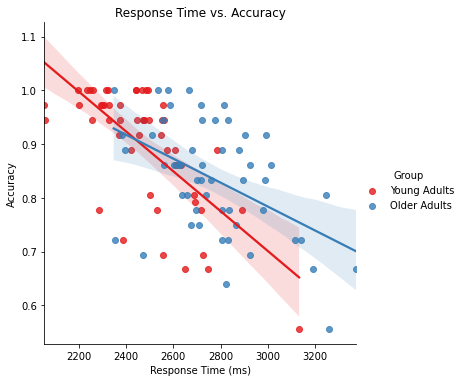

In [10]:
sns.lmplot(data=df, x="rt_c_mean_test", y="acc_mean_test", hue="Group", palette = 'Set1')
plt.title('Response Time vs. Accuracy')
plt.xlabel('Response Time (ms)'); plt.ylabel('Accuracy')
plt.savefig(results_dir + 'scatter_rtc-accuracy.png', dpi=300)

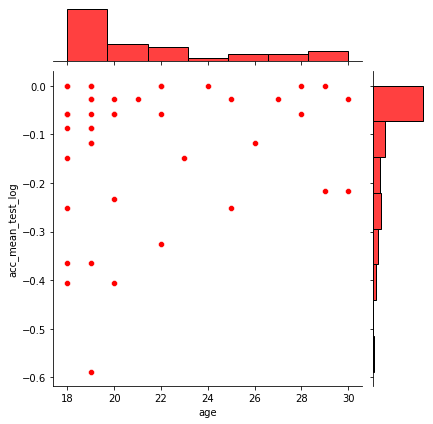

In [11]:
sns.jointplot(data=df[df['Group'] == "Young Adults"], x="age", y="acc_mean_test_log", color='red')
# plt.title('Age vs. Accuracy')
plt.xlabel('Age'); plt.ylabel('Accuracy')
plt.savefig(results_dir + 'scatter_ya-age-accuracy.png', dpi=300)

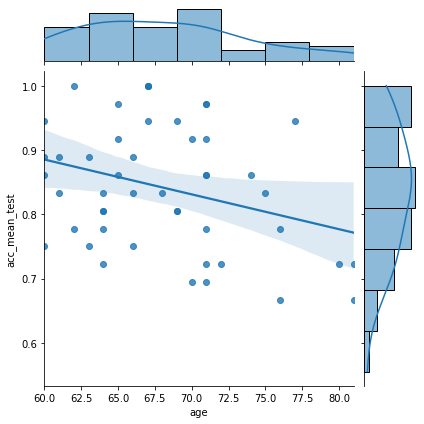

In [12]:
sns.jointplot(data=df[df['Group'] == "Older Adults"], x="age", y="acc_mean_test", kind='reg')
# plt.title('Age vs. Accuracy')
plt.xlabel('Age'); plt.ylabel('Accuracy')
plt.savefig(results_dir + 'scatter_oa-age-accuracy.png', dpi=300)

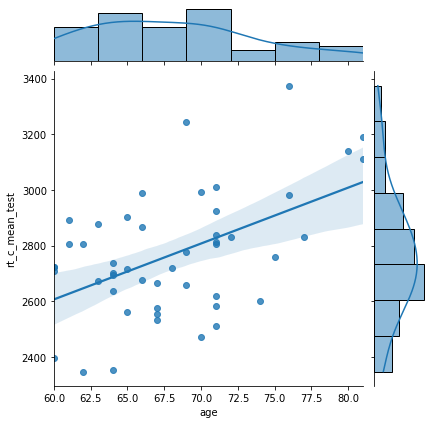

In [13]:
sns.jointplot(data=df[df['Group'] == "Older Adults"], x="age", y="rt_c_mean_test", kind='reg')
# plt.title('Age vs. Accuracy')
plt.xlabel('Age'); plt.ylabel('Response Time (ms)')
plt.savefig(results_dir + 'scatter_oa-age-rt.png', dpi=300)

[RT Transformations resource](https://lindeloev.github.io/shiny-rt/)

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


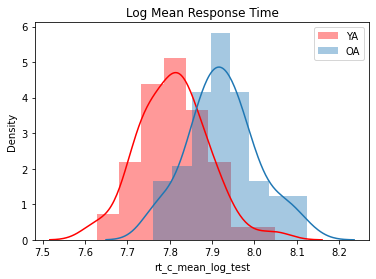

In [14]:
df['rt_c_mean_log_test'] = np.log(df['rt_c_mean_test'])
sns.distplot(df[df['Group'] == 'Young Adults']['rt_c_mean_log_test'].dropna(), label = 'YA', color = 'red')
sns.distplot(df[df['Group'] == 'Older Adults']['rt_c_mean_log_test'].dropna(), label = 'OA')
plt.legend()
plt.title('Log Mean Response Time')
plt.savefig(results_dir + 'hist_rtc-log.png', dpi=300)

In [15]:
zscore = lambda x: (x - x.mean()) / x.std()

df['rt_c_mean_test_z'] = df.groupby(['Group']).rt_c_mean_test.transform(zscore)

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


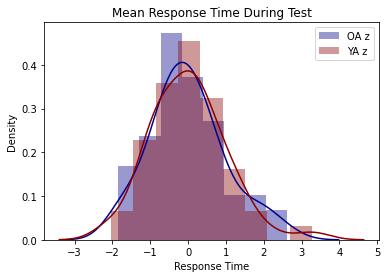

In [16]:
sns.distplot(df[df['Group'] == 'Older Adults']['rt_c_mean_test_z'].dropna(), label = 'OA z', color = 'darkblue')
sns.distplot(df[df['Group'] == 'Young Adults']['rt_c_mean_test_z'].dropna(), label = 'YA z', color = 'darkred')

plt.legend()
plt.title('Mean Response Time During Test')
plt.xlabel('Response Time')
plt.savefig(results_dir + 'hist_rtc-test-z.png', dpi=300)

In [17]:
df0 = df.copy()
df = df[(df['acc_mean_test'] > 0.56)  & df['acc_mean_learning'] > 0.33]
print('dropped %.f subjects' % (len(df0) - len(df)))

dropped 19 subjects


In [18]:
len(df)

103

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


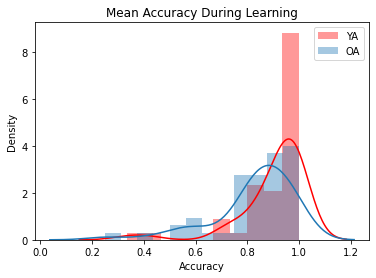

In [19]:
sns.distplot(df[df['Group'] == 'Young Adults']['acc_mean_learning'].dropna(), label = 'YA', color = 'red')
sns.distplot(df[df['Group'] == 'Older Adults']['acc_mean_learning'].dropna(), label = 'OA')
plt.legend()
plt.title('Mean Accuracy During Learning')
plt.xlabel('Accuracy')
plt.savefig(results_dir + 'hist_accuracy-learning.png', dpi=300)

/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `hi

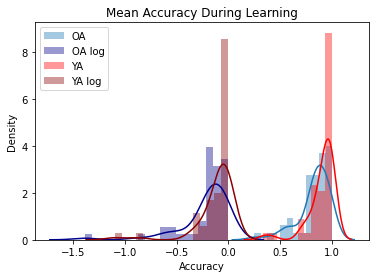

In [20]:
df['acc_mean_learning_log'] = np.log(df['acc_mean_learning'])
sns.distplot(df[df['Group'] == 'Older Adults']['acc_mean_learning'].dropna(), label = 'OA')
sns.distplot(df[df['Group'] == 'Older Adults']['acc_mean_learning_log'].dropna(), label = 'OA log', color = 'darkblue')
sns.distplot(df[df['Group'] == 'Young Adults']['acc_mean_learning'].dropna(), label = 'YA', color = 'red')
sns.distplot(df[df['Group'] == 'Young Adults']['acc_mean_learning_log'].dropna(), label = 'YA log', color = 'darkred')

plt.legend()
plt.title('Mean Accuracy During Learning')
plt.xlabel('Accuracy')
plt.savefig(results_dir + 'hist_accuracy-learning-log.png', dpi=300)


## Network measures <a id='network-measures'></a>

NameError: name 'x' is not defined

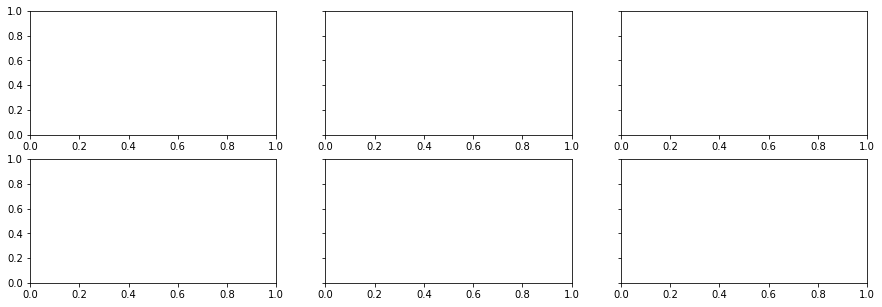

In [21]:
fig, axes = plt.subplots(2, 3, figsize=(15, 5), sharey=True)

sns.distplot(ax = axes[0,0], a = np.triu(x['cue_ya'][dmn][:,dmn]).mean(axis=0).mean(axis=0), label = 'cue', hist=False)
sns.distplot(ax = axes[0,0], a = np.triu(x['match_ya'][dmn][:,dmn]).mean(axis=0).mean(axis=0), label = 'match', hist=False)
sns.distplot(ax = axes[0,0], a = np.triu(x['mismatch_ya'][dmn][:,dmn]).mean(axis=0).mean(axis=0), label = 'mismatch', hist=False)

sns.distplot(ax = axes[0,1], a = np.triu(x['cue_ya'][fpn][:,fpn]).mean(axis=0).mean(axis=0), label = 'cue', hist=False)
sns.distplot(ax = axes[0,1], a = np.triu(x['match_ya'][fpn][:,fpn]).mean(axis=0).mean(axis=0), label = 'match', hist=False)
sns.distplot(ax = axes[0,1], a = np.triu(x['mismatch_ya'][fpn][:,fpn]).mean(axis=0).mean(axis=0), label = 'mismatch', hist=False)

sns.distplot(ax = axes[0,2], a = np.triu(x['cue_ya'][dmn][:,fpn]).mean(axis=1).mean(axis=0), label = 'cue', hist=False)
sns.distplot(ax = axes[0,2], a = np.triu(x['match_ya'][dmn][:,fpn]).mean(axis=1).mean(axis=0), label = 'match', hist=False)
sns.distplot(ax = axes[0,2], a = np.triu(x['mismatch_ya'][dmn][:,fpn]).mean(axis=1).mean(axis=0), label = 'mismatch', hist=False)

sns.distplot(ax = axes[1,0], a = np.triu(x['cue_oa'][dmn][:,dmn]).mean(axis=0).mean(axis=0), label = 'cue', hist=False)
sns.distplot(ax = axes[1,0], a = np.triu(x['match_oa'][dmn][:,dmn]).mean(axis=0).mean(axis=0), label = 'match', hist=False)
sns.distplot(ax = axes[1,0], a = np.triu(x['mismatch_oa'][dmn][:,dmn]).mean(axis=0).mean(axis=0), label = 'mismatch', hist=False)

sns.distplot(ax = axes[1,1], a = np.triu(x['cue_oa'][fpn][:,fpn]).mean(axis=0).mean(axis=0), label = 'cue', hist=False)
sns.distplot(ax = axes[1,1], a = np.triu(x['match_oa'][fpn][:,fpn]).mean(axis=0).mean(axis=0), label = 'match', hist=False)
sns.distplot(ax = axes[1,1], a = np.triu(x['mismatch_oa'][fpn][:,fpn]).mean(axis=0).mean(axis=0), label = 'mismatch', hist=False)

sns.distplot(ax = axes[1,2], a = np.triu(x['cue_oa'][dmn][:,fpn]).mean(axis=1).mean(axis=0), label = 'cue', hist=False)
sns.distplot(ax = axes[1,2], a = np.triu(x['match_oa'][dmn][:,fpn]).mean(axis=1).mean(axis=0), label = 'match', hist=False)
sns.distplot(ax = axes[1,2], a = np.triu(x['mismatch_oa'][dmn][:,fpn]).mean(axis=1).mean(axis=0), label = 'mismatch', hist=False)

axes[0,0].set_ylabel('Young Adults')
axes[1,0].set_ylabel('Older Adults')

axes[0,0].set_title('Within DMN FC')
axes[0,1].set_title('Within FPN FC')
axes[0,2].set_title('DMN-FPN FC')

plt.legend()
plt.savefig(results_dir + 'hist_fc-by-condition-group.png', dpi=300)

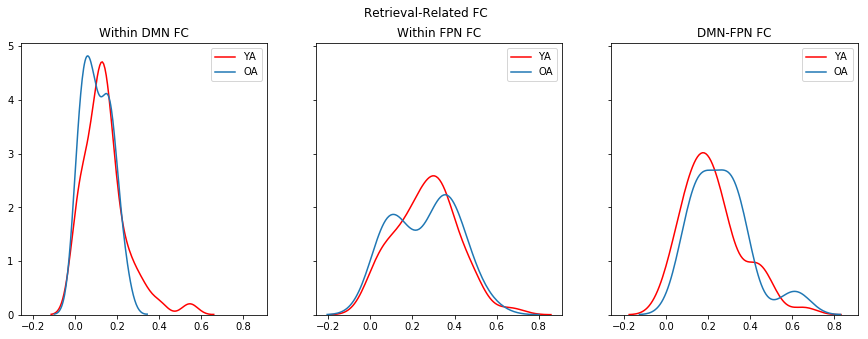

In [562]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True, sharex=True)
plt.suptitle('Retrieval-Related FC') #just looking at cue condition

sns.distplot(ax = axes[0], a = np.triu(x['cue_ya'][dmn][:,dmn]).mean(axis=0).mean(axis=0), label = 'YA', color = 'red', hist=False)
sns.distplot(ax = axes[0], a = np.triu(x['cue_oa'][dmn][:,dmn]).mean(axis=0).mean(axis=0), label = 'OA', hist=False)

sns.distplot(ax = axes[1], a = np.triu(x['cue_ya'][fpn][:,fpn]).mean(axis=0).mean(axis=0), label = 'YA', color = 'red', hist=False)
sns.distplot(ax = axes[1], a = np.triu(x['cue_oa'][fpn][:,fpn]).mean(axis=0).mean(axis=0), label = 'OA', hist=False)

sns.distplot(ax = axes[2], a = x['cue_ya'][dmn][:,fpn].mean(axis=1).mean(axis=0), label = 'YA', color = 'red', hist=False)
sns.distplot(ax = axes[2], a = x['cue_oa'][dmn][:,fpn].mean(axis=1).mean(axis=0), label = 'OA', hist=False)

axes[0].set_title('Within DMN FC')
axes[1].set_title('Within FPN FC')
axes[2].set_title('DMN-FPN FC')

axes[0].legend()
axes[1].legend()
axes[2].legend()

plt.savefig(results_dir + 'hist_fc-cue-by-group.png', dpi=300)

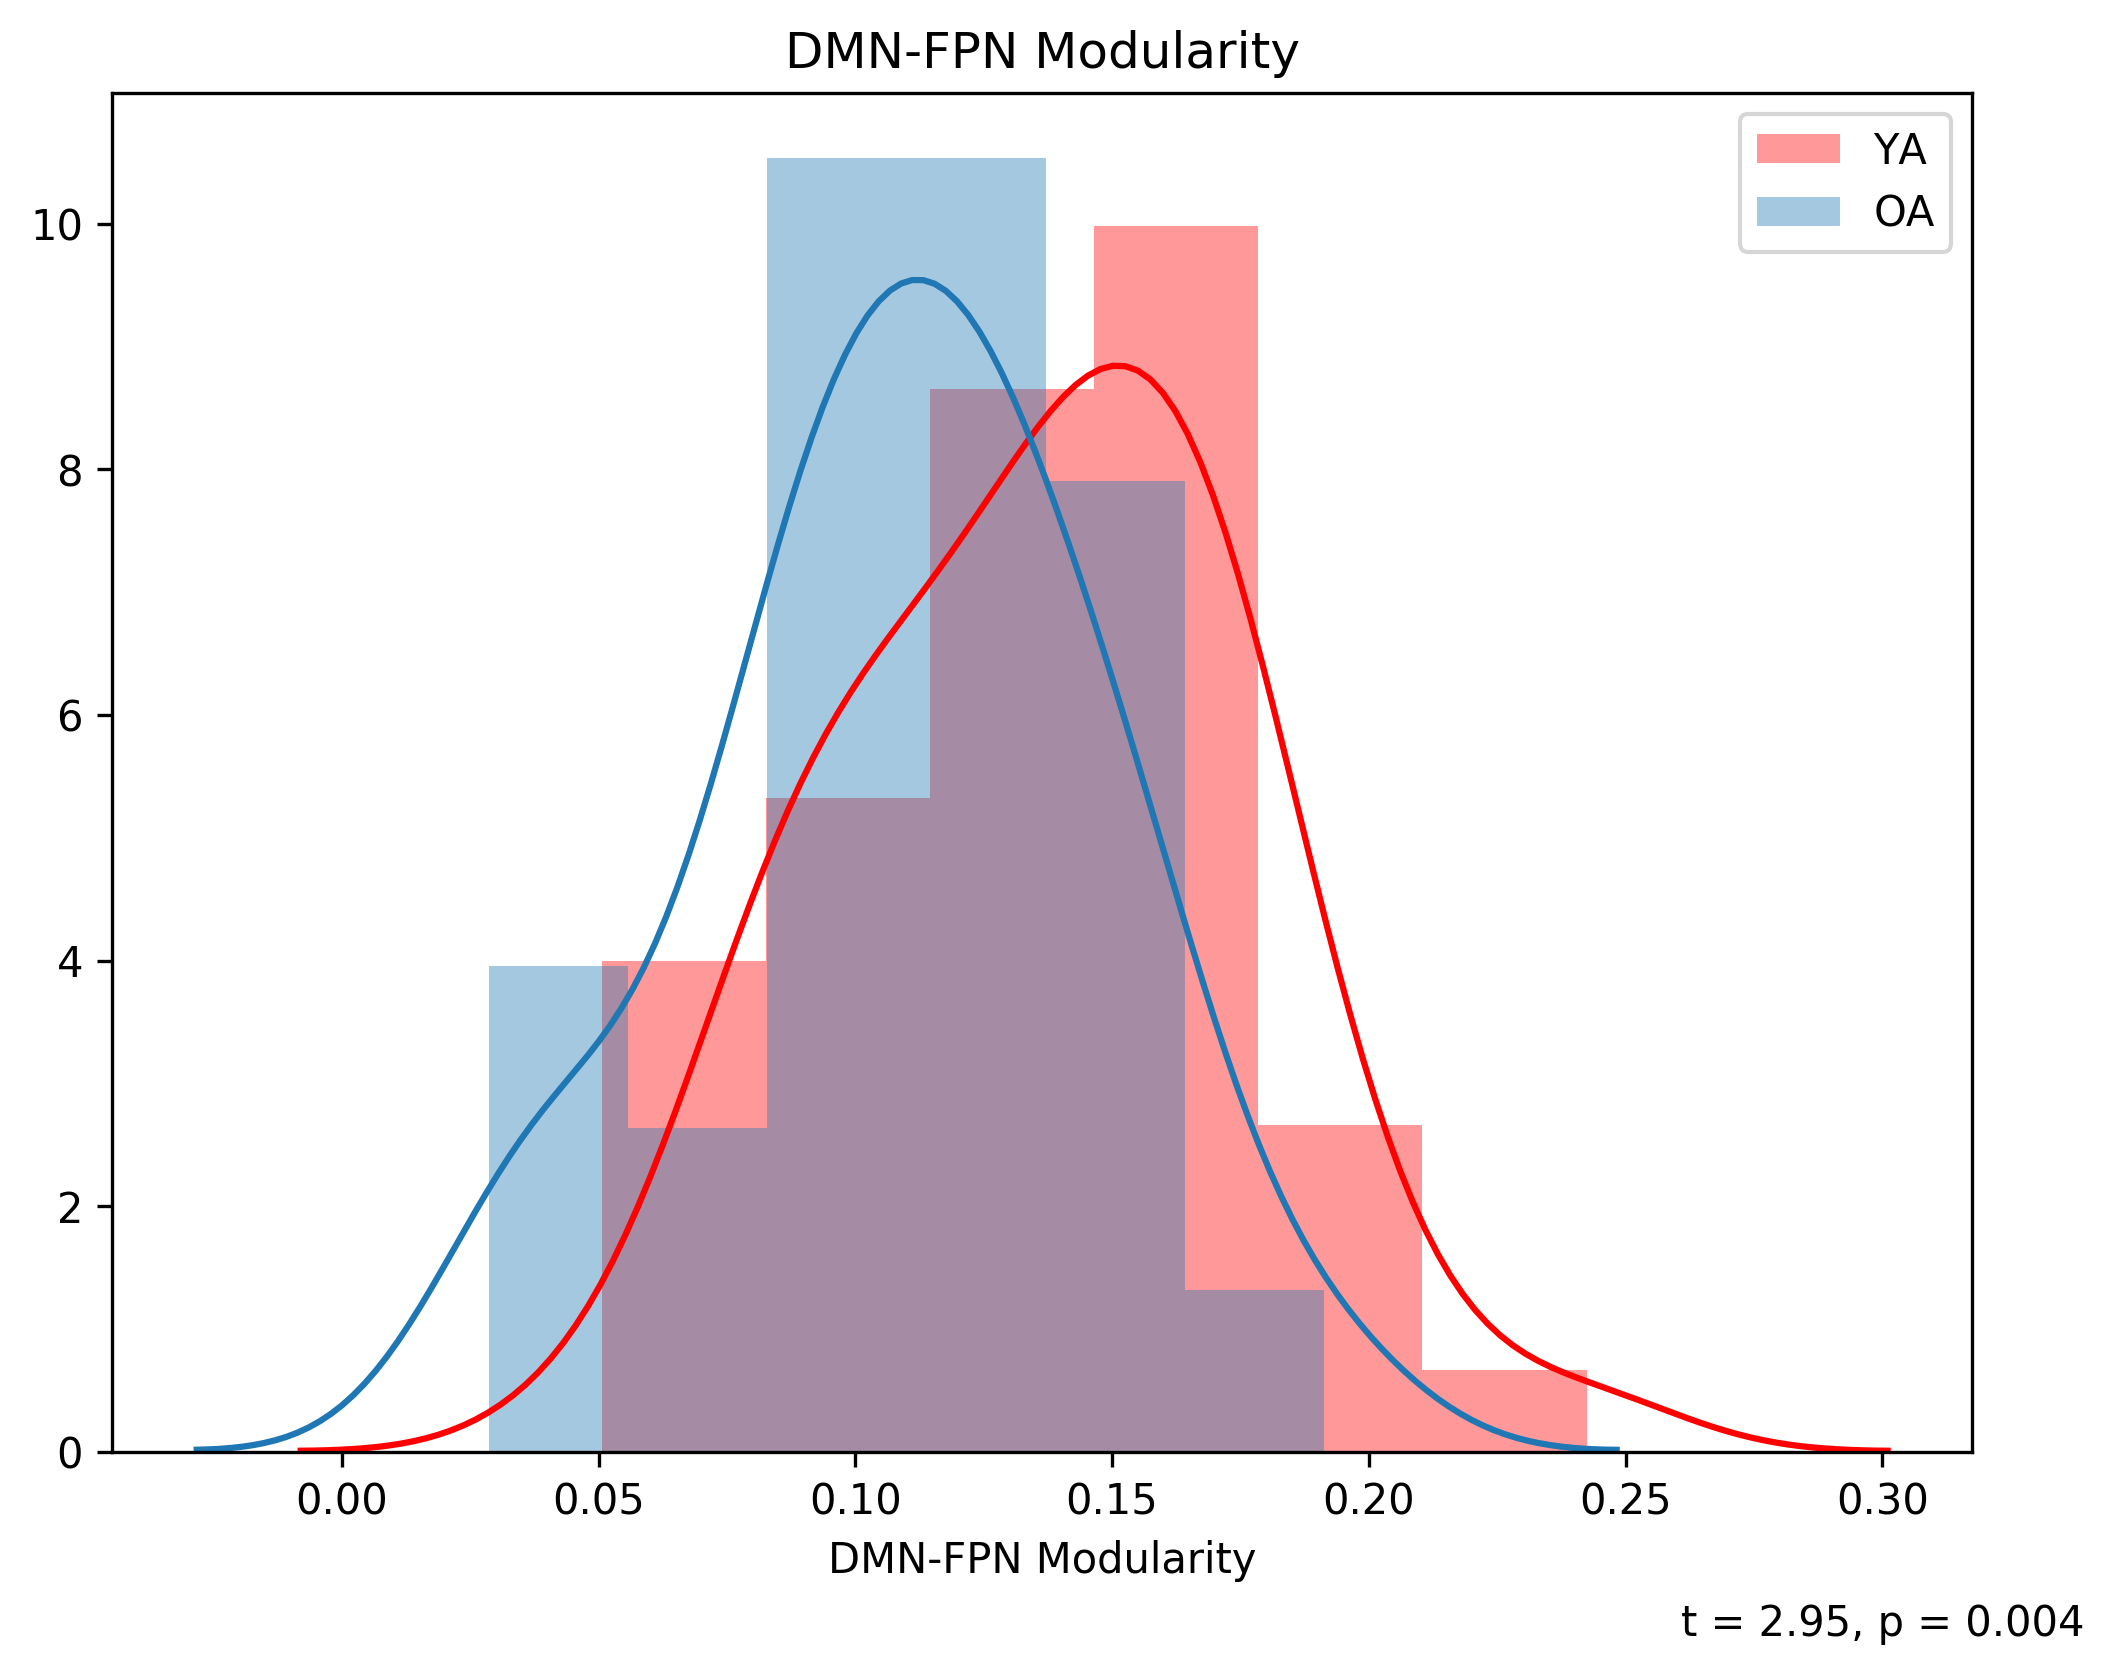

In [519]:
plt.figure(figsize=(8, 6), dpi=300)

sns.distplot(df[df['Group'] == 'Young Adults']['mod_mean'].dropna(), label = 'YA', color = 'red')
sns.distplot(df[df['Group'] == 'Older Adults']['mod_mean'].dropna(), label = 'OA')
plt.xlabel('DMN-FPN Modularity')
plt.legend()
plt.title('DMN-FPN Modularity')

from scipy import stats

ttest = stats.ttest_ind(df[df['Group'] == 'Young Adults']['mod_mean'].dropna(), df[df['Group'] == 'Older Adults']['mod_mean'].dropna(), axis=0, equal_var=True)

if ttest[1] < 0.001:
    plt.text(.3, -1.5, 't = %.2f, p < 0.001' % ttest[0], ha='center')
else:
    plt.text(.3, -1.5, 't = %.2f, p = %.3f' % (ttest[0], ttest[1]), ha='center')

plt.savefig(results_dir + 'hist_dmn-fpn-modularity.png', dpi=300)

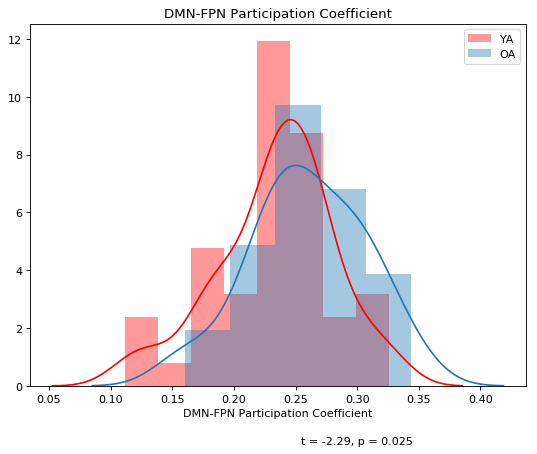

In [520]:
plt.figure(figsize=(8, 6), dpi=80)

sns.distplot(df[df['Group'] == 'Young Adults']['pc_dmn_fpn_mean'].dropna(), label = 'YA', color = 'red')
sns.distplot(df[df['Group'] == 'Older Adults']['pc_dmn_fpn_mean'].dropna(), label = 'OA')
plt.xlabel('DMN-FPN Participation Coefficient')
plt.legend()
plt.title('DMN-FPN Participation Coefficient')

from scipy import stats

ttest = stats.ttest_ind(df[df['Group'] == 'Young Adults']['pc_dmn_fpn_mean'].dropna(), df[df['Group'] == 'Older Adults']['pc_dmn_fpn_mean'].dropna(), axis=0, equal_var=True)

if ttest[1] < 0.001:
    plt.text(.3, -2, 't = %.2f, p < 0.001' % ttest[0], ha='center')
else:
    plt.text(.3, -2, 't = %.2f, p = %.3f' % (ttest[0], ttest[1]), ha='center')

plt.savefig(results_dir + 'hist_dmn-fpn-pc.png', dpi=300)

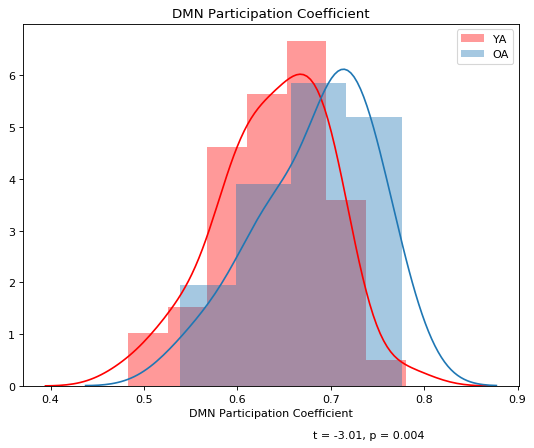

In [521]:
plt.figure(figsize=(8, 6), dpi=80)
sns.distplot(df[df['Group'] == 'Young Adults']['pc_dmn_mean'].dropna(), label = 'YA', color = 'red')
sns.distplot(df[df['Group'] == 'Older Adults']['pc_dmn_mean'].dropna(), label = 'OA')
plt.xlabel('DMN Participation Coefficient')
plt.legend()
plt.title('DMN Participation Coefficient')

from scipy import stats

ttest = stats.ttest_ind(df[df['Group'] == 'Young Adults']['pc_dmn_mean'].dropna(), df[df['Group'] == 'Older Adults']['pc_dmn_mean'].dropna(), axis=0, equal_var=True)

if ttest[1] < 0.001:
    plt.text(.8, -1, 't = %.2f, p < 0.001' % ttest[0], ha='right')
else:
    plt.text(.8, -1, 't = %.2f, p = %.3f' % (ttest[0], ttest[1]), ha='right')

plt.savefig(results_dir + 'hist_dmn-pc.png', dpi=300)

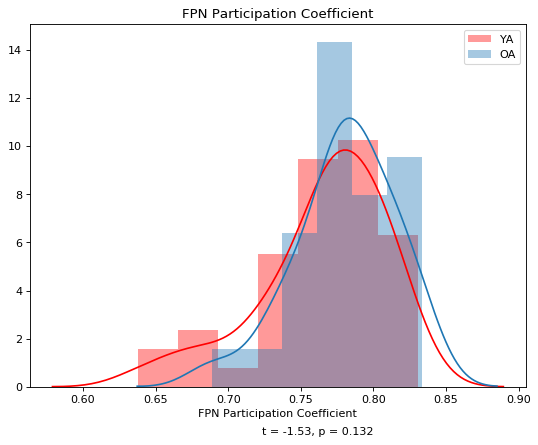

In [522]:
plt.figure(figsize=(8, 6), dpi=80)
sns.distplot(df[df['Group'] == 'Young Adults']['pc_fpn_mean'].dropna(), label = 'YA', color = 'red')
sns.distplot(df[(df['Group'] == 'Older Adults') & (df['pc_fpn_mean'] > 0.1)]['pc_fpn_mean'].dropna(), label = 'OA')
plt.xlabel('FPN Participation Coefficient')
plt.legend()
plt.title('FPN Participation Coefficient')

from scipy import stats

ttest = stats.ttest_ind(df[df['Group'] == 'Young Adults']['pc_fpn_mean'].dropna(), df[(df['Group'] == 'Older Adults') & (df['pc_fpn_mean'] > 0.1)]['pc_fpn_mean'].dropna(), axis=0, equal_var=True)

if ttest[1] < 0.001:
    plt.text(.8, -2, 't = %.2f, p < 0.001' % ttest[0], ha='right')
else:
    plt.text(.8, -2, 't = %.2f, p = %.3f' % (ttest[0], ttest[1]), ha='right')

plt.savefig(results_dir + 'hist_fpn-pc.png', dpi=300)

## Rest-activity measures <a id='rest-activity-measures'></a>

Text(0.5,1,'Rhythm Amplitude')

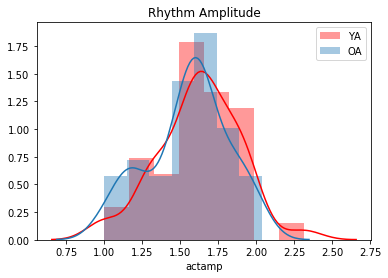

In [523]:
sns.distplot(df[df['Group'] == 'Young Adults']['actamp'].dropna(), label = 'YA', color = 'red')
sns.distplot(df[df['Group'] == 'Older Adults']['actamp'].dropna(), label = 'OA')
plt.legend()
plt.title('Rhythm Amplitude')

Text(0.5,1,'Relative Amplitude')

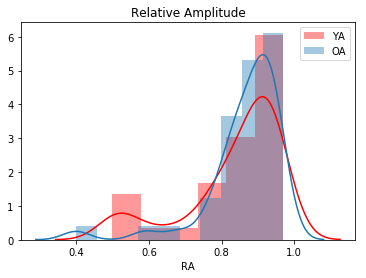

In [524]:
sns.distplot(df[df['Group'] == 'Young Adults']['RA'].dropna(), label = 'YA', color = 'red')
sns.distplot(df[df['Group'] == 'Older Adults']['RA'].dropna(), label = 'OA')
plt.legend()
plt.title('Relative Amplitude')

Text(0.5,1,'Acrophase')

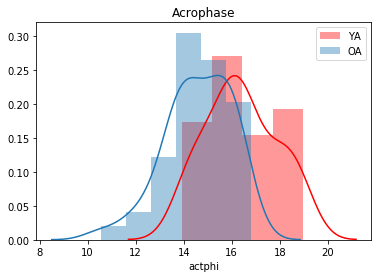

In [525]:
sns.distplot(df[df['Group'] == 'Young Adults']['actphi'].dropna(), label = 'YA', color = 'red')
sns.distplot(df[df['Group'] == 'Older Adults']['actphi'].dropna(), label = 'OA')
plt.legend()
plt.title('Acrophase')

## NBS analysis <a id='nbs-analysis'></a>

In [50]:
df['edge_mean'] = df[cols].mean(axis=1)
df['edge_mean']

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


index
30004    0.476839
30008    0.648607
30009    0.500161
30012         NaN
30015    0.295476
30019    0.445197
30020    0.729619
30023    0.456059
30040    0.429042
30057    0.296823
30064    0.864263
30066    0.474167
30069    0.611416
30074    0.565630
30085    0.743941
30088    0.499921
30090    0.621107
30091    0.604003
30095    0.446543
30096    0.550287
30105    0.562497
30116    0.532232
30119    0.623927
30128    0.392362
30181    0.474722
30217    0.517342
30227    0.726419
30236    0.366414
30242    0.589811
30255    0.766327
           ...   
40656    0.359652
40658    0.580745
40664    0.234041
40665    0.332564
40668    0.567178
40672    0.348979
40685    0.368886
40694    0.388668
40720    0.383433
40728         NaN
40730         NaN
40743    0.286978
40750   -0.142795
40758         NaN
40767         NaN
40768         NaN
40769         NaN
40773         NaN
40775         NaN
40777         NaN
40778    0.594799
40779         NaN
40782         NaN
40784         NaN
4080

In [53]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats.mstats import zscore

regdf = df[['Group', 'mod_mean', 'edge_mean']].dropna()
regdf[['mod_mean', 'edge_mean']] = regdf[['mod_mean', 'edge_mean']].apply(zscore)
regdf = regdf[abs(regdf['edge_mean']) < 3]
regdf = regdf[abs(regdf['mod_mean']) < 3]

model = smf.ols(formula='mod_mean ~ edge_mean + Group', data=regdf).fit()
summary = model.summary()

summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               mod_mean   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     4.357
Date:                Tue, 09 Nov 2021   Prob (F-statistic):             0.0165
Time:                        09:26:30   Log-Likelihood:                -98.273
No. Observations:                  72   AIC:                             202.5
Df Residuals:                      69   BIC:                             209.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.5005      0.205     -2.442      0.017      -0.909      -0.092
Group[T.Young Adults]     0.7813      0.271      2.883      0.005       0.241       1.322
edge_mean                -0.1157      0.139     -0.833      0.408      -0.393       0.161
==============================================================================
Omnibus:                        0.149   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.928   Jarque-Bera (JB):                0.338
Skew:                           0.049   Prob(JB):                        0.845
Kurtosis:                       2.679   Cond. No.                         3.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

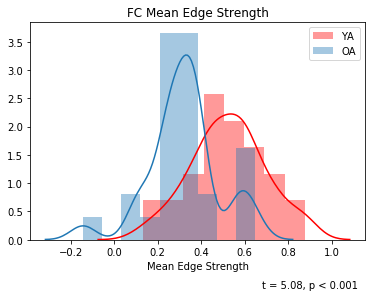

In [528]:
sns.distplot(df[df['Group'] == 'Young Adults']['edge_mean'].dropna(), label = 'YA', color = 'red')
sns.distplot(df[df['Group'] == 'Older Adults']['edge_mean'].dropna(), label = 'OA')
plt.legend()
plt.title('FC Mean Edge Strength')
plt.xlabel('Mean Edge Strength')

from scipy import stats
ttest = stats.ttest_ind(df[df['Group'] == 'Young Adults']['edge_mean'].dropna(), df[df['Group'] == 'Older Adults']['edge_mean'].dropna(), axis=0, equal_var=True)
if ttest[1] < 0.001:
    plt.text(.9, -.85, 't = %.2f, p < 0.001' % ttest[0], ha='center')
else:
    plt.text(.9, -.85, 't = %.2f, p = %.3f' % (ttest[0], ttest[1]), ha='center')

plt.savefig(results_dir + 'hist_edge-strength.png', dpi=300)

Text(37.4631,0.5,'Response Time (ms)')

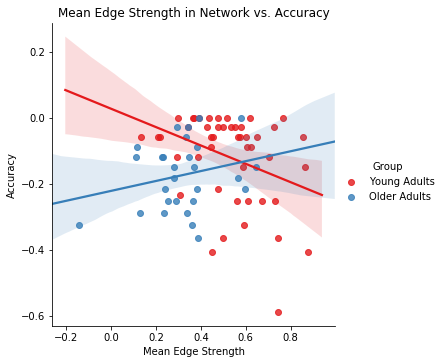

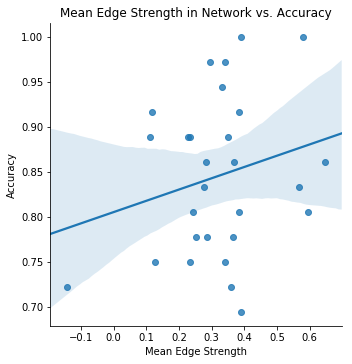

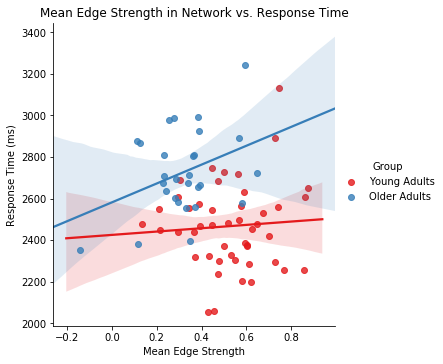

In [99]:
sns.lmplot(data=df, x='edge_mean', y="acc_mean_test_log", hue="Group", palette = 'Set1')
plt.title('Mean Edge Strength in Network vs. Accuracy')
plt.xlabel('Mean Edge Strength'); plt.ylabel('Accuracy')
sns.lmplot(data=df[df['Group'] == 'Older Adults'], x='edge_mean', y="acc_mean_test", palette = 'Set1')
plt.title('Mean Edge Strength in Network vs. Accuracy')
plt.xlabel('Mean Edge Strength'); plt.ylabel('Accuracy')
sns.lmplot(data=df, x='edge_mean', y="rt_c_mean_test", hue="Group", palette = 'Set1')
plt.title('Mean Edge Strength in Network vs. Response Time')
plt.xlabel('Mean Edge Strength'); plt.ylabel('Response Time (ms)')

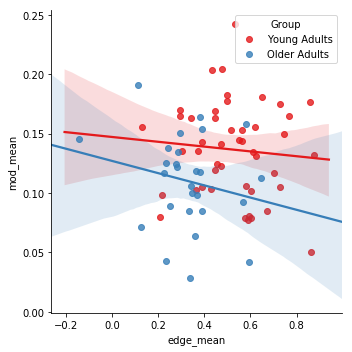

In [529]:
sns.lmplot(data=df.dropna(subset=['edge_mean']), x='edge_mean', y="mod_mean", hue="Group", palette = 'Set1', legend_out=False)

In [356]:
regdf[abs(regdf['edge_mean']) > 3]

,Group,rt_c_mean_test,edge_mean
index,,,
40750,Older Adults,-0.899771,-3.036872


β = -0.46, t = -1.50, p = 0.139


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.2263,0.237,-0.955,0.343,-0.699,0.246
Group[T.Young Adults],0.5723,0.283,2.024,0.047,0.008,1.136
edge_mean,0.1142,0.263,0.434,0.666,-0.411,0.640
Group[T.Young Adults]:edge_mean,-0.4617,0.308,-1.499,0.139,-1.076,0.153


<Figure size 2400x1800 with 0 Axes>

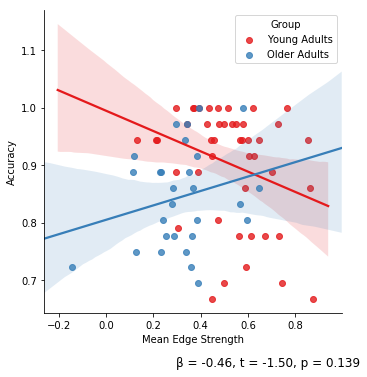

In [530]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats.mstats import zscore

testvar = 'Group[T.Young Adults]:edge_mean'
plot_title = 'edge-mean-accuracy-int'
x_pos = .5
y_pos = -0.03

regdf = df[['Group', 'acc_mean_test_log', 'edge_mean']].dropna()
regdf[['acc_mean_test_log', 'edge_mean']] = regdf[['acc_mean_test_log', 'edge_mean']].apply(zscore)
regdf = regdf[abs(regdf['edge_mean']) < 3]

model = smf.ols(formula='acc_mean_test_log ~ edge_mean + Group + Group:edge_mean', data=regdf).fit()
summary = model.summary()

#df.drop('40750')
plt.figure(figsize=(8, 6), dpi=300)
sns.lmplot(data=df, x='edge_mean', y="acc_mean_test", hue="Group", palette = 'Set1', legend_out=False)
plt.xlabel('Mean Edge Strength'); plt.ylabel('Accuracy')

if model.pvalues[testvar] < 0.001:
    plt.text(x_pos, y_pos, '\u03B2 = %.2f, t = %.2f, p < 0.001' % (model.params[testvar], model.tvalues[testvar]), ha='center')
    print('\u03B2 = %.2f, t = %.2f, p < 0.001' % (model.params[testvar], model.tvalues[testvar]))
else:
    plt.gcf().text(x_pos, y_pos, '\u03B2 = %.2f, t = %.2f, p = %.3f' % (model.params[testvar], model.tvalues[testvar], model.pvalues[testvar]), fontsize=12)
    print('\u03B2 = %.2f, t = %.2f, p = %.3f' % (model.params[testvar], model.tvalues[testvar], model.pvalues[testvar]))

plt.title('')
plt.savefig(results_dir + 'scatter-%s.png' % plot_title, dpi=300, bbox_inches="tight")

summary.tables[1]

β = -0.22, t = -1.62, p = 0.110


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.4186,0.201,-2.083,0.041,-0.819,-0.018
Group[T.Young Adults],0.7148,0.269,2.660,0.010,0.179,1.251
edge_mean,-0.2231,0.138,-1.618,0.110,-0.498,0.052


<Figure size 2400x1800 with 0 Axes>

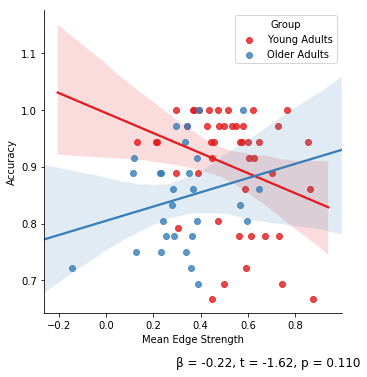

In [531]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats.mstats import zscore

testvar = 'edge_mean'
plot_title = 'edge-mean-accuracy-main'
x_pos = .5
y_pos = -0.03

regdf = df[['Group', 'acc_mean_test_log', 'edge_mean']].dropna()
regdf[['acc_mean_test_log', 'edge_mean']] = regdf[['acc_mean_test_log', 'edge_mean']].apply(zscore)
regdf = regdf[abs(regdf['edge_mean']) < 3]

model = smf.ols(formula='acc_mean_test_log ~ edge_mean + Group', data=regdf).fit()
summary = model.summary()

#df.drop('40750')
plt.figure(figsize=(8, 6), dpi=300)
sns.lmplot(data=df, x='edge_mean', y="acc_mean_test", hue="Group", palette = 'Set1', legend_out=False)
plt.xlabel('Mean Edge Strength'); plt.ylabel('Accuracy')

if model.pvalues[testvar] < 0.001:
    plt.text(x_pos, y_pos, '\u03B2 = %.2f, t = %.2f, p < 0.001' % (model.params[testvar], model.tvalues[testvar]), ha='center')
    print('\u03B2 = %.2f, t = %.2f, p < 0.001' % (model.params[testvar], model.tvalues[testvar]))
else:
    plt.gcf().text(x_pos, y_pos, '\u03B2 = %.2f, t = %.2f, p = %.3f' % (model.params[testvar], model.tvalues[testvar], model.pvalues[testvar]), fontsize=12)
    print('\u03B2 = %.2f, t = %.2f, p = %.3f' % (model.params[testvar], model.tvalues[testvar], model.pvalues[testvar]))

plt.title('')
plt.savefig(results_dir + 'scatter-%s.png' % plot_title, dpi=300, bbox_inches="tight")

summary.tables[1]

β = 0.11, t = 0.47, p = 0.642


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.2263,0.218,-1.036,0.310,-0.676,0.224
edge_mean,0.1142,0.243,0.470,0.642,-0.386,0.614


<Figure size 2400x1800 with 0 Axes>

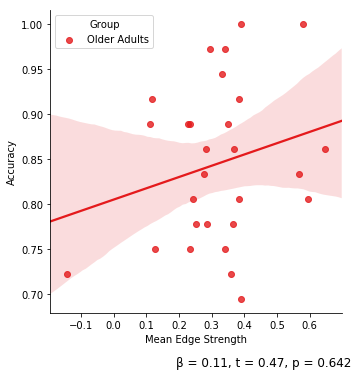

In [533]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats.mstats import zscore

testvar = 'edge_mean'
plot_title = 'oa-edge-mean-accuracy-main'
x_pos = .5
y_pos = -0.03

regdf = df[['Group', 'acc_mean_test_log', 'edge_mean']].dropna()
regdf[['acc_mean_test_log', 'edge_mean']] = regdf[['acc_mean_test_log', 'edge_mean']].apply(zscore)
regdf = regdf[abs(regdf['edge_mean']) < 3]
regdf = regdf[regdf['Group'] == 'Older Adults']

model = smf.ols(formula='acc_mean_test_log ~ edge_mean', data=regdf).fit()
summary = model.summary()

#df.drop('40750')
plt.figure(figsize=(8, 6), dpi=300)
sns.lmplot(data=df[df['Group'] == 'Older Adults'], x='edge_mean', y="acc_mean_test", hue="Group", palette = 'Set1', legend_out=False)
plt.xlabel('Mean Edge Strength'); plt.ylabel('Accuracy')

if model.pvalues[testvar] < 0.001:
    plt.text(x_pos, y_pos, '\u03B2 = %.2f, t = %.2f, p < 0.001' % (model.params[testvar], model.tvalues[testvar]), ha='center')
    print('\u03B2 = %.2f, t = %.2f, p < 0.001' % (model.params[testvar], model.tvalues[testvar]))
else:
    plt.gcf().text(x_pos, y_pos, '\u03B2 = %.2f, t = %.2f, p = %.3f' % (model.params[testvar], model.tvalues[testvar], model.pvalues[testvar]), fontsize=12)
    print('\u03B2 = %.2f, t = %.2f, p = %.3f' % (model.params[testvar], model.tvalues[testvar], model.pvalues[testvar]))

plt.title('')
plt.savefig(results_dir + 'scatter-%s.png' % plot_title, dpi=300, bbox_inches="tight")

summary.tables[1]

β = -0.27, t = -1.03, p = 0.309


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.9441,0.202,4.671,0.000,0.541,1.347
Group[T.Young Adults],-1.3870,0.241,-5.750,0.000,-1.868,-0.906
edge_mean,0.2465,0.225,1.098,0.276,-0.202,0.695
Group[T.Young Adults]:edge_mean,-0.2694,0.263,-1.025,0.309,-0.794,0.255


<Figure size 2400x1800 with 0 Axes>

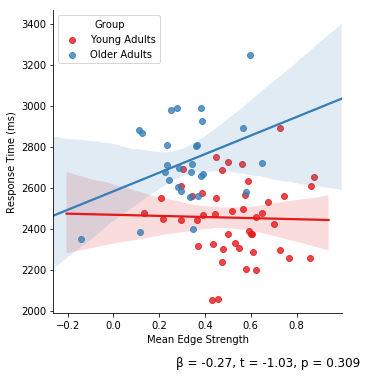

In [532]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats.mstats import zscore

testvar = 'Group[T.Young Adults]:edge_mean'
plot_title = 'edge-mean-rt-nooutlier'
x_pos = .5
y_pos = -0.03

regdf = df[['Group', 'rt_c_mean_test', 'edge_mean']].dropna()
regdf[['rt_c_mean_test', 'edge_mean']] = regdf[['rt_c_mean_test', 'edge_mean']].apply(zscore)
regdf = regdf[abs(regdf['edge_mean']) < 3]
# regdf = regdf[regdf['Group'] == "Older Adults"]

model = smf.ols(formula='rt_c_mean_test ~ edge_mean + Group + Group:edge_mean', data=regdf).fit()
summary = model.summary()

#df = df.drop('40750')
plt.figure(figsize=(8, 6), dpi=300)
sns.lmplot(data=df, x='edge_mean', y="rt_c_mean_test", hue="Group", palette = 'Set1', legend_out=False)
plt.xlabel('Mean Edge Strength'); plt.ylabel('Response Time (ms)')

if model.pvalues[testvar] < 0.001:
    plt.text(x_pos, y_pos, '\u03B2 = %.2f, t = %.2f, p < 0.001' % (model.params[testvar], model.tvalues[testvar]), ha='center')
    print('\u03B2 = %.2f, t = %.2f, p < 0.001' % (model.params[testvar], model.tvalues[testvar]))
else:
    plt.gcf().text(x_pos, y_pos, '\u03B2 = %.2f, t = %.2f, p = %.3f' % (model.params[testvar], model.tvalues[testvar], model.pvalues[testvar]), fontsize=12)
    print('\u03B2 = %.2f, t = %.2f, p = %.3f' % (model.params[testvar], model.tvalues[testvar], model.pvalues[testvar]))

plt.title('')
plt.savefig(results_dir + 'scatter-%s.png' % plot_title, dpi=300, bbox_inches="tight")

summary.tables[1]

In [144]:
import statsmodels.api as sm
import statsmodels.formula.api as smf


regdf = df[['Group', 'rt_c_mean_test', 'edge_mean']].dropna()
regdf[['rt_c_mean_test', 'edge_mean']] = regdf[['rt_c_mean_test', 'edge_mean']].apply(zscore)

model = smf.ols(formula='rt_c_mean_test ~ edge_mean + Group + edge_mean:Group', data=regdf).fit()
summary = model.summary()
summary.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.9314,0.207,4.507,0.000,0.519,1.343
Group[T.Young Adults],-1.3635,0.247,-5.520,0.000,-1.856,-0.871
edge_mean,0.3742,0.197,1.903,0.061,-0.018,0.766
edge_mean:Group[T.Young Adults],-0.3080,0.242,-1.272,0.208,-0.791,0.175


β = 0.30, t = 3.21, p = 0.002


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.4894,0.153,-3.197,0.002,-0.795,-0.183
Group[T.Young Adults],0.8697,0.196,4.438,0.000,0.478,1.261
actamp,0.3042,0.095,3.209,0.002,0.115,0.494


<Figure size 2400x1800 with 0 Axes>

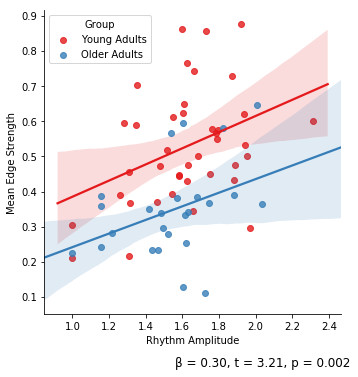

In [534]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats.mstats import zscore

testvar = 'actamp'
plot_title = 'edge-mean-actamp'
x_pos = .5
y_pos = -0.03

regdf = df[['Group', 'actamp', 'edge_mean']].dropna()
regdf = regdf[regdf['actamp'] < 3]
regdf[['actamp', 'edge_mean']] = regdf[['actamp', 'edge_mean']].apply(zscore)
regdf = regdf[abs(regdf['edge_mean']) < 3]
# regdf = regdf[regdf['Group'] == "Older Adults"]

model = smf.ols(formula='edge_mean ~ actamp + Group', data=regdf).fit()
summary = model.summary()

#df = df.drop('40750')
plt.figure(figsize=(8, 6), dpi=300)
sns.lmplot(data=df.drop('40750'), x='actamp', y="edge_mean", hue="Group", palette = 'Set1', legend_out=False)
plt.ylabel('Mean Edge Strength'); plt.xlabel('Rhythm Amplitude')

if model.pvalues[testvar] < 0.001:
    plt.text(x_pos, y_pos, '\u03B2 = %.2f, t = %.2f, p < 0.001' % (model.params[testvar], model.tvalues[testvar]), ha='center')
    print('\u03B2 = %.2f, t = %.2f, p < 0.001' % (model.params[testvar], model.tvalues[testvar]))
else:
    plt.gcf().text(x_pos, y_pos, '\u03B2 = %.2f, t = %.2f, p = %.3f' % (model.params[testvar], model.tvalues[testvar], model.pvalues[testvar]), fontsize=12)
    print('\u03B2 = %.2f, t = %.2f, p = %.3f' % (model.params[testvar], model.tvalues[testvar], model.pvalues[testvar]))

plt.title('')
plt.savefig(results_dir + 'scatter-%s.png' % plot_title, dpi=300, bbox_inches="tight")

summary.tables[1]

In [221]:
nbs_cols = [col for col in df.columns if 'edge_' in col]
nbs_cols.append('rt_c_mean_test')
nbs_cols.append('acc_mean_test')
nbs_cols.append('Group')
nbs_cols

['edge_0',
 'edge_1',
 'edge_2',
 'edge_3',
 'edge_mean',
 'rt_c_mean_test',
 'acc_mean_test',
 'Group']

edge_0            0.223865
edge_1           -0.031375
edge_2           -0.182975
edge_3            0.220339
edge_mean         0.090435
rt_c_mean_test    1.000000
acc_mean_test    -0.697339
Name: rt_c_mean_test, dtype: float64


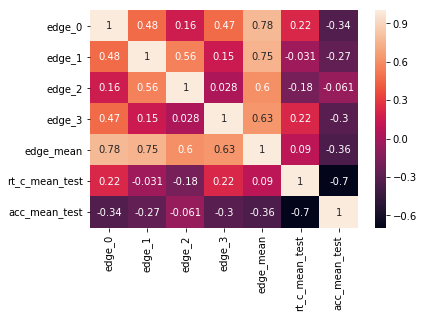

In [222]:
cordf = df[nbs_cols][df['Group'] == "Young Adults"].corr()
print(cordf['rt_c_mean_test'])
hm = sns.heatmap(cordf, annot = True)
plt.show()

edge_0            0.170826
edge_1            0.354859
edge_2            0.146892
edge_3            0.185280
edge_mean         0.309222
rt_c_mean_test    1.000000
acc_mean_test    -0.250964
Name: rt_c_mean_test, dtype: float64


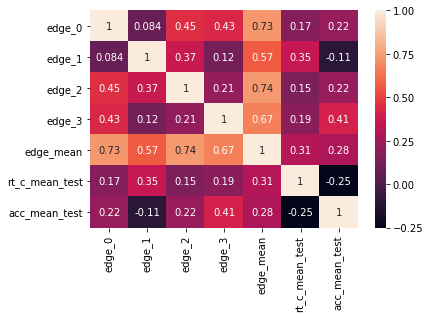

In [225]:
cordf = df[nbs_cols][df['Group'] == "Older Adults"].corr()
print(cordf['rt_c_mean_test'])
hm = sns.heatmap(cordf, annot = True)
plt.show()

Text(0.5,0,'Edge Strength')

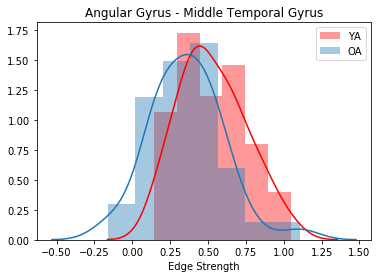

In [319]:
sns.distplot(df[df['Group'] == 'Young Adults']['edge_1'].dropna(), label = 'YA', color = 'red')
sns.distplot(df[df['Group'] == 'Older Adults']['edge_1'].dropna(), label = 'OA')
plt.legend()
plt.title('Paracingulate Gyrus - Frontal Orbital Cortex')
plt.xlabel('Edge Strength')

β = -0.23, t = -1.94, p = 0.056


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.4526,0.190,-2.377,0.020,-0.832,-0.073
Group[T.Young Adults],0.7281,0.248,2.932,0.005,0.233,1.223
edge_1,-0.2338,0.120,-1.941,0.056,-0.474,0.006


<Figure size 2400x1800 with 0 Axes>

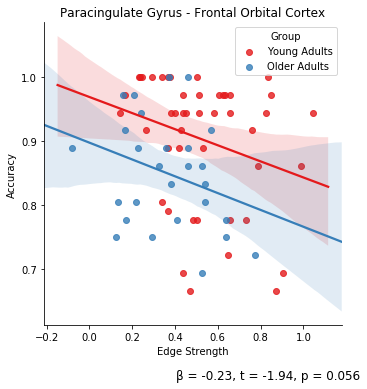

In [542]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats.mstats import zscore

testvar = 'edge_1'
plot_title = 'edge_1-acc'
x_pos = .5
y_pos = -0.03

regdf = df[['Group', 'edge_1', 'acc_mean_test_log']].dropna()
regdf[['edge_1', 'acc_mean_test_log']] = regdf[['edge_1', 'acc_mean_test_log']].apply(zscore)
regdf = regdf[abs(regdf['edge_1']) < 3]
# regdf = regdf[regdf['Group'] == "Older Adults"]

model = smf.ols(formula='acc_mean_test_log ~ edge_1 + Group', data=regdf).fit()
summary = model.summary()

#df = df.drop('40750')
plt.figure(figsize=(8, 6), dpi=300)
sns.lmplot(data=df.drop('40750'), x='edge_1', y="acc_mean_test", hue="Group", palette = 'Set1', legend_out=False)
plt.ylabel('Accuracy'); plt.xlabel('Edge Strength')

if model.pvalues[testvar] < 0.001:
    plt.text(x_pos, y_pos, '\u03B2 = %.2f, t = %.2f, p < 0.001' % (model.params[testvar], model.tvalues[testvar]), ha='center')
    print('\u03B2 = %.2f, t = %.2f, p < 0.001' % (model.params[testvar], model.tvalues[testvar]))
else:
    plt.gcf().text(x_pos, y_pos, '\u03B2 = %.2f, t = %.2f, p = %.3f' % (model.params[testvar], model.tvalues[testvar], model.pvalues[testvar]), fontsize=12)
    print('\u03B2 = %.2f, t = %.2f, p = %.3f' % (model.params[testvar], model.tvalues[testvar], model.pvalues[testvar]))

plt.title('Paracingulate Gyrus - Frontal Orbital Cortex')
plt.savefig(results_dir + 'scatter-%s.png' % plot_title, dpi=300, bbox_inches="tight")

summary.tables[1]

β = -0.43, t = -2.03, p = 0.046


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         rt_c_mean_test   R-squared:                       0.380
Model:                            OLS   Adj. R-squared:                  0.353
Method:                 Least Squares   F-statistic:                     14.30
Date:                Fri, 05 Nov 2021   Prob (F-statistic):           2.30e-07
Time:                        13:01:14   Log-Likelihood:                -87.315
No. Observations:                  74   AIC:                             182.6
Df Residuals:                      70   BIC:                             191.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        0.9188      0.173      5.309      0.000       0.574       1.264
Group[T.Young Adults]           -1.3521      0.214     -6.330      0.000      -1.778      -0.926
edge_1                           0.3640      0.167      2.176      0.033       0.030       0.698
Group[T.Young Adults]:edge_1    -0.4281      0.211     -2.033      0.046      -0.848      -0.008
==============================================================================
Omnibus:                        0.152   Durbin-Watson:                   2.135
Prob(Omnibus):                  0.927   Jarque-Bera (JB):                0.233
Skew:                           0.103   Prob(JB):                        0.890
Kurtosis:                       2.817   Cond. No.                         4.17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<Figure size 2400x1800 with 0 Axes>

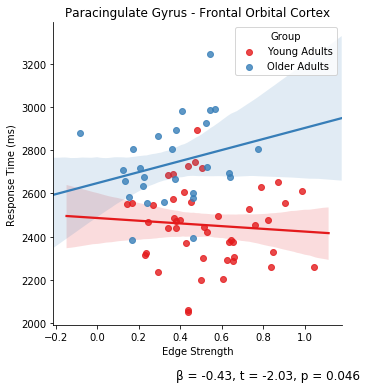

In [546]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats.mstats import zscore

testvar = 'Group[T.Young Adults]:edge_1'
plot_title = 'edge_1-rt-int'
x_pos = .5
y_pos = -0.03

regdf = df[['Group', 'edge_1', 'rt_c_mean_test']].dropna()
regdf[['edge_1', 'rt_c_mean_test']] = regdf[['edge_1', 'rt_c_mean_test']].apply(zscore)
regdf = regdf[abs(regdf['edge_1']) < 3]
# regdf = regdf[regdf['Group'] == "Older Adults"]

model = smf.ols(formula='rt_c_mean_test ~ edge_1 + Group + Group:edge_1', data=regdf).fit()
summary = model.summary()

#df = df.drop('40750')
plt.figure(figsize=(8, 6), dpi=300)
sns.lmplot(data=df.drop('40750'), x='edge_1', y="rt_c_mean_test", hue="Group", palette = 'Set1', legend_out=False)
plt.ylabel('Response Time (ms)'); plt.xlabel('Edge Strength')

if model.pvalues[testvar] < 0.001:
    plt.text(x_pos, y_pos, '\u03B2 = %.2f, t = %.2f, p < 0.001' % (model.params[testvar], model.tvalues[testvar]), ha='center')
    print('\u03B2 = %.2f, t = %.2f, p < 0.001' % (model.params[testvar], model.tvalues[testvar]))
else:
    plt.gcf().text(x_pos, y_pos, '\u03B2 = %.2f, t = %.2f, p = %.3f' % (model.params[testvar], model.tvalues[testvar], model.pvalues[testvar]), fontsize=12)
    print('\u03B2 = %.2f, t = %.2f, p = %.3f' % (model.params[testvar], model.tvalues[testvar], model.pvalues[testvar]))

plt.title('Paracingulate Gyrus - Frontal Orbital Cortex')
plt.savefig(results_dir + 'scatter-%s.png' % plot_title, dpi=300, bbox_inches="tight")

summary

In [540]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

regdf = df[['Group', 'acc_mean_test_log', 'edge_1']].dropna()
# regdf = regdf[regdf['Group'] == 'Older Adults']

model = smf.ols(formula='acc_mean_test_log ~ edge_1 + Group', data=regdf).fit()
summary = model.summary()
summary.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.1330,0.030,-4.475,0.000,-0.192,-0.074
Group[T.Young Adults],0.0852,0.029,2.932,0.005,0.027,0.143
edge_1,-0.1167,0.060,-1.941,0.056,-0.236,0.003


In [541]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

regdf = df[['Group', 'rt_c_mean_test', 'edge_1']].dropna()

model = smf.ols(formula='rt_c_mean_test ~ edge_1 + Group + edge_1:Group', data=regdf).fit()
summary = model.summary()
summary.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2603.7687,66.475,39.169,0.000,2471.189,2736.348
Group[T.Young Adults],-117.6470,97.598,-1.205,0.232,-312.300,77.006
edge_1,355.3517,163.296,2.176,0.033,29.667,681.036
edge_1:Group[T.Young Adults],-417.9736,205.607,-2.033,0.046,-828.044,-7.903


Text(0.5,0,'Edge Strength')

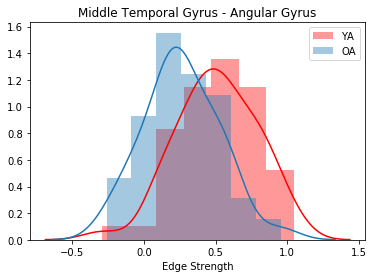

In [334]:
sns.distplot(df[df['Group'] == 'Young Adults']['edge_3'].dropna(), label = 'YA', color = 'red')
sns.distplot(df[df['Group'] == 'Older Adults']['edge_3'].dropna(), label = 'OA')
plt.legend()
plt.title('Middle Temporal Gyrus - Angular Gyrus')
plt.xlabel('Edge Strength')

Text(37.4631,0.5,'Response Time (ms)')

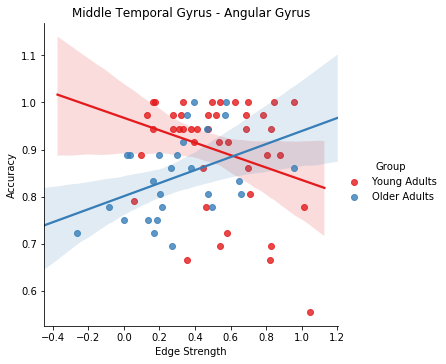

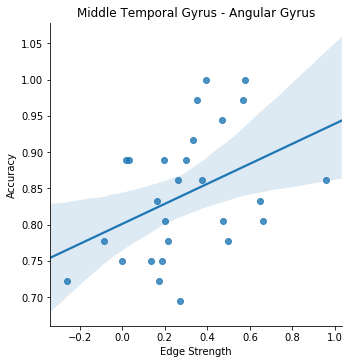

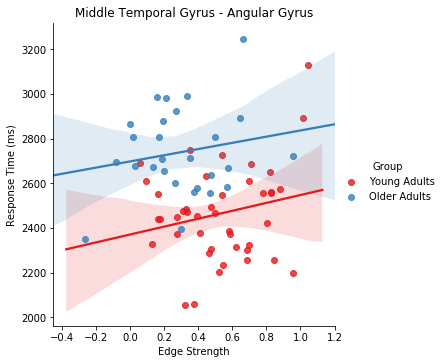

In [342]:
sns.lmplot(data=df, x='edge_3', y="acc_mean_test", hue="Group", palette = 'Set1')
plt.title('Middle Temporal Gyrus - Angular Gyrus')
plt.xlabel('Edge Strength'); plt.ylabel('Accuracy')
sns.lmplot(data=df[df['Group'] == 'Older Adults'], x='edge_3', y="acc_mean_test", palette = 'Set1')
plt.title('Middle Temporal Gyrus - Angular Gyrus')
plt.xlabel('Edge Strength'); plt.ylabel('Accuracy')
sns.lmplot(data=df, x='edge_3', y="rt_c_mean_test", hue="Group", palette = 'Set1')
plt.title('Middle Temporal Gyrus - Angular Gyrus')
plt.xlabel('Edge Strength'); plt.ylabel('Response Time (ms)')

In [238]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

regdf = df[['Group', 'acc_mean_test', 'edge_3']].dropna()
regdf = regdf[regdf['Group'] == 'Older Adults']

model = smf.ols(formula='acc_mean_test ~ edge_3', data=regdf).fit()
summary = model.summary()
summary.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.8011,0.024,32.807,0.000,0.751,0.851
edge_3,0.1381,0.062,2.228,0.035,0.010,0.266


In [240]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

regdf = df[['Group', 'rt_c_mean_test', 'edge_3']].dropna()

model = smf.ols(formula='rt_c_mean_test ~ edge_3 + Group', data=regdf).fit()
summary = model.summary()
summary.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2690.6579,47.708,56.398,0.000,2595.432,2785.884
Group[T.Young Adults],-312.4687,53.638,-5.826,0.000,-419.530,-205.407
edge_3,162.3733,93.584,1.735,0.087,-24.422,349.168


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.0622,0.159,0.391,0.697,-0.255,0.379
Group[T.Young Adults],0.1971,0.056,3.541,0.001,0.086,0.308
actamp,0.2016,0.100,2.013,0.048,0.002,0.401


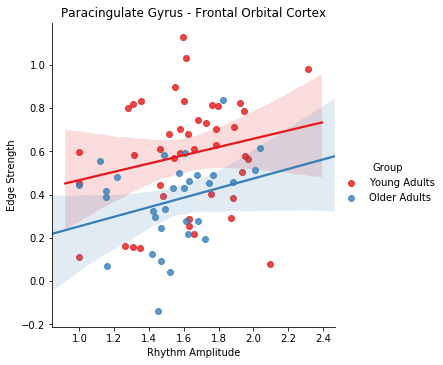

In [364]:
sns.lmplot(data=df, x='actamp', y="edge_2", hue="Group", palette = 'Set1')
plt.title('Paracingulate Gyrus - Frontal Orbital Cortex')
plt.xlabel('Rhythm Amplitude'); plt.ylabel('Edge Strength')

import statsmodels.api as sm
import statsmodels.formula.api as smf

regdf = df[['Group', 'actamp', 'edge_2']].dropna()

model = smf.ols(formula='edge_2 ~ actamp + Group', data=regdf).fit()
summary = model.summary()
summary.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.2913,0.282,-1.033,0.305,-0.854,0.271
Group[T.Young Adults],0.7145,0.359,1.992,0.050,-0.001,1.430
actamp,0.3830,0.182,2.107,0.039,0.021,0.745
Group[T.Young Adults]:actamp,-0.3127,0.226,-1.380,0.172,-0.764,0.139


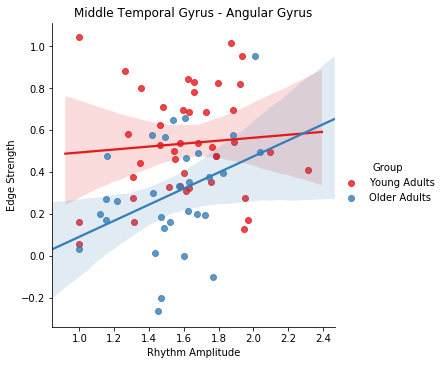

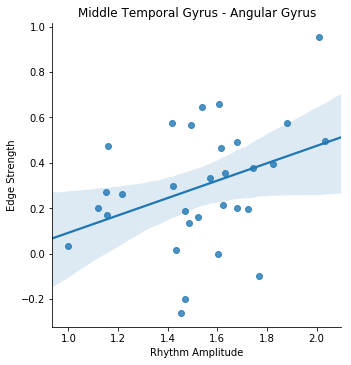

In [370]:
sns.lmplot(data=df, x='actamp', y="edge_3", hue="Group", palette = 'Set1')
plt.title('Middle Temporal Gyrus - Angular Gyrus')
plt.xlabel('Rhythm Amplitude'); plt.ylabel('Edge Strength')

sns.lmplot(data=df[df['Group'] == 'Older Adults'], x='actamp', y="edge_3", palette = 'Set1')
plt.title('Middle Temporal Gyrus - Angular Gyrus')
plt.xlabel('Rhythm Amplitude'); plt.ylabel('Edge Strength')

import statsmodels.api as sm
import statsmodels.formula.api as smf

regdf = df[['Group', 'actamp', 'edge_3']].dropna()
# regdf = regdf[regdf['Group'] == 'Older Adults']

model = smf.ols(formula='edge_3 ~ actamp + Group + Group:actamp', data=regdf).fit()
summary = model.summary()
summary.tables[1]

In [359]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

regdf = df[['Group', 'rt_c_mean_test', 'edge_2']].dropna()

model = smf.ols(formula='rt_c_mean_test ~ edge_2 + Group + Group:edge_2', data=regdf).fit()
summary = model.summary()
summary.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2684.3567,86.173,31.151,0.000,2512.306,2856.408
Group[T.Young Adults],-130.4414,117.683,-1.108,0.272,-365.402,104.519
edge_2,140.0965,195.373,0.717,0.476,-249.978,530.171
Group[T.Young Adults]:edge_2,-291.2134,231.550,-1.258,0.213,-753.519,171.092


### Rest-activity rhythms and memory performance <a id='rar-memory'></a>

### Amplitude

Text(0.5,1,'Amplitude vs. Accuracy')

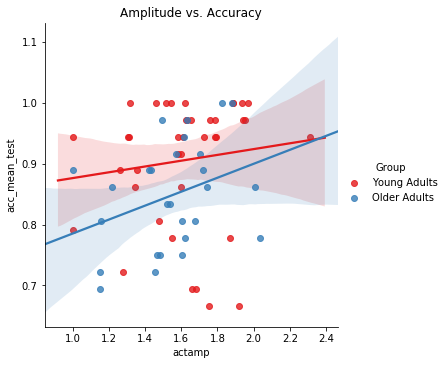

In [971]:
sns.lmplot(data=df, x="actamp", y="acc_mean_test", hue = 'Group', palette = 'Set1')
plt.title('Amplitude vs. Accuracy')

In [80]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

regdf = df[['Group', 'actamp', 'acc_mean_test']].dropna()
regdf[['actamp', 'acc_mean_test']] = regdf[['actamp', 'acc_mean_test']].apply(zscore)
regdf = regdf[regdf['Group'] == 'Older Adults']

model = smf.ols(formula='acc_mean_test ~ actamp', data=regdf).fit()
summary = model.summary()
summary.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.2935,0.165,-1.779,0.087,-0.633,0.046
actamp,0.2997,0.171,1.756,0.091,-0.052,0.651


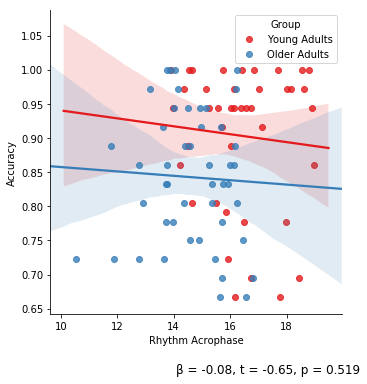

In [425]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

testvar = 'actphi'
regdf = df[['Group', 'actphi', 'acc_mean_test_log', 'actamp']].dropna()
regdf = regdf[regdf['actamp'] < 3]
regdf[['actphi', 'acc_mean_test_log']] = regdf[['actphi', 'acc_mean_test_log']].apply(zscore)

model = smf.ols(formula='acc_mean_test_log ~ actphi + Group', data=regdf).fit()
summary = model.summary()
summary.tables[1]

sns.lmplot(data=df, x='actphi', y="acc_mean_test", hue="Group", palette = 'Set1', legend_out=False)
plt.xlabel('Rhythm Acrophase'); plt.ylabel('Accuracy')

if model.pvalues[testvar] < 0.001:
    plt.text(1, -.05, '\u03B2 = %.2f, t = %.2f, p < 0.001' % (model.params[testvar], model.tvalues[testvar]), ha='center')
else:
    plt.gcf().text(.5, -.05, '\u03B2 = %.2f, t = %.2f, p = %.3f' % (model.params[testvar], model.tvalues[testvar], model.pvalues[testvar]), fontsize=12)

plt.title('')
plt.savefig(results_dir + 'scatter_phi-accuracy.png', dpi=300, bbox_inches="tight")

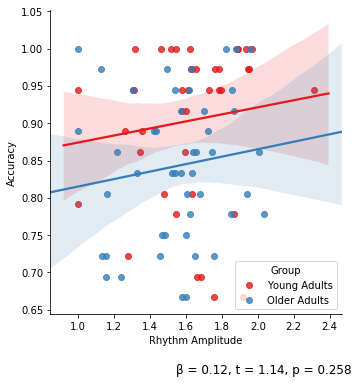

In [423]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

testvar = 'actamp'
regdf = df[['Group', 'actamp', 'acc_mean_test_log']].dropna()
regdf = regdf[regdf['actamp'] < 3]
regdf[['actamp', 'acc_mean_test_log']] = regdf[['actamp', 'acc_mean_test_log']].apply(zscore)

model = smf.ols(formula='acc_mean_test_log ~ actamp + Group', data=regdf).fit()
summary = model.summary()
summary.tables[1]

sns.lmplot(data=df, x='actamp', y="acc_mean_test", hue="Group", palette = 'Set1', legend_out=False)
plt.xlabel('Rhythm Amplitude'); plt.ylabel('Accuracy')

if model.pvalues[testvar] < 0.001:
    plt.text(1, -.05, '\u03B2 = %.2f, t = %.2f, p < 0.001' % (model.params[testvar], model.tvalues[testvar]), ha='center')
else:
    plt.gcf().text(.5, -.05, '\u03B2 = %.2f, t = %.2f, p = %.3f' % (model.params[testvar], model.tvalues[testvar], model.pvalues[testvar]), fontsize=12)

plt.title('')
plt.savefig(results_dir + 'scatter_amp-accuracy.png', dpi=300, bbox_inches="tight")

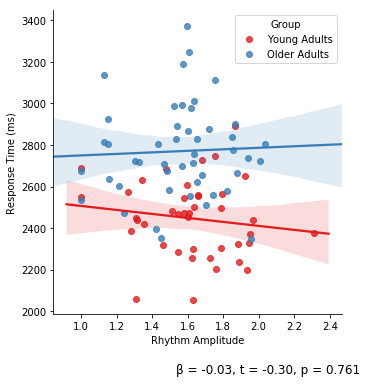

In [426]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

testvar = 'actamp'
regdf = df[['Group', 'actamp', 'rt_c_mean_test']].dropna()
regdf = regdf[regdf['actamp'] < 3]
regdf[['actamp', 'rt_c_mean_test']] = regdf[['actamp', 'rt_c_mean_test']].apply(zscore)

model = smf.ols(formula='rt_c_mean_test ~ actamp + Group', data=regdf).fit()
summary = model.summary()
summary.tables[1]

sns.lmplot(data=df, x='actamp', y="rt_c_mean_test", hue="Group", palette = 'Set1', legend_out=False)
plt.xlabel('Rhythm Amplitude'); plt.ylabel('Response Time (ms)')

if model.pvalues[testvar] < 0.001:
    plt.text(1, -.05, '\u03B2 = %.2f, t = %.2f, p < 0.001' % (model.params[testvar], model.tvalues[testvar]), ha='center')
else:
    plt.gcf().text(.5, -.05, '\u03B2 = %.2f, t = %.2f, p = %.3f' % (model.params[testvar], model.tvalues[testvar], model.pvalues[testvar]), fontsize=12)

plt.title('')
plt.savefig(results_dir + 'scatter_amp-rt.png', dpi=300, bbox_inches="tight")

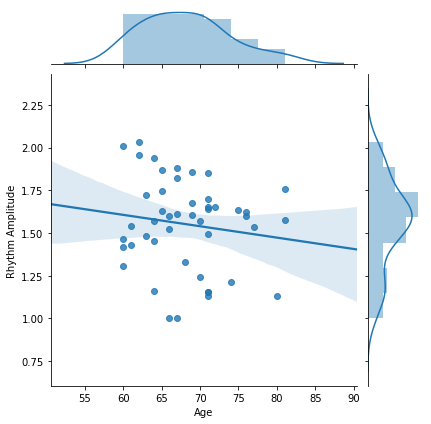

In [535]:
sns.jointplot(data=df[df['Group'] == "Older Adults"], x="age", y="actamp", kind='reg')
# plt.title('Age vs. Accuracy')
plt.xlabel('Age'); plt.ylabel('Rhythm Amplitude')
plt.savefig(results_dir + 'scatter_oa-age-amp.png', dpi=300)

### Relative amplitude

Text(0.5,1,'Relative Amplitude vs. Accuracy')

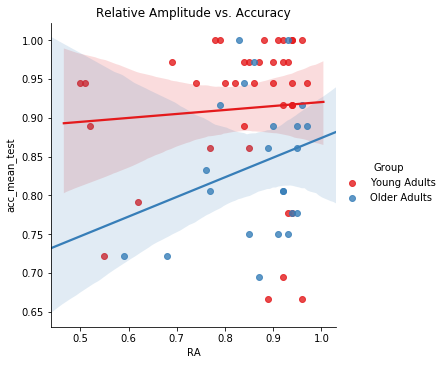

In [681]:
sns.lmplot(data=df, x="RA", y="acc_mean_test", hue="Group", palette = 'Set1')
plt.title('Relative Amplitude vs. Accuracy')

Text(0.5,1,'Relative Amplitude vs. Response Time')

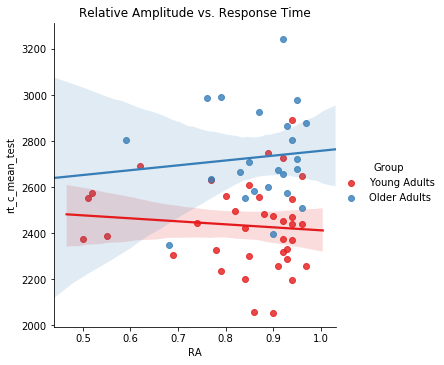

In [682]:
sns.lmplot(data=df, x="RA", y="rt_c_mean_test", hue="Group", palette = 'Set1')
plt.title('Relative Amplitude vs. Response Time')

### Acrophase

Text(0.5,1,'Acrophase vs. Accuracy')

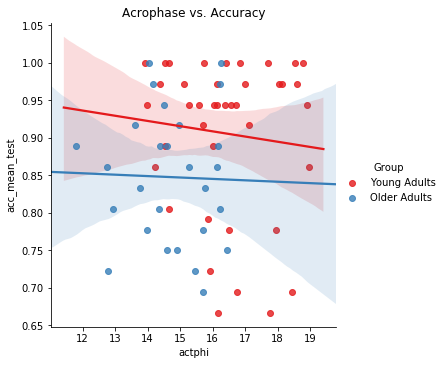

In [683]:
sns.lmplot(data=df, x="actphi", y="acc_mean_test", hue="Group", palette = 'Set1')
plt.title('Acrophase vs. Accuracy')

Text(0.5,1,'Acrophase vs. Response Time')

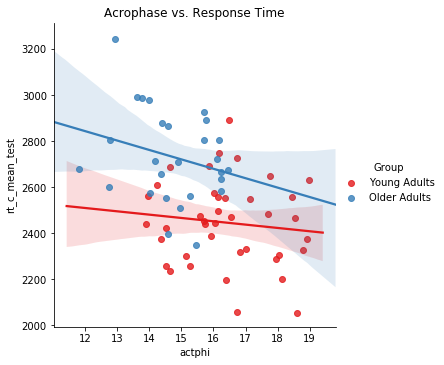

In [684]:
sns.lmplot(data=df, x="actphi", y="rt_c_mean_test", hue="Group", palette = 'Set1')
plt.title('Acrophase vs. Response Time')

In [910]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

regdf = df[['Group', 'actphi', 'rt_c_mean_test']].dropna()

model = smf.ols(formula='rt_c_mean_test ~ actphi + Group + actphi:Group', data=regdf).fit()
summary = model.summary()
summary.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,3334.2184,439.083,7.594,0.000,2456.782,4211.655
Group[T.Young Adults],-651.1680,555.946,-1.171,0.246,-1762.137,459.801
actphi,-40.8749,29.725,-1.375,0.174,-100.275,18.525
actphi:Group[T.Young Adults],26.4389,36.218,0.730,0.468,-45.936,98.814


In [909]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

regdf = df[['Group', 'actphi', 'rt_c_mean_test']].dropna()

model = smf.ols(formula='rt_c_mean_test ~ actphi + Group', data=regdf).fit()
summary = model.summary()
summary.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,3072.0669,251.729,12.204,0.000,2569.181,3574.953
Group[T.Young Adults],-247.3527,55.288,-4.474,0.000,-357.803,-136.902
actphi,-23.0658,16.920,-1.363,0.178,-56.868,10.736


### FC and memory performance <a id='fc-memory'></a>

Text(37.4631,0.5,'Response Time (ms)')

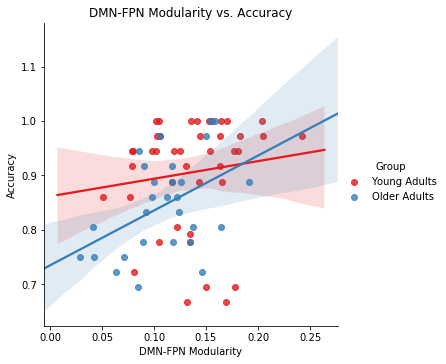

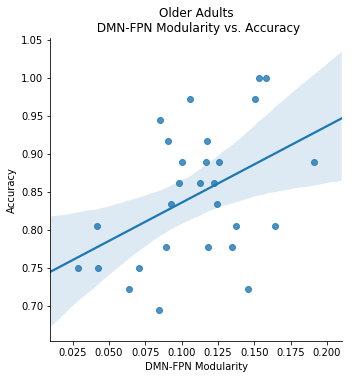

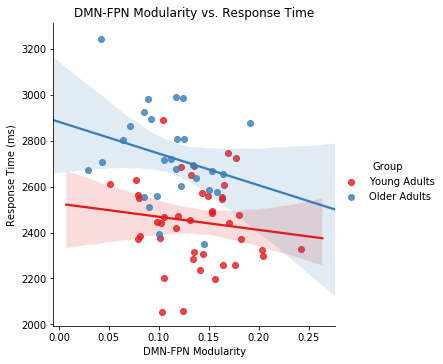

In [66]:
sns.lmplot(data=df, x="mod_mean", y="acc_mean_test", hue='Group', palette = 'Set1')
plt.title('DMN-FPN Modularity vs. Accuracy')
plt.xlabel('DMN-FPN Modularity'); plt.ylabel('Accuracy')
sns.lmplot(data=df[df['Group'] == "Older Adults"], x="mod_mean", y="acc_mean_test", palette = 'Set1')
plt.title('Older Adults\n DMN-FPN Modularity vs. Accuracy')
plt.xlabel('DMN-FPN Modularity'); plt.ylabel('Accuracy')
sns.lmplot(data=df, x="mod_mean", y="rt_c_mean_test", hue="Group", palette = 'Set1')
plt.title('DMN-FPN Modularity vs. Response Time')
plt.xlabel('DMN-FPN Modularity'); plt.ylabel('Response Time (ms)')

[Exploring Linear Regression Coefficients and Interactions](http://joelcarlson.github.io/2016/05/10/Exploring-Interactions/)

β = 0.26, t = 2.23, p = 0.029


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.2401,0.186,-1.289,0.201,-0.611,0.131
Group[T.Young Adults],0.3831,0.240,1.596,0.115,-0.096,0.862
mod_mean,0.2586,0.116,2.227,0.029,0.027,0.490


<Figure size 2400x1800 with 0 Axes>

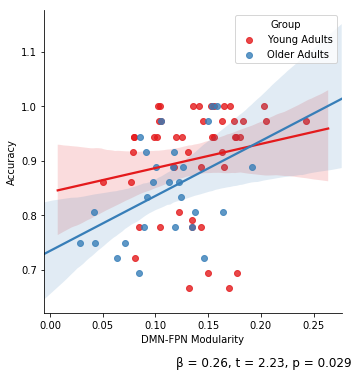

In [555]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats.mstats import zscore

testvar = 'mod_mean'
plot_title = 'dmn-fpn-modularity-accuracy'
x_pos = .5
y_pos = -0.03

regdf = df[['Group', 'acc_mean_test_log', 'mod_mean']].dropna()
regdf[['acc_mean_test_log', 'mod_mean']] = regdf[['acc_mean_test_log', 'mod_mean']].apply(zscore)
# regdf = regdf[regdf['Group'] == "Older Adults"]

model = smf.ols(formula='acc_mean_test_log ~ mod_mean + Group', data=regdf).fit()
summary = model.summary()

plt.figure(figsize=(8, 6), dpi=300)
sns.lmplot(data=df, x='mod_mean', y="acc_mean_test", hue="Group", palette = 'Set1', legend_out=False)
plt.xlabel('DMN-FPN Modularity'); plt.ylabel('Accuracy')

if model.pvalues[testvar] < 0.001:
    plt.text(x_pos, y_pos, '\u03B2 = %.2f, t = %.2f, p < 0.001' % (model.params[testvar], model.tvalues[testvar]), ha='center')
    print('\u03B2 = %.2f, t = %.2f, p < 0.001' % (model.params[testvar], model.tvalues[testvar]))
else:
    plt.gcf().text(x_pos, y_pos, '\u03B2 = %.2f, t = %.2f, p = %.3f' % (model.params[testvar], model.tvalues[testvar], model.pvalues[testvar]), fontsize=12)
    print('\u03B2 = %.2f, t = %.2f, p = %.3f' % (model.params[testvar], model.tvalues[testvar], model.pvalues[testvar]))

plt.title('')
plt.savefig(results_dir + 'scatter-%s.png' % plot_title, dpi=300, bbox_inches="tight")

summary.tables[1]

In [448]:
regdf = df[['Group', 'acc_mean_test_log', 'mod_mean', 'actamp']].dropna()
regdf = regdf[regdf['actamp'] < 3]
regdf[['acc_mean_test_log', 'mod_mean', 'actamp']] = regdf[['acc_mean_test_log', 'mod_mean', 'actamp']].apply(zscore)
regdf = regdf[abs(regdf['actamp']) < 3]

model = smf.ols(formula='acc_mean_test_log ~ 1', data=regdf).fit()
summary = model.summary()
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      acc_mean_test_log   R-squared:                      -0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                      -inf
Date:                Fri, 05 Nov 2021   Prob (F-statistic):                nan
Time:                        09:21:21   Log-Likelihood:                -95.069
No. Observations:                  67   AIC:                             192.1
Df Residuals:                      66   BIC:                             194.3
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.498e-16      0.123   2.03e-15      1.000      -0.246       0.246
==============================================================================
Omnibus:                        7.578   Durbin-Watson:                   1.897
Prob(Omnibus):                  0.023   Jarque-Bera (JB):                7.068
Skew:                          -0.725   Prob(JB):                       0.0292
Kurtosis:                       2.345   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [447]:
regdf = df[['Group', 'acc_mean_test_log', 'mod_mean', 'actamp']].dropna()
regdf = regdf[regdf['actamp'] < 3]
regdf[['acc_mean_test_log', 'mod_mean', 'actamp']] = regdf[['acc_mean_test_log', 'mod_mean', 'actamp']].apply(zscore)
regdf = regdf[abs(regdf['actamp']) < 3]

model = smf.ols(formula='acc_mean_test_log ~ actamp + Group', data=regdf).fit()
summary = model.summary()
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      acc_mean_test_log   R-squared:                       0.102
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     3.617
Date:                Fri, 05 Nov 2021   Prob (F-statistic):             0.0325
Time:                        09:21:16   Log-Likelihood:                -91.482
No. Observations:                  67   AIC:                             189.0
Df Residuals:                      64   BIC:                             195.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.2921      0.188     -1.556      0.125      -0.667       0.083
Group[T.Young Adults]     0.4893      0.244      2.006      0.049       0.002       0.977
actamp                    0.1785      0.120      1.492      0.141      -0.061       0.418
==============================================================================
Omnibus:                       12.316   Durbin-Watson:                   2.036
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               13.135
Skew:                          -1.058   Prob(JB):                      0.00141
Kurtosis:                       3.479   Cond. No.                         2.95
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [449]:
regdf = df[['Group', 'acc_mean_test_log', 'mod_mean', 'actamp']].dropna()
regdf = regdf[regdf['actamp'] < 3]
regdf[['acc_mean_test_log', 'mod_mean', 'actamp']] = regdf[['acc_mean_test_log', 'mod_mean', 'actamp']].apply(zscore)
regdf = regdf[abs(regdf['actamp']) < 3]

model = smf.ols(formula='acc_mean_test_log ~ mod_mean + Group', data=regdf).fit()
summary = model.summary()
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      acc_mean_test_log   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.099
Method:                 Least Squares   F-statistic:                     4.635
Date:                Fri, 05 Nov 2021   Prob (F-statistic):             0.0132
Time:                        09:21:27   Log-Likelihood:                -90.537
No. Observations:                  67   AIC:                             187.1
Df Residuals:                      64   BIC:                             193.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.2203      0.191     -1.154      0.253      -0.602       0.161
Group[T.Young Adults]     0.3690      0.253      1.460      0.149      -0.136       0.874
mod_mean                  0.2516      0.124      2.030      0.047       0.004       0.499
==============================================================================
Omnibus:                       14.079   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.428
Skew:                          -1.120   Prob(JB):                     0.000447
Kurtosis:                       3.712   Cond. No.                         3.14
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [54]:
regdf = df[['Group', 'acc_mean_test_log', 'mod_mean', 'actamp']].dropna()
regdf = regdf[regdf['actamp'] < 3]
regdf[['acc_mean_test_log', 'mod_mean', 'actamp']] = regdf[['acc_mean_test_log', 'mod_mean', 'actamp']].apply(zscore)
regdf = regdf[abs(regdf['actamp']) < 3]

model = smf.ols(formula='acc_mean_test_log ~ mod_mean + actamp + Group', data=regdf).fit()w
summary = model.summary()
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      acc_mean_test_log   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     3.369
Date:                Tue, 09 Nov 2021   Prob (F-statistic):             0.0239
Time:                        09:27:33   Log-Likelihood:                -90.084
No. Observations:                  67   AIC:                             188.2
Df Residuals:                      63   BIC:                             197.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.2159      0.191     -1.130      0.263      -0.598       0.166
Group[T.Young Adults]     0.3617      0.253      1.429      0.158      -0.144       0.868
mod_mean                  0.2139      0.131      1.638      0.106      -0.047       0.475
actamp                    0.1151      0.124      0.926      0.358      -0.133       0.364
==============================================================================
Omnibus:                       15.676   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.747
Skew:                          -1.170   Prob(JB):                     0.000140
Kurtosis:                       3.938   Cond. No.                         3.18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

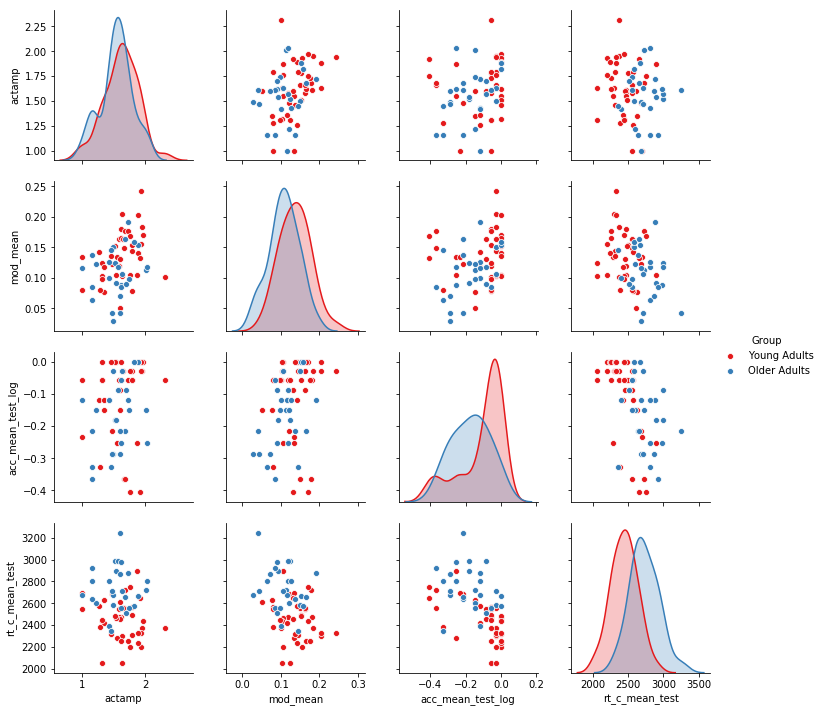

In [459]:
sns.pairplot(df[['actamp', 'mod_mean', 'acc_mean_test_log', 'rt_c_mean_test', 'Group']][df['actamp'] < 3].dropna(), hue='Group', palette = 'Set1')

β = -0.17, t = -1.73, p = 0.087


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.6991,0.157,4.440,0.000,0.385,1.013
Group[T.Young Adults],-1.1156,0.203,-5.496,0.000,-1.520,-0.711
mod_mean,-0.1702,0.098,-1.733,0.087,-0.366,0.026


<Figure size 2400x1800 with 0 Axes>

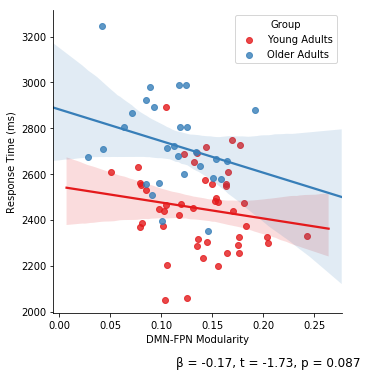

In [554]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats.mstats import zscore

testvar = 'mod_mean'
plot_title = 'dmn-fpn-modularity-rt'
x_pos = .5
y_pos = -0.03

regdf = df[['Group', 'rt_c_mean_test', 'mod_mean']].dropna()
regdf[['rt_c_mean_test', 'mod_mean']] = regdf[['rt_c_mean_test', 'mod_mean']].apply(zscore)
# regdf = regdf[regdf['Group'] == "Older Adults"]

model = smf.ols(formula='rt_c_mean_test ~ mod_mean + Group', data=regdf).fit()
summary = model.summary()

plt.figure(figsize=(8, 6), dpi=300)
sns.lmplot(data=df, x='mod_mean', y="rt_c_mean_test", hue="Group", palette = 'Set1', legend_out=False)
plt.xlabel('DMN-FPN Modularity'); plt.ylabel('Response Time (ms)')

if model.pvalues[testvar] < 0.001:
    plt.gcf().text(x_pos, y_pos, '\u03B2 = %.2f, t = %.2f, p < 0.001' % (model.params[testvar], model.tvalues[testvar]), fontsize=12)
    print('\u03B2 = %.2f, t = %.2f, p < 0.001' % (model.params[testvar], model.tvalues[testvar]))
else:
    plt.gcf().text(x_pos, y_pos, '\u03B2 = %.2f, t = %.2f, p = %.3f' % (model.params[testvar], model.tvalues[testvar], model.pvalues[testvar]), fontsize=12)
    print('\u03B2 = %.2f, t = %.2f, p = %.3f' % (model.params[testvar], model.tvalues[testvar], model.pvalues[testvar]))

plt.title('')
plt.savefig(results_dir + 'scatter-%s.png' % plot_title, dpi=300, bbox_inches="tight")

summary.tables[1]

Text(37.4631,0.5,'Response Time (ms)')

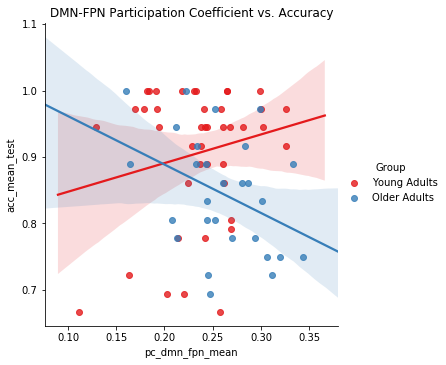

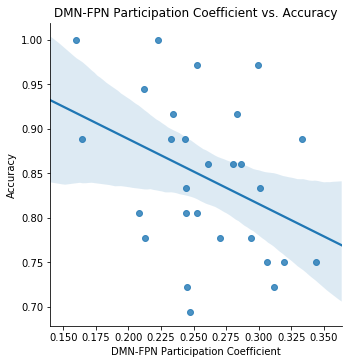

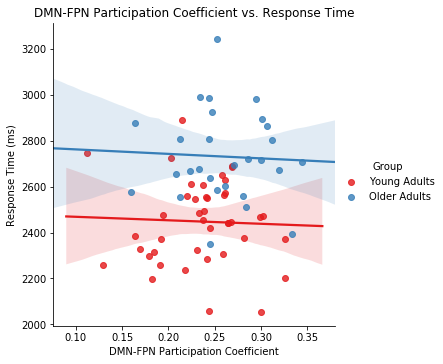

In [70]:
sns.lmplot(data=df, x="pc_dmn_fpn_mean", y="acc_mean_test", hue="Group", palette = 'Set1')
plt.title('DMN-FPN Participation Coefficient vs. Accuracy')
sns.lmplot(data=df[df['Group'] == 'Older Adults'], x="pc_dmn_fpn_mean", y="acc_mean_test", palette = 'Set1')
plt.title('DMN-FPN Participation Coefficient vs. Accuracy')
plt.xlabel('DMN-FPN Participation Coefficient'); plt.ylabel('Accuracy')
sns.lmplot(data=df, x="pc_dmn_fpn_mean", y="rt_c_mean_test", hue="Group", palette = 'Set1')
plt.title('DMN-FPN Participation Coefficient vs. Response Time')
plt.xlabel('DMN-FPN Participation Coefficient'); plt.ylabel('Response Time (ms)')

In [71]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats.mstats import zscore

regdf = df[['Group', 'acc_mean_test', 'pc_dmn_fpn_mean']].dropna()
regdf[['acc_mean_test', 'pc_dmn_fpn_mean']] = regdf[['acc_mean_test', 'pc_dmn_fpn_mean']].apply(zscore)
regdf = regdf[regdf['Group'] == "Older Adults"]

model = smf.ols(formula='acc_mean_test ~ pc_dmn_fpn_mean', data=regdf).fit()
summary = model.summary()
summary.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.2564,0.165,-1.553,0.132,-0.596,0.083
pc_dmn_fpn_mean,-0.3504,0.165,-2.118,0.044,-0.690,-0.010


In [72]:
summary.tables[0]

Dep. Variable:,acc_mean_test,R-squared:,0.147
Model:,OLS,Adj. R-squared:,0.114
Method:,Least Squares,F-statistic:,4.485
Date:,"Tue, 26 Oct 2021",Prob (F-statistic):,0.0439
Time:,13:54:59,Log-Likelihood:,-33.472
No. Observations:,28,AIC:,70.94
Df Residuals:,26,BIC:,73.61
Df Model:,1,,
Covariance Type:,nonrobust,,


β = -0.16, t = -1.29, p = 0.202


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      acc_mean_test_log   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     3.100
Date:                Fri, 05 Nov 2021   Prob (F-statistic):             0.0514
Time:                        13:13:32   Log-Likelihood:                -99.066
No. Observations:                  72   AIC:                             204.1
Df Residuals:                      69   BIC:                             211.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.2557      0.200     -1.281      0.205      -0.654       0.143
Group[T.Young Adults]     0.4003      0.255      1.569      0.121      -0.109       0.909
pc_dmn_mean              -0.1580      0.123     -1.289      0.202      -0.402       0.087
==============================================================================
Omnibus:                       11.797   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               12.685
Skew:                          -1.016   Prob(JB):                      0.00176
Kurtosis:                       3.313   Cond. No.                         3.33
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<Figure size 2400x1800 with 0 Axes>

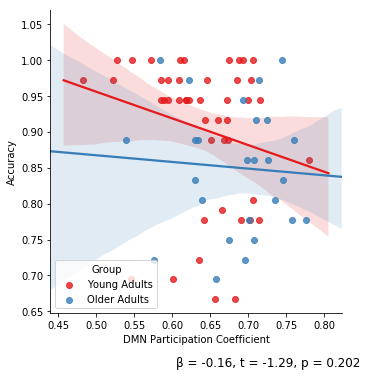

In [556]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats.mstats import zscore

testvar = 'pc_dmn_mean'
plot_title = 'dmn-pc-accuracy'
x_pos = .5
y_pos = -0.03

regdf = df[['Group', 'acc_mean_test_log', 'pc_dmn_mean']].dropna()
regdf[['acc_mean_test_log', 'pc_dmn_mean']] = regdf[['acc_mean_test_log', 'pc_dmn_mean']].apply(zscore)
# regdf = regdf[regdf['Group'] == "Older Adults"]

model = smf.ols(formula='acc_mean_test_log ~ pc_dmn_mean + Group', data=regdf).fit()
summary = model.summary()

plt.figure(figsize=(8, 6), dpi=300)
sns.lmplot(data=df, x='pc_dmn_mean', y="acc_mean_test", hue="Group", palette = 'Set1', legend_out=False)
plt.xlabel('DMN Participation Coefficient'); plt.ylabel('Accuracy')

if model.pvalues[testvar] < 0.001:
    plt.gcf().text(x_pos, y_pos, '\u03B2 = %.2f, t = %.2f, p < 0.001' % (model.params[testvar], model.tvalues[testvar]), fontsize=12)
    print('\u03B2 = %.2f, t = %.2f, p < 0.001' % (model.params[testvar], model.tvalues[testvar]))
else:
    plt.gcf().text(x_pos, y_pos, '\u03B2 = %.2f, t = %.2f, p = %.3f' % (model.params[testvar], model.tvalues[testvar], model.pvalues[testvar]), fontsize=12)
    print('\u03B2 = %.2f, t = %.2f, p = %.3f' % (model.params[testvar], model.tvalues[testvar], model.pvalues[testvar]))

plt.title('')
plt.savefig(results_dir + 'scatter-%s.png' % plot_title, dpi=300, bbox_inches="tight")

summary

β = -0.54, t = -2.19, p = 0.033


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            pc_dmn_mean   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.135
Method:                 Least Squares   F-statistic:                     4.267
Date:                Fri, 05 Nov 2021   Prob (F-statistic):            0.00850
Time:                        13:15:47   Log-Likelihood:                -84.624
No. Observations:                  64   AIC:                             177.2
Df Residuals:                      60   BIC:                             185.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        0.4555      0.190      2.391      0.020       0.074       0.836
Group[T.Young Adults]           -0.6882      0.243     -2.831      0.006      -1.174      -0.202
actamp                           0.2768      0.194      1.424      0.160      -0.112       0.665
Group[T.Young Adults]:actamp    -0.5357      0.245     -2.187      0.033      -1.026      -0.046
==============================================================================
Omnibus:                        2.768   Durbin-Watson:                   2.139
Prob(Omnibus):                  0.251   Jarque-Bera (JB):                2.106
Skew:                          -0.286   Prob(JB):                        0.349
Kurtosis:                       2.321   Cond. No.                         3.33
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<Figure size 2400x1800 with 0 Axes>

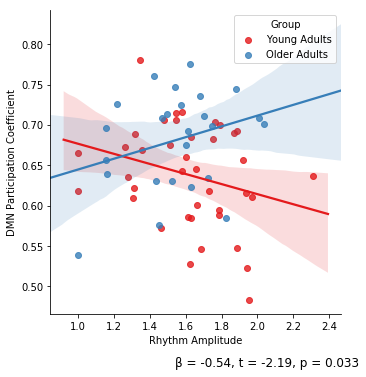

In [560]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats.mstats import zscore

testvar = 'Group[T.Young Adults]:actamp'
plot_title = 'dmn-pc-amp-int'
x_pos = .5
y_pos = -0.03

regdf = df[['Group', 'actamp', 'pc_dmn_mean']].dropna()
regdf[['actamp', 'pc_dmn_mean']] = regdf[['actamp', 'pc_dmn_mean']].apply(zscore)
# regdf = regdf[regdf['Group'] == "Older Adults"]

model = smf.ols(formula='pc_dmn_mean ~ actamp + Group + Group:actamp', data=regdf).fit()
summary = model.summary()

plt.figure(figsize=(8, 6), dpi=300)
sns.lmplot(data=df, x='actamp', y="pc_dmn_mean", hue="Group", palette = 'Set1', legend_out=False)
plt.ylabel('DMN Participation Coefficient'); plt.xlabel('Rhythm Amplitude')

if model.pvalues[testvar] < 0.001:
    plt.gcf().text(x_pos, y_pos, '\u03B2 = %.2f, t = %.2f, p < 0.001' % (model.params[testvar], model.tvalues[testvar]), fontsize=12)
    print('\u03B2 = %.2f, t = %.2f, p < 0.001' % (model.params[testvar], model.tvalues[testvar]))
else:
    plt.gcf().text(x_pos, y_pos, '\u03B2 = %.2f, t = %.2f, p = %.3f' % (model.params[testvar], model.tvalues[testvar], model.pvalues[testvar]), fontsize=12)
    print('\u03B2 = %.2f, t = %.2f, p = %.3f' % (model.params[testvar], model.tvalues[testvar], model.pvalues[testvar]))

plt.title('')
plt.savefig(results_dir + 'scatter-%s.png' % plot_title, dpi=300, bbox_inches="tight")

summary

β = 0.18, t = 1.78, p = 0.080


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         rt_c_mean_test   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.358
Method:                 Least Squares   F-statistic:                     20.77
Date:                Fri, 05 Nov 2021   Prob (F-statistic):           8.66e-08
Time:                        13:10:44   Log-Likelihood:                -85.195
No. Observations:                  72   AIC:                             176.4
Df Residuals:                      69   BIC:                             183.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.7031      0.165      4.270      0.000       0.375       1.032
Group[T.Young Adults]    -1.1005      0.210     -5.230      0.000      -1.520      -0.681
pc_dmn_mean               0.1795      0.101      1.776      0.080      -0.022       0.381
==============================================================================
Omnibus:                        0.060   Durbin-Watson:                   2.123
Prob(Omnibus):                  0.970   Jarque-Bera (JB):                0.158
Skew:                          -0.065   Prob(JB):                        0.924
Kurtosis:                       2.810   Cond. No.                         3.33
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<Figure size 2400x1800 with 0 Axes>

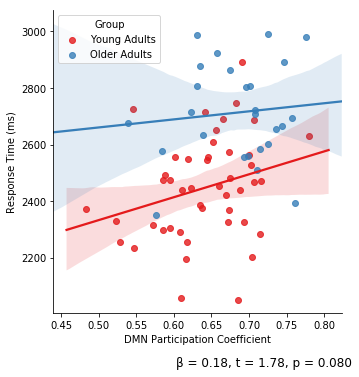

In [553]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats.mstats import zscore

testvar = 'pc_dmn_mean'
plot_title = 'dmn-pc-rt'
x_pos = .5
y_pos = -0.03

regdf = df[['Group', 'rt_c_mean_test', 'pc_dmn_mean']].dropna()
regdf[['rt_c_mean_test', 'pc_dmn_mean']] = regdf[['rt_c_mean_test', 'pc_dmn_mean']].apply(zscore)
# regdf = regdf[regdf['Group'] == "Older Adults"]

model = smf.ols(formula='rt_c_mean_test ~ pc_dmn_mean + Group', data=regdf).fit()
summary = model.summary()

plt.figure(figsize=(8, 6), dpi=300)
sns.lmplot(data=df, x='pc_dmn_mean', y="rt_c_mean_test", hue="Group", palette = 'Set1', legend_out=False)
plt.xlabel('DMN Participation Coefficient'); plt.ylabel('Response Time (ms)')

if model.pvalues[testvar] < 0.001:
    plt.gcf().text(x_pos, y_pos, '\u03B2 = %.2f, t = %.2f, p < 0.001' % (model.params[testvar], model.tvalues[testvar]), fontsize=12)
    print('\u03B2 = %.2f, t = %.2f, p < 0.001' % (model.params[testvar], model.tvalues[testvar]))
else:
    plt.gcf().text(x_pos, y_pos, '\u03B2 = %.2f, t = %.2f, p = %.3f' % (model.params[testvar], model.tvalues[testvar], model.pvalues[testvar]), fontsize=12)
    print('\u03B2 = %.2f, t = %.2f, p = %.3f' % (model.params[testvar], model.tvalues[testvar], model.pvalues[testvar]))

plt.title('')
plt.savefig(results_dir + 'scatter-%s.png' % plot_title, dpi=300, bbox_inches="tight")

summary

In [406]:
regdf[abs(regdf['pc_dmn_mean']) > 1.5]

,Group,acc_mean_test_log,pc_dmn_mean
index,,,
30009,Young Adults,0.871833,-1.657607


Empty DataFrame
Columns: [Group, acc_mean_test_log, pc_dmn_mean]
Index: []
β = -0.15, t = -1.29, p = 0.200


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.3268,0.192,-1.703,0.093,-0.710,0.056
Group[T.Young Adults],0.5115,0.240,2.131,0.037,0.033,0.990
pc_dmn_mean,-0.1492,0.115,-1.294,0.200,-0.379,0.081


<Figure size 2400x1800 with 0 Axes>

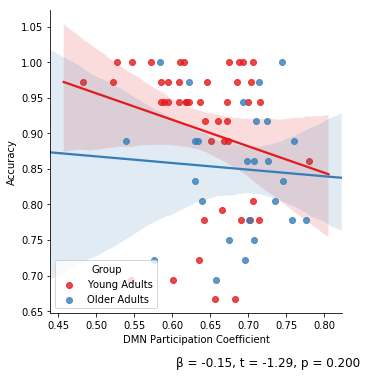

In [415]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats.mstats import zscore

testvar = 'pc_dmn_mean'
plot_title = 'dmn-pc-accuracy'
x_pos = .5
y_pos = -0.03

regdf = df[['Group', 'acc_mean_test_log', 'pc_dmn_mean']].dropna()
regdf = regdf[regdf['pc_dmn_mean'] > 0.2]
regdf['pc_dmn_mean'] = regdf.groupby(['Group'])['pc_dmn_mean'].apply(zscore)
print(regdf[abs(regdf['pc_dmn_mean']) > 3])
regdf[['acc_mean_test_log', 'pc_dmn_mean']] = regdf[['acc_mean_test_log', 'pc_dmn_mean']].apply(zscore)


model = smf.ols(formula='acc_mean_test_log ~ pc_dmn_mean + Group', data=regdf).fit()
summary = model.summary()

plt.figure(figsize=(8, 6), dpi=300)
sns.lmplot(data=df[df['pc_dmn_mean'] > 0.2], x = 'pc_dmn_mean', y="acc_mean_test", hue="Group", palette = 'Set1', legend_out=False)
plt.xlabel('DMN Participation Coefficient'); plt.ylabel('Accuracy')

if model.pvalues[testvar] < 0.001:
    plt.text(x_pos, y_pos, '\u03B2 = %.2f, t = %.2f, p < 0.001' % (model.params[testvar], model.tvalues[testvar]), ha='center')
    print('\u03B2 = %.2f, t = %.2f, p < 0.001' % (model.params[testvar], model.tvalues[testvar]))
else:
    plt.gcf().text(x_pos, y_pos, '\u03B2 = %.2f, t = %.2f, p = %.3f' % (model.params[testvar], model.tvalues[testvar], model.pvalues[testvar]), fontsize=12)
    print('\u03B2 = %.2f, t = %.2f, p = %.3f' % (model.params[testvar], model.tvalues[testvar], model.pvalues[testvar]))

plt.title('')
plt.savefig(results_dir + 'scatter-%s.png' % plot_title, dpi=300, bbox_inches="tight")

summary.tables[1]

In [917]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

regdf = df[['Group', 'rt_c_mean_test', 'pc_dmn_mean']].dropna()

model = smf.ols(formula='rt_c_mean_test ~ pc_dmn_mean + Group', data=regdf).fit()
summary = model.summary()
summary.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2292.8711,246.117,9.316,0.000,1801.196,2784.546
Group[T.Young Adults],-241.6427,47.228,-5.117,0.000,-335.991,-147.294
pc_dmn_mean,614.9045,356.104,1.727,0.089,-96.495,1326.304


Text(37.4631,0.5,'Response Time (ms)')

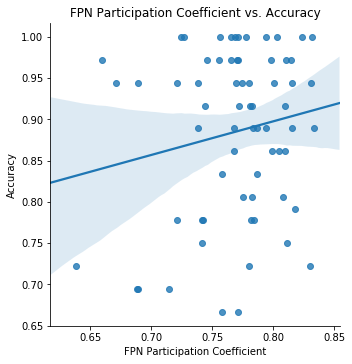

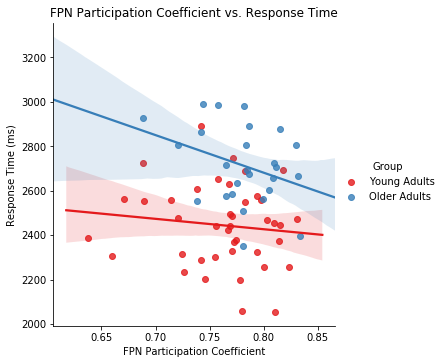

In [901]:
sns.lmplot(data=df, x="pc_fpn_mean", y="acc_mean_test", palette = 'Set1')
plt.title('FPN Participation Coefficient vs. Accuracy')
plt.xlabel('FPN Participation Coefficient'); plt.ylabel('Accuracy')
sns.lmplot(data=df, x="pc_fpn_mean", y="rt_c_mean_test", hue="Group", palette = 'Set1')
plt.title('FPN Participation Coefficient vs. Response Time')
plt.xlabel('FPN Participation Coefficient'); plt.ylabel('Response Time (ms)')

In [723]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

regdf = df[['Group', 'rt_c_mean_test', 'pc_fpn_mean']].dropna()

model = smf.ols(formula='rt_c_mean_test ~ pc_fpn_mean + Group', data=regdf).fit()
summary = model.summary()
summary.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,8.1449,0.164,49.557,0.000,7.817,8.473
Group[T.Young Adults],-0.1111,0.018,-6.113,0.000,-0.147,-0.075
pc_fpn_mean,-0.3086,0.210,-1.471,0.146,-0.728,0.111


### Rest-activity rhythms and FC <a id='rar-fc'></a>

Text(37.2557,0.5,'DMN Participation Coefficient')

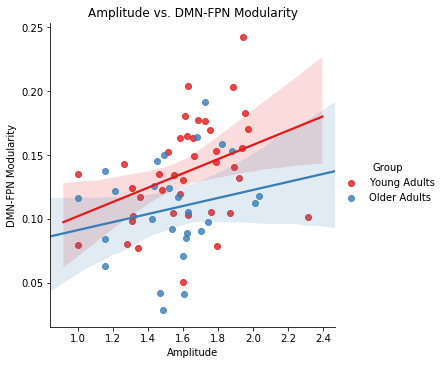

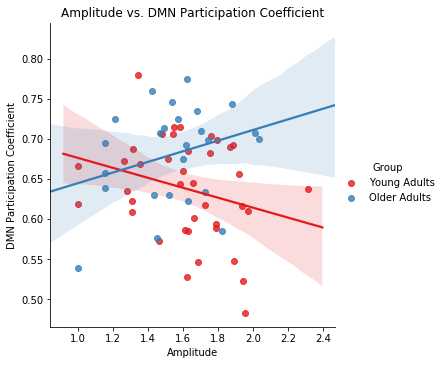

In [74]:
sns.lmplot(data=df, x="actamp", y="mod_mean", hue = 'Group', palette = 'Set1')
plt.title('Amplitude vs. DMN-FPN Modularity')
plt.xlabel('Amplitude'); plt.ylabel('DMN-FPN Modularity')
sns.lmplot(data=df, x="actamp", y="pc_dmn_mean", hue="Group", palette = 'Set1')
plt.title('Amplitude vs. DMN Participation Coefficient')
plt.xlabel('Amplitude'); plt.ylabel('DMN Participation Coefficient')

In [329]:
regdf['actamp'][regdf['actamp'] > 3]

index
40175    4.760872
Name: actamp, dtype: float64

β = 0.30, t = 2.62, p = 0.011


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.3563,0.177,-2.008,0.049,-0.711,-0.002
Group[T.Young Adults],0.5968,0.231,2.589,0.012,0.136,1.057
actamp,0.2965,0.113,2.622,0.011,0.071,0.522


<Figure size 2400x1800 with 0 Axes>

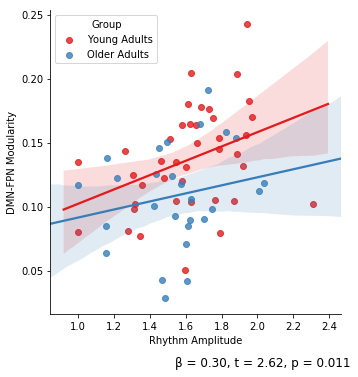

In [416]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats.mstats import zscore

testvar = 'actamp'
plot_title = 'amp-dmn-fpn-modularity'
x_pos = .5
y_pos = -0.03

regdf = df[['Group', 'actamp', 'mod_mean']].dropna()
regdf = regdf[regdf['actamp'] < 3]
regdf[['actamp', 'mod_mean']] = regdf[['actamp', 'mod_mean']].apply(zscore)
regdf = regdf[regdf['actamp'] < 3]

model = smf.ols(formula='mod_mean ~ actamp + Group', data=regdf).fit()
summary = model.summary()

plt.figure(figsize=(8, 6), dpi=300)
sns.lmplot(data=df, x='actamp', y="mod_mean", hue="Group", palette = 'Set1', legend_out=False)
plt.xlabel('Rhythm Amplitude'); plt.ylabel('DMN-FPN Modularity')

if model.pvalues[testvar] < 0.001:
    plt.gcf().text(x_pos, y_pos, '\u03B2 = %.2f, t = %.2f, p < 0.001' % (model.params[testvar], model.tvalues[testvar]), fontsize=12)
    print('\u03B2 = %.2f, t = %.2f, p < 0.001' % (model.params[testvar], model.tvalues[testvar]))
else:
    plt.gcf().text(x_pos, y_pos, '\u03B2 = %.2f, t = %.2f, p = %.3f' % (model.params[testvar], model.tvalues[testvar], model.pvalues[testvar]), fontsize=12)
    print('\u03B2 = %.2f, t = %.2f, p = %.3f' % (model.params[testvar], model.tvalues[testvar], model.pvalues[testvar]))

plt.title('')
plt.savefig(results_dir + 'scatter-%s.png' % plot_title, dpi=300, bbox_inches="tight")

summary.tables[1]

In [925]:
summary.tables[0]

Dep. Variable:,mod_mean,R-squared:,0.198
Model:,OLS,Adj. R-squared:,0.173
Method:,Least Squares,F-statistic:,7.901
Date:,"Fri, 22 Oct 2021",Prob (F-statistic):,0.000858
Time:,14:06:09,Log-Likelihood:,125.32
No. Observations:,67,AIC:,-244.6
Df Residuals:,64,BIC:,-238.0
Df Model:,2,,
Covariance Type:,nonrobust,,


In [78]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

regdf = df[['Group', 'actamp', 'pc_dmn_mean']].dropna()

model = smf.ols(formula='pc_dmn_mean ~ actamp + Group + actamp:Group', data=regdf).fit()
summary = model.summary()
summary.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.5783,0.073,7.885,0.000,0.432,0.725
Group[T.Young Adults],0.1608,0.094,1.707,0.093,-0.028,0.349
actamp,0.0666,0.047,1.424,0.160,-0.027,0.160
actamp:Group[T.Young Adults],-0.1290,0.059,-2.187,0.033,-0.247,-0.011


Text(37.2557,0.5,'DMN Participation Coefficient')

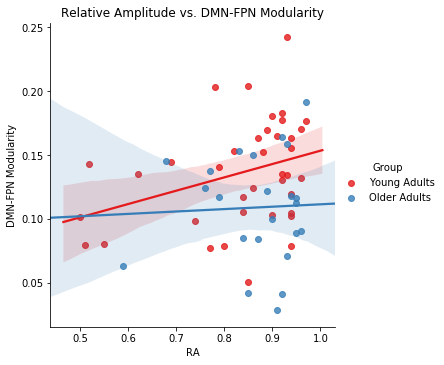

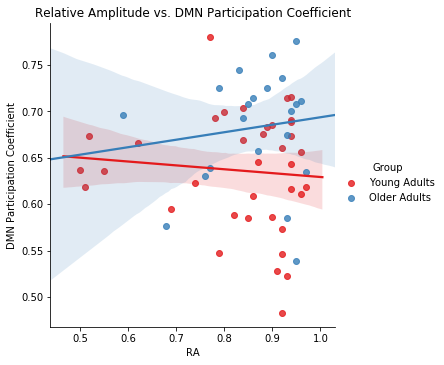

In [706]:
sns.lmplot(data=df, x="RA", y="mod_mean", hue="Group", palette = 'Set1')
plt.title('Relative Amplitude vs. DMN-FPN Modularity')
plt.xlabel('RA'); plt.ylabel('DMN-FPN Modularity')
sns.lmplot(data=df, x="RA", y="pc_dmn_mean", hue="Group", palette = 'Set1')
plt.title('Relative Amplitude vs. DMN Participation Coefficient')
plt.xlabel('RA'); plt.ylabel('DMN Participation Coefficient')

Text(37.2557,0.5,'DMN Participation Coefficient')

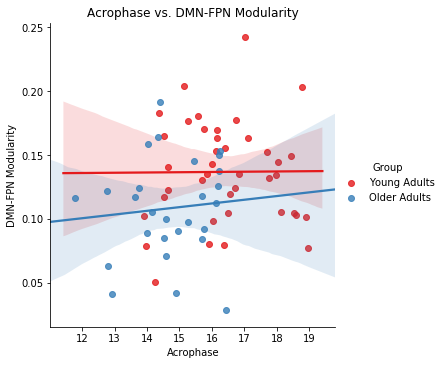

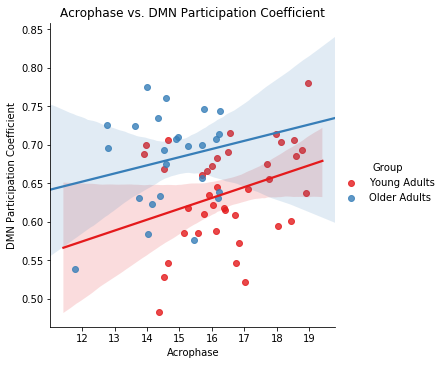

In [877]:
sns.lmplot(data=df, x="actphi", y="mod_mean", hue="Group", palette = 'Set1')
plt.title('Acrophase vs. DMN-FPN Modularity')
plt.xlabel('Acrophase'); plt.ylabel('DMN-FPN Modularity')
sns.lmplot(data=df, x="actphi", y="pc_dmn_mean", hue="Group", palette = 'Set1')
plt.title('Acrophase vs. DMN Participation Coefficient')
plt.xlabel('Acrophase'); plt.ylabel('DMN Participation Coefficient')

In [876]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

regdf = df[['Group', 'actphi', 'pc_dmn_mean']].dropna()

model = smf.ols(formula='pc_dmn_mean ~ actphi + Group', data=regdf).fit()
summary = model.summary()
summary.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.4892,0.084,5.851,0.000,0.322,0.656
Group[T.Young Adults],-0.0662,0.018,-3.621,0.001,-0.103,-0.030
actphi,0.0130,0.006,2.321,0.024,0.002,0.024


In [69]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

regdf = df[['Group', 'actamp', 'mod_mean', 'acc_mean_test_log']].dropna()
regdf[['actamp', 'mod_mean', 'acc_mean_test_log']] = regdf[['actamp', 'mod_mean', 'acc_mean_test_log']].apply(zscore)

model = smf.ols(formula='acc_mean_test_log ~ actamp + mod_mean + Group', data=regdf).fit()
summary = model.summary()
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      acc_mean_test_log   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     3.369
Date:                Tue, 09 Nov 2021   Prob (F-statistic):             0.0239
Time:                        11:00:28   Log-Likelihood:                -90.084
No. Observations:                  67   AIC:                             188.2
Df Residuals:                      63   BIC:                             197.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.2159      0.191     -1.130      0.263      -0.598       0.166
Group[T.Young Adults]     0.3617      0.253      1.429      0.158      -0.144       0.868
actamp                    0.1151      0.124      0.926      0.358      -0.133       0.364
mod_mean                  0.2139      0.131      1.638      0.106      -0.047       0.475
==============================================================================
Omnibus:                       15.676   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.747
Skew:                          -1.170   Prob(JB):                     0.000140
Kurtosis:                       3.938   Cond. No.                         3.18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [70]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

regdf = df[['Group', 'actamp', 'mod_mean', 'acc_mean_test_log']].dropna()
regdf[['actamp', 'mod_mean', 'acc_mean_test_log']] = regdf[['actamp', 'mod_mean', 'acc_mean_test_log']].apply(zscore)

model = smf.ols(formula='acc_mean_test_log ~ mod_mean + Group', data=regdf).fit()
summary = model.summary()
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      acc_mean_test_log   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.099
Method:                 Least Squares   F-statistic:                     4.635
Date:                Tue, 09 Nov 2021   Prob (F-statistic):             0.0132
Time:                        11:00:39   Log-Likelihood:                -90.537
No. Observations:                  67   AIC:                             187.1
Df Residuals:                      64   BIC:                             193.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.2203      0.191     -1.154      0.253      -0.602       0.161
Group[T.Young Adults]     0.3690      0.253      1.460      0.149      -0.136       0.874
mod_mean                  0.2516      0.124      2.030      0.047       0.004       0.499
==============================================================================
Omnibus:                       14.079   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.428
Skew:                          -1.120   Prob(JB):                     0.000447
Kurtosis:                       3.712   Cond. No.                         3.14
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [71]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

regdf = df[['Group', 'actamp', 'mod_mean', 'acc_mean_test_log']].dropna()
regdf[['actamp', 'mod_mean', 'acc_mean_test_log']] = regdf[['actamp', 'mod_mean', 'acc_mean_test_log']].apply(zscore)

model = smf.ols(formula='acc_mean_test_log ~ actamp + Group', data=regdf).fit()
summary = model.summary()
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      acc_mean_test_log   R-squared:                       0.102
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     3.617
Date:                Tue, 09 Nov 2021   Prob (F-statistic):             0.0325
Time:                        11:00:47   Log-Likelihood:                -91.482
No. Observations:                  67   AIC:                             189.0
Df Residuals:                      64   BIC:                             195.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.2921      0.188     -1.556      0.125      -0.667       0.083
Group[T.Young Adults]     0.4893      0.244      2.006      0.049       0.002       0.977
actamp                    0.1785      0.120      1.492      0.141      -0.061       0.418
==============================================================================
Omnibus:                       12.316   Durbin-Watson:                   2.036
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               13.135
Skew:                          -1.058   Prob(JB):                      0.00141
Kurtosis:                       3.479   Cond. No.                         2.95
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# Statistical Analysis <a id='stats'></a>

import re
mod = pd.read_csv('/Volumes/psybrain/ADM/derivatives/nibs/results/modularity.csv')
mod['subject'] = mod['subject'].astype(str)

pc0 = pd.read_csv('/Volumes/psybrain/ADM/derivatives/nibs/results/participation_coefficient.csv')
pc0['subject'] = pc0['subject'].astype(str)

df = pd.read_csv('/Users/PSYC-mcm5324/Box/CogNeuroLab/Aging Decision Making R01/data/dataset_2020-10-10.csv')
df['subject'] = df['record_id'].astype(str)
df.set_index('subject')

mem = pd.read_csv('/Users/PSYC-mcm5324/Box/CogNeuroLab/Aging Decision Making R01/data/mri-behavioral/mem_results_06-2021.csv')
mem['subject'] = mem['record_id'].astype(str)
mem.set_index('subject')

# edges['subject'] = edges.index.astype(str)
# edges.reset_index().set_index('subject')
df = pd.merge(df, mem, how='outer').set_index('subject')
mod['mod_mean'] = mod.mean(axis=1)
df = pd.merge(df, mod[['subject', 'mod_mean']].set_index('subject'), left_index=True, right_index=True, how='outer')
df = pd.merge(df, pc0.set_index('subject'), left_index=True, right_index=True, how = 'outer')
df = pd.merge(df, edges_df, left_index=True, right_index=True, how = 'outer').drop(['Unnamed: 0', 'record_id', 'files'], axis=1)
# df = pd.merge(df, pd.DataFrame({'subject': subjects, 'dmn_fpn_fc': x['cue'][dmn][:,fpn].mean(axis=1).mean(axis=0)}).set_index('subject'), left_index=True, right_index=True, how = 'outer')
df = df.reset_index().dropna(how='all')
df['Group'] = np.where(df['index'].astype(int) > 40000, "Older Adults", "Young Adults")
df = df.set_index('index')
df.columns = [re.sub("[ ,-]", "_", re.sub("[\.,`,\$]", "_", str(c))) for c in df.columns]
df = df.drop('40930')
df['acc_mean_test_log'] = np.log(df['acc_mean_test'])
df

df.groupby('Group')['age'].describe()

## Memory Performance <a id='memory-performance'></a>

sns.distplot(df[df['Group'] == 'Young Adults']['acc_mean_learning'].dropna(), label = 'YA', color = 'red')
sns.distplot(df[df['Group'] == 'Older Adults']['acc_mean_learning'].dropna(), label = 'OA')
plt.legend()
plt.title('Mean Accuracy During Learning')
plt.xlabel('Accuracy')
plt.savefig(results_dir + 'hist_accuracy-learning.png', dpi=300)

sns.distplot(df[df['Group'] == 'Young Adults']['acc_mean_test'].dropna(), label = 'YA', color = 'red')
sns.distplot(df[df['Group'] == 'Older Adults']['acc_mean_test'].dropna(), label = 'OA')
plt.legend()
plt.title('Mean Accuracy During Test')
plt.xlabel('Accuracy')
plt.savefig(results_dir + 'hist_accuracy-test.png', dpi=300)

sns.distplot(df[df['Group'] == 'Older Adults']['acc_mean_test'].dropna(), label = 'OA')
sns.distplot(df[df['Group'] == 'Older Adults']['acc_mean_test_log'].dropna(), label = 'OA log', color = 'darkblue')
sns.distplot(df[df['Group'] == 'Young Adults']['acc_mean_test'].dropna(), label = 'YA', color = 'red')
sns.distplot(df[df['Group'] == 'Young Adults']['acc_mean_test_log'].dropna(), label = 'YA log', color = 'darkred')

plt.legend()
plt.title('Mean Accuracy During test')
plt.xlabel('Accuracy')
plt.savefig(results_dir + 'hist_accuracy-test-log.png', dpi=300)

sns.distplot(df[df['Group'] == 'Young Adults']['rt_c_mean_test'].dropna(), label = 'YA', color = 'red')
sns.distplot(df[df['Group'] == 'Older Adults']['rt_c_mean_test'].dropna(), label = 'OA')
plt.legend()
plt.title('Mean Response Time')
plt.xlabel('Response Time (ms)')
plt.savefig(results_dir + 'hist_rtc-test.png', dpi=300)

sns.lmplot(data=df, x="rt_c_mean_test", y="acc_mean_test", hue="Group", palette = 'Set1')
plt.title('Response Time vs. Accuracy')
plt.xlabel('Response Time (ms)'); plt.ylabel('Accuracy')
plt.savefig(results_dir + 'scatter_rtc-accuracy.png', dpi=300)

sns.jointplot(data=df[df['Group'] == "Young Adults"], x="age", y="acc_mean_test_log", color='red')
# plt.title('Age vs. Accuracy')
plt.xlabel('Age'); plt.ylabel('Accuracy')
plt.savefig(results_dir + 'scatter_ya-age-accuracy.png', dpi=300)

sns.jointplot(data=df[df['Group'] == "Older Adults"], x="age", y="acc_mean_test", kind='reg')
# plt.title('Age vs. Accuracy')
plt.xlabel('Age'); plt.ylabel('Accuracy')
plt.savefig(results_dir + 'scatter_oa-age-accuracy.png', dpi=300)

sns.jointplot(data=df[df['Group'] == "Older Adults"], x="age", y="rt_c_mean_test", kind='reg')
# plt.title('Age vs. Accuracy')
plt.xlabel('Age'); plt.ylabel('Response Time (ms)')
plt.savefig(results_dir + 'scatter_oa-age-rt.png', dpi=300)

[RT Transformations resource](https://lindeloev.github.io/shiny-rt/)

df['rt_c_mean_log_test'] = np.log(df['rt_c_mean_test'])
sns.distplot(df[df['Group'] == 'Young Adults']['rt_c_mean_log_test'].dropna(), label = 'YA', color = 'red')
sns.distplot(df[df['Group'] == 'Older Adults']['rt_c_mean_log_test'].dropna(), label = 'OA')
plt.legend()
plt.title('Log Mean Response Time')
plt.savefig(results_dir + 'hist_rtc-log.png', dpi=300)

zscore = lambda x: (x - x.mean()) / x.std()

df['rt_c_mean_test_z'] = df.groupby(['Group']).rt_c_mean_test.transform(zscore)

sns.distplot(df[df['Group'] == 'Older Adults']['rt_c_mean_test_z'].dropna(), label = 'OA z', color = 'darkblue')
sns.distplot(df[df['Group'] == 'Young Adults']['rt_c_mean_test_z'].dropna(), label = 'YA z', color = 'darkred')

plt.legend()
plt.title('Mean Response Time During Test')
plt.xlabel('Response Time')
plt.savefig(results_dir + 'hist_rtc-test-z.png', dpi=300)

df0 = df.copy()
df = df[(df['acc_mean_test'] > 0.56)  & df['acc_mean_learning'] > 0.33]
print('dropped %.f subjects' % (len(df0) - len(df)))

len(df)

sns.distplot(df[df['Group'] == 'Young Adults']['acc_mean_learning'].dropna(), label = 'YA', color = 'red')
sns.distplot(df[df['Group'] == 'Older Adults']['acc_mean_learning'].dropna(), label = 'OA')
plt.legend()
plt.title('Mean Accuracy During Learning')
plt.xlabel('Accuracy')
plt.savefig(results_dir + 'hist_accuracy-learning.png', dpi=300)

df['acc_mean_learning_log'] = np.log(df['acc_mean_learning'])
sns.distplot(df[df['Group'] == 'Older Adults']['acc_mean_learning'].dropna(), label = 'OA')
sns.distplot(df[df['Group'] == 'Older Adults']['acc_mean_learning_log'].dropna(), label = 'OA log', color = 'darkblue')
sns.distplot(df[df['Group'] == 'Young Adults']['acc_mean_learning'].dropna(), label = 'YA', color = 'red')
sns.distplot(df[df['Group'] == 'Young Adults']['acc_mean_learning_log'].dropna(), label = 'YA log', color = 'darkred')

plt.legend()
plt.title('Mean Accuracy During Learning')
plt.xlabel('Accuracy')
plt.savefig(results_dir + 'hist_accuracy-learning-log.png', dpi=300)


## Network measures <a id='network-measures'></a>

fig, axes = plt.subplots(2, 3, figsize=(15, 5), sharey=True)

sns.distplot(ax = axes[0,0], a = np.triu(x['cue_ya'][dmn][:,dmn]).mean(axis=0).mean(axis=0), label = 'cue', hist=False)
sns.distplot(ax = axes[0,0], a = np.triu(x['match_ya'][dmn][:,dmn]).mean(axis=0).mean(axis=0), label = 'match', hist=False)
sns.distplot(ax = axes[0,0], a = np.triu(x['mismatch_ya'][dmn][:,dmn]).mean(axis=0).mean(axis=0), label = 'mismatch', hist=False)

sns.distplot(ax = axes[0,1], a = np.triu(x['cue_ya'][fpn][:,fpn]).mean(axis=0).mean(axis=0), label = 'cue', hist=False)
sns.distplot(ax = axes[0,1], a = np.triu(x['match_ya'][fpn][:,fpn]).mean(axis=0).mean(axis=0), label = 'match', hist=False)
sns.distplot(ax = axes[0,1], a = np.triu(x['mismatch_ya'][fpn][:,fpn]).mean(axis=0).mean(axis=0), label = 'mismatch', hist=False)

sns.distplot(ax = axes[0,2], a = np.triu(x['cue_ya'][dmn][:,fpn]).mean(axis=1).mean(axis=0), label = 'cue', hist=False)
sns.distplot(ax = axes[0,2], a = np.triu(x['match_ya'][dmn][:,fpn]).mean(axis=1).mean(axis=0), label = 'match', hist=False)
sns.distplot(ax = axes[0,2], a = np.triu(x['mismatch_ya'][dmn][:,fpn]).mean(axis=1).mean(axis=0), label = 'mismatch', hist=False)

sns.distplot(ax = axes[1,0], a = np.triu(x['cue_oa'][dmn][:,dmn]).mean(axis=0).mean(axis=0), label = 'cue', hist=False)
sns.distplot(ax = axes[1,0], a = np.triu(x['match_oa'][dmn][:,dmn]).mean(axis=0).mean(axis=0), label = 'match', hist=False)
sns.distplot(ax = axes[1,0], a = np.triu(x['mismatch_oa'][dmn][:,dmn]).mean(axis=0).mean(axis=0), label = 'mismatch', hist=False)

sns.distplot(ax = axes[1,1], a = np.triu(x['cue_oa'][fpn][:,fpn]).mean(axis=0).mean(axis=0), label = 'cue', hist=False)
sns.distplot(ax = axes[1,1], a = np.triu(x['match_oa'][fpn][:,fpn]).mean(axis=0).mean(axis=0), label = 'match', hist=False)
sns.distplot(ax = axes[1,1], a = np.triu(x['mismatch_oa'][fpn][:,fpn]).mean(axis=0).mean(axis=0), label = 'mismatch', hist=False)

sns.distplot(ax = axes[1,2], a = np.triu(x['cue_oa'][dmn][:,fpn]).mean(axis=1).mean(axis=0), label = 'cue', hist=False)
sns.distplot(ax = axes[1,2], a = np.triu(x['match_oa'][dmn][:,fpn]).mean(axis=1).mean(axis=0), label = 'match', hist=False)
sns.distplot(ax = axes[1,2], a = np.triu(x['mismatch_oa'][dmn][:,fpn]).mean(axis=1).mean(axis=0), label = 'mismatch', hist=False)

axes[0,0].set_ylabel('Young Adults')
axes[1,0].set_ylabel('Older Adults')

axes[0,0].set_title('Within DMN FC')
axes[0,1].set_title('Within FPN FC')
axes[0,2].set_title('DMN-FPN FC')

plt.legend()
plt.savefig(results_dir + 'hist_fc-by-condition-group.png', dpi=300)

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True, sharex=True)
plt.suptitle('Retrieval-Related FC') #just looking at cue condition

sns.distplot(ax = axes[0], a = np.triu(x['cue_ya'][dmn][:,dmn]).mean(axis=0).mean(axis=0), label = 'YA', color = 'red', hist=False)
sns.distplot(ax = axes[0], a = np.triu(x['cue_oa'][dmn][:,dmn]).mean(axis=0).mean(axis=0), label = 'OA', hist=False)

sns.distplot(ax = axes[1], a = np.triu(x['cue_ya'][fpn][:,fpn]).mean(axis=0).mean(axis=0), label = 'YA', color = 'red', hist=False)
sns.distplot(ax = axes[1], a = np.triu(x['cue_oa'][fpn][:,fpn]).mean(axis=0).mean(axis=0), label = 'OA', hist=False)

sns.distplot(ax = axes[2], a = x['cue_ya'][dmn][:,fpn].mean(axis=1).mean(axis=0), label = 'YA', color = 'red', hist=False)
sns.distplot(ax = axes[2], a = x['cue_oa'][dmn][:,fpn].mean(axis=1).mean(axis=0), label = 'OA', hist=False)

axes[0].set_title('Within DMN FC')
axes[1].set_title('Within FPN FC')
axes[2].set_title('DMN-FPN FC')

axes[0].legend()
axes[1].legend()
axes[2].legend()

plt.savefig(results_dir + 'hist_fc-cue-by-group.png', dpi=300)

plt.figure(figsize=(8, 6), dpi=300)

sns.distplot(df[df['Group'] == 'Young Adults']['mod_mean'].dropna(), label = 'YA', color = 'red')
sns.distplot(df[df['Group'] == 'Older Adults']['mod_mean'].dropna(), label = 'OA')
plt.xlabel('DMN-FPN Modularity')
plt.legend()
plt.title('DMN-FPN Modularity')

from scipy import stats

ttest = stats.ttest_ind(df[df['Group'] == 'Young Adults']['mod_mean'].dropna(), df[df['Group'] == 'Older Adults']['mod_mean'].dropna(), axis=0, equal_var=True)

if ttest[1] < 0.001:
    plt.text(.3, -1.5, 't = %.2f, p < 0.001' % ttest[0], ha='center')
else:
    plt.text(.3, -1.5, 't = %.2f, p = %.3f' % (ttest[0], ttest[1]), ha='center')

plt.savefig(results_dir + 'hist_dmn-fpn-modularity.png', dpi=300)

plt.figure(figsize=(8, 6), dpi=80)

sns.distplot(df[df['Group'] == 'Young Adults']['pc_dmn_fpn_mean'].dropna(), label = 'YA', color = 'red')
sns.distplot(df[df['Group'] == 'Older Adults']['pc_dmn_fpn_mean'].dropna(), label = 'OA')
plt.xlabel('DMN-FPN Participation Coefficient')
plt.legend()
plt.title('DMN-FPN Participation Coefficient')

from scipy import stats

ttest = stats.ttest_ind(df[df['Group'] == 'Young Adults']['pc_dmn_fpn_mean'].dropna(), df[df['Group'] == 'Older Adults']['pc_dmn_fpn_mean'].dropna(), axis=0, equal_var=True)

if ttest[1] < 0.001:
    plt.text(.3, -2, 't = %.2f, p < 0.001' % ttest[0], ha='center')
else:
    plt.text(.3, -2, 't = %.2f, p = %.3f' % (ttest[0], ttest[1]), ha='center')

plt.savefig(results_dir + 'hist_dmn-fpn-pc.png', dpi=300)

plt.figure(figsize=(8, 6), dpi=80)
sns.distplot(df[df['Group'] == 'Young Adults']['pc_dmn_mean'].dropna(), label = 'YA', color = 'red')
sns.distplot(df[df['Group'] == 'Older Adults']['pc_dmn_mean'].dropna(), label = 'OA')
plt.xlabel('DMN Participation Coefficient')
plt.legend()
plt.title('DMN Participation Coefficient')

from scipy import stats

ttest = stats.ttest_ind(df[df['Group'] == 'Young Adults']['pc_dmn_mean'].dropna(), df[df['Group'] == 'Older Adults']['pc_dmn_mean'].dropna(), axis=0, equal_var=True)

if ttest[1] < 0.001:
    plt.text(.8, -1, 't = %.2f, p < 0.001' % ttest[0], ha='right')
else:
    plt.text(.8, -1, 't = %.2f, p = %.3f' % (ttest[0], ttest[1]), ha='right')

plt.savefig(results_dir + 'hist_dmn-pc.png', dpi=300)

plt.figure(figsize=(8, 6), dpi=80)
sns.distplot(df[df['Group'] == 'Young Adults']['pc_fpn_mean'].dropna(), label = 'YA', color = 'red')
sns.distplot(df[(df['Group'] == 'Older Adults') & (df['pc_fpn_mean'] > 0.1)]['pc_fpn_mean'].dropna(), label = 'OA')
plt.xlabel('FPN Participation Coefficient')
plt.legend()
plt.title('FPN Participation Coefficient')

from scipy import stats

ttest = stats.ttest_ind(df[df['Group'] == 'Young Adults']['pc_fpn_mean'].dropna(), df[(df['Group'] == 'Older Adults') & (df['pc_fpn_mean'] > 0.1)]['pc_fpn_mean'].dropna(), axis=0, equal_var=True)

if ttest[1] < 0.001:
    plt.text(.8, -2, 't = %.2f, p < 0.001' % ttest[0], ha='right')
else:
    plt.text(.8, -2, 't = %.2f, p = %.3f' % (ttest[0], ttest[1]), ha='right')

plt.savefig(results_dir + 'hist_fpn-pc.png', dpi=300)

## Rest-activity measures <a id='rest-activity-measures'></a>

sns.distplot(df[df['Group'] == 'Young Adults']['actamp'].dropna(), label = 'YA', color = 'red')
sns.distplot(df[df['Group'] == 'Older Adults']['actamp'].dropna(), label = 'OA')
plt.legend()
plt.title('Rhythm Amplitude')

sns.distplot(df[df['Group'] == 'Young Adults']['RA'].dropna(), label = 'YA', color = 'red')
sns.distplot(df[df['Group'] == 'Older Adults']['RA'].dropna(), label = 'OA')
plt.legend()
plt.title('Relative Amplitude')

sns.distplot(df[df['Group'] == 'Young Adults']['actphi'].dropna(), label = 'YA', color = 'red')
sns.distplot(df[df['Group'] == 'Older Adults']['actphi'].dropna(), label = 'OA')
plt.legend()
plt.title('Acrophase')

## NBS analysis <a id='nbs-analysis'></a>

df['edge_mean'] = df[cols].mean(axis=1)
df['edge_mean']

import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats.mstats import zscore

regdf = df[['Group', 'mod_mean', 'edge_mean']].dropna()
regdf[['mod_mean', 'edge_mean']] = regdf[['mod_mean', 'edge_mean']].apply(zscore)
regdf = regdf[abs(regdf['edge_mean']) < 3]
regdf = regdf[abs(regdf['mod_mean']) < 3]

model = smf.ols(formula='mod_mean ~ edge_mean + Group', data=regdf).fit()
summary = model.summary()

summary

sns.distplot(df[df['Group'] == 'Young Adults']['edge_mean'].dropna(), label = 'YA', color = 'red')
sns.distplot(df[df['Group'] == 'Older Adults']['edge_mean'].dropna(), label = 'OA')
plt.legend()
plt.title('FC Mean Edge Strength')
plt.xlabel('Mean Edge Strength')

from scipy import stats
ttest = stats.ttest_ind(df[df['Group'] == 'Young Adults']['edge_mean'].dropna(), df[df['Group'] == 'Older Adults']['edge_mean'].dropna(), axis=0, equal_var=True)
if ttest[1] < 0.001:
    plt.text(.9, -.85, 't = %.2f, p < 0.001' % ttest[0], ha='center')
else:
    plt.text(.9, -.85, 't = %.2f, p = %.3f' % (ttest[0], ttest[1]), ha='center')

plt.savefig(results_dir + 'hist_edge-strength.png', dpi=300)

sns.lmplot(data=df, x='edge_mean', y="acc_mean_test_log", hue="Group", palette = 'Set1')
plt.title('Mean Edge Strength in Network vs. Accuracy')
plt.xlabel('Mean Edge Strength'); plt.ylabel('Accuracy')
sns.lmplot(data=df[df['Group'] == 'Older Adults'], x='edge_mean', y="acc_mean_test", palette = 'Set1')
plt.title('Mean Edge Strength in Network vs. Accuracy')
plt.xlabel('Mean Edge Strength'); plt.ylabel('Accuracy')
sns.lmplot(data=df, x='edge_mean', y="rt_c_mean_test", hue="Group", palette = 'Set1')
plt.title('Mean Edge Strength in Network vs. Response Time')
plt.xlabel('Mean Edge Strength'); plt.ylabel('Response Time (ms)')

sns.lmplot(data=df.dropna(subset=['edge_mean']), x='edge_mean', y="mod_mean", hue="Group", palette = 'Set1', legend_out=False)

regdf[abs(regdf['edge_mean']) > 3]

import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats.mstats import zscore

testvar = 'Group[T.Young Adults]:edge_mean'
plot_title = 'edge-mean-accuracy-int'
x_pos = .5
y_pos = -0.03

regdf = df[['Group', 'acc_mean_test_log', 'edge_mean']].dropna()
regdf[['acc_mean_test_log', 'edge_mean']] = regdf[['acc_mean_test_log', 'edge_mean']].apply(zscore)
regdf = regdf[abs(regdf['edge_mean']) < 3]

model = smf.ols(formula='acc_mean_test_log ~ edge_mean + Group + Group:edge_mean', data=regdf).fit()
summary = model.summary()

#df.drop('40750')
plt.figure(figsize=(8, 6), dpi=300)
sns.lmplot(data=df, x='edge_mean', y="acc_mean_test", hue="Group", palette = 'Set1', legend_out=False)
plt.xlabel('Mean Edge Strength'); plt.ylabel('Accuracy')

if model.pvalues[testvar] < 0.001:
    plt.text(x_pos, y_pos, '\u03B2 = %.2f, t = %.2f, p < 0.001' % (model.params[testvar], model.tvalues[testvar]), ha='center')
    print('\u03B2 = %.2f, t = %.2f, p < 0.001' % (model.params[testvar], model.tvalues[testvar]))
else:
    plt.gcf().text(x_pos, y_pos, '\u03B2 = %.2f, t = %.2f, p = %.3f' % (model.params[testvar], model.tvalues[testvar], model.pvalues[testvar]), fontsize=12)
    print('\u03B2 = %.2f, t = %.2f, p = %.3f' % (model.params[testvar], model.tvalues[testvar], model.pvalues[testvar]))

plt.title('')
plt.savefig(results_dir + 'scatter-%s.png' % plot_title, dpi=300, bbox_inches="tight")

summary.tables[1]

import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats.mstats import zscore

testvar = 'edge_mean'
plot_title = 'edge-mean-accuracy-main'
x_pos = .5
y_pos = -0.03

regdf = df[['Group', 'acc_mean_test_log', 'edge_mean']].dropna()
regdf[['acc_mean_test_log', 'edge_mean']] = regdf[['acc_mean_test_log', 'edge_mean']].apply(zscore)
regdf = regdf[abs(regdf['edge_mean']) < 3]

model = smf.ols(formula='acc_mean_test_log ~ edge_mean + Group', data=regdf).fit()
summary = model.summary()

#df.drop('40750')
plt.figure(figsize=(8, 6), dpi=300)
sns.lmplot(data=df, x='edge_mean', y="acc_mean_test", hue="Group", palette = 'Set1', legend_out=False)
plt.xlabel('Mean Edge Strength'); plt.ylabel('Accuracy')

if model.pvalues[testvar] < 0.001:
    plt.text(x_pos, y_pos, '\u03B2 = %.2f, t = %.2f, p < 0.001' % (model.params[testvar], model.tvalues[testvar]), ha='center')
    print('\u03B2 = %.2f, t = %.2f, p < 0.001' % (model.params[testvar], model.tvalues[testvar]))
else:
    plt.gcf().text(x_pos, y_pos, '\u03B2 = %.2f, t = %.2f, p = %.3f' % (model.params[testvar], model.tvalues[testvar], model.pvalues[testvar]), fontsize=12)
    print('\u03B2 = %.2f, t = %.2f, p = %.3f' % (model.params[testvar], model.tvalues[testvar], model.pvalues[testvar]))

plt.title('')
plt.savefig(results_dir + 'scatter-%s.png' % plot_title, dpi=300, bbox_inches="tight")

summary.tables[1]

import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats.mstats import zscore

testvar = 'edge_mean'
plot_title = 'oa-edge-mean-accuracy-main'
x_pos = .5
y_pos = -0.03

regdf = df[['Group', 'acc_mean_test_log', 'edge_mean']].dropna()
regdf[['acc_mean_test_log', 'edge_mean']] = regdf[['acc_mean_test_log', 'edge_mean']].apply(zscore)
regdf = regdf[abs(regdf['edge_mean']) < 3]
regdf = regdf[regdf['Group'] == 'Older Adults']

model = smf.ols(formula='acc_mean_test_log ~ edge_mean', data=regdf).fit()
summary = model.summary()

#df.drop('40750')
plt.figure(figsize=(8, 6), dpi=300)
sns.lmplot(data=df[df['Group'] == 'Older Adults'], x='edge_mean', y="acc_mean_test", hue="Group", palette = 'Set1', legend_out=False)
plt.xlabel('Mean Edge Strength'); plt.ylabel('Accuracy')

if model.pvalues[testvar] < 0.001:
    plt.text(x_pos, y_pos, '\u03B2 = %.2f, t = %.2f, p < 0.001' % (model.params[testvar], model.tvalues[testvar]), ha='center')
    print('\u03B2 = %.2f, t = %.2f, p < 0.001' % (model.params[testvar], model.tvalues[testvar]))
else:
    plt.gcf().text(x_pos, y_pos, '\u03B2 = %.2f, t = %.2f, p = %.3f' % (model.params[testvar], model.tvalues[testvar], model.pvalues[testvar]), fontsize=12)
    print('\u03B2 = %.2f, t = %.2f, p = %.3f' % (model.params[testvar], model.tvalues[testvar], model.pvalues[testvar]))

plt.title('')
plt.savefig(results_dir + 'scatter-%s.png' % plot_title, dpi=300, bbox_inches="tight")

summary.tables[1]

import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats.mstats import zscore

testvar = 'Group[T.Young Adults]:edge_mean'
plot_title = 'edge-mean-rt-nooutlier'
x_pos = .5
y_pos = -0.03

regdf = df[['Group', 'rt_c_mean_test', 'edge_mean']].dropna()
regdf[['rt_c_mean_test', 'edge_mean']] = regdf[['rt_c_mean_test', 'edge_mean']].apply(zscore)
regdf = regdf[abs(regdf['edge_mean']) < 3]
# regdf = regdf[regdf['Group'] == "Older Adults"]

model = smf.ols(formula='rt_c_mean_test ~ edge_mean + Group + Group:edge_mean', data=regdf).fit()
summary = model.summary()

#df = df.drop('40750')
plt.figure(figsize=(8, 6), dpi=300)
sns.lmplot(data=df, x='edge_mean', y="rt_c_mean_test", hue="Group", palette = 'Set1', legend_out=False)
plt.xlabel('Mean Edge Strength'); plt.ylabel('Response Time (ms)')

if model.pvalues[testvar] < 0.001:
    plt.text(x_pos, y_pos, '\u03B2 = %.2f, t = %.2f, p < 0.001' % (model.params[testvar], model.tvalues[testvar]), ha='center')
    print('\u03B2 = %.2f, t = %.2f, p < 0.001' % (model.params[testvar], model.tvalues[testvar]))
else:
    plt.gcf().text(x_pos, y_pos, '\u03B2 = %.2f, t = %.2f, p = %.3f' % (model.params[testvar], model.tvalues[testvar], model.pvalues[testvar]), fontsize=12)
    print('\u03B2 = %.2f, t = %.2f, p = %.3f' % (model.params[testvar], model.tvalues[testvar], model.pvalues[testvar]))

plt.title('')
plt.savefig(results_dir + 'scatter-%s.png' % plot_title, dpi=300, bbox_inches="tight")

summary.tables[1]

import statsmodels.api as sm
import statsmodels.formula.api as smf


regdf = df[['Group', 'rt_c_mean_test', 'edge_mean']].dropna()
regdf[['rt_c_mean_test', 'edge_mean']] = regdf[['rt_c_mean_test', 'edge_mean']].apply(zscore)

model = smf.ols(formula='rt_c_mean_test ~ edge_mean + Group + edge_mean:Group', data=regdf).fit()
summary = model.summary()
summary.tables[1]

import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats.mstats import zscore

testvar = 'actamp'
plot_title = 'edge-mean-actamp'
x_pos = .5
y_pos = -0.03

regdf = df[['Group', 'actamp', 'edge_mean']].dropna()
regdf = regdf[regdf['actamp'] < 3]
regdf[['actamp', 'edge_mean']] = regdf[['actamp', 'edge_mean']].apply(zscore)
regdf = regdf[abs(regdf['edge_mean']) < 3]
# regdf = regdf[regdf['Group'] == "Older Adults"]

model = smf.ols(formula='edge_mean ~ actamp + Group', data=regdf).fit()
summary = model.summary()

#df = df.drop('40750')
plt.figure(figsize=(8, 6), dpi=300)
sns.lmplot(data=df.drop('40750'), x='actamp', y="edge_mean", hue="Group", palette = 'Set1', legend_out=False)
plt.ylabel('Mean Edge Strength'); plt.xlabel('Rhythm Amplitude')

if model.pvalues[testvar] < 0.001:
    plt.text(x_pos, y_pos, '\u03B2 = %.2f, t = %.2f, p < 0.001' % (model.params[testvar], model.tvalues[testvar]), ha='center')
    print('\u03B2 = %.2f, t = %.2f, p < 0.001' % (model.params[testvar], model.tvalues[testvar]))
else:
    plt.gcf().text(x_pos, y_pos, '\u03B2 = %.2f, t = %.2f, p = %.3f' % (model.params[testvar], model.tvalues[testvar], model.pvalues[testvar]), fontsize=12)
    print('\u03B2 = %.2f, t = %.2f, p = %.3f' % (model.params[testvar], model.tvalues[testvar], model.pvalues[testvar]))

plt.title('')
plt.savefig(results_dir + 'scatter-%s.png' % plot_title, dpi=300, bbox_inches="tight")

summary.tables[1]

nbs_cols = [col for col in df.columns if 'edge_' in col]
nbs_cols.append('rt_c_mean_test')
nbs_cols.append('acc_mean_test')
nbs_cols.append('Group')
nbs_cols

cordf = df[nbs_cols][df['Group'] == "Young Adults"].corr()
print(cordf['rt_c_mean_test'])
hm = sns.heatmap(cordf, annot = True)
plt.show()

cordf = df[nbs_cols][df['Group'] == "Older Adults"].corr()
print(cordf['rt_c_mean_test'])
hm = sns.heatmap(cordf, annot = True)
plt.show()

sns.distplot(df[df['Group'] == 'Young Adults']['edge_1'].dropna(), label = 'YA', color = 'red')
sns.distplot(df[df['Group'] == 'Older Adults']['edge_1'].dropna(), label = 'OA')
plt.legend()
plt.title('Paracingulate Gyrus - Frontal Orbital Cortex')
plt.xlabel('Edge Strength')

import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats.mstats import zscore

testvar = 'edge_1'
plot_title = 'edge_1-acc'
x_pos = .5
y_pos = -0.03

regdf = df[['Group', 'edge_1', 'acc_mean_test_log']].dropna()
regdf[['edge_1', 'acc_mean_test_log']] = regdf[['edge_1', 'acc_mean_test_log']].apply(zscore)
regdf = regdf[abs(regdf['edge_1']) < 3]
# regdf = regdf[regdf['Group'] == "Older Adults"]

model = smf.ols(formula='acc_mean_test_log ~ edge_1 + Group', data=regdf).fit()
summary = model.summary()

#df = df.drop('40750')
plt.figure(figsize=(8, 6), dpi=300)
sns.lmplot(data=df.drop('40750'), x='edge_1', y="acc_mean_test", hue="Group", palette = 'Set1', legend_out=False)
plt.ylabel('Accuracy'); plt.xlabel('Edge Strength')

if model.pvalues[testvar] < 0.001:
    plt.text(x_pos, y_pos, '\u03B2 = %.2f, t = %.2f, p < 0.001' % (model.params[testvar], model.tvalues[testvar]), ha='center')
    print('\u03B2 = %.2f, t = %.2f, p < 0.001' % (model.params[testvar], model.tvalues[testvar]))
else:
    plt.gcf().text(x_pos, y_pos, '\u03B2 = %.2f, t = %.2f, p = %.3f' % (model.params[testvar], model.tvalues[testvar], model.pvalues[testvar]), fontsize=12)
    print('\u03B2 = %.2f, t = %.2f, p = %.3f' % (model.params[testvar], model.tvalues[testvar], model.pvalues[testvar]))

plt.title('Paracingulate Gyrus - Frontal Orbital Cortex')
plt.savefig(results_dir + 'scatter-%s.png' % plot_title, dpi=300, bbox_inches="tight")

summary.tables[1]

import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats.mstats import zscore

testvar = 'Group[T.Young Adults]:edge_1'
plot_title = 'edge_1-rt-int'
x_pos = .5
y_pos = -0.03

regdf = df[['Group', 'edge_1', 'rt_c_mean_test']].dropna()
regdf[['edge_1', 'rt_c_mean_test']] = regdf[['edge_1', 'rt_c_mean_test']].apply(zscore)
regdf = regdf[abs(regdf['edge_1']) < 3]
# regdf = regdf[regdf['Group'] == "Older Adults"]

model = smf.ols(formula='rt_c_mean_test ~ edge_1 + Group + Group:edge_1', data=regdf).fit()
summary = model.summary()

#df = df.drop('40750')
plt.figure(figsize=(8, 6), dpi=300)
sns.lmplot(data=df.drop('40750'), x='edge_1', y="rt_c_mean_test", hue="Group", palette = 'Set1', legend_out=False)
plt.ylabel('Response Time (ms)'); plt.xlabel('Edge Strength')

if model.pvalues[testvar] < 0.001:
    plt.text(x_pos, y_pos, '\u03B2 = %.2f, t = %.2f, p < 0.001' % (model.params[testvar], model.tvalues[testvar]), ha='center')
    print('\u03B2 = %.2f, t = %.2f, p < 0.001' % (model.params[testvar], model.tvalues[testvar]))
else:
    plt.gcf().text(x_pos, y_pos, '\u03B2 = %.2f, t = %.2f, p = %.3f' % (model.params[testvar], model.tvalues[testvar], model.pvalues[testvar]), fontsize=12)
    print('\u03B2 = %.2f, t = %.2f, p = %.3f' % (model.params[testvar], model.tvalues[testvar], model.pvalues[testvar]))

plt.title('Paracingulate Gyrus - Frontal Orbital Cortex')
plt.savefig(results_dir + 'scatter-%s.png' % plot_title, dpi=300, bbox_inches="tight")

summary

import statsmodels.api as sm
import statsmodels.formula.api as smf

regdf = df[['Group', 'acc_mean_test_log', 'edge_1']].dropna()
# regdf = regdf[regdf['Group'] == 'Older Adults']

model = smf.ols(formula='acc_mean_test_log ~ edge_1 + Group', data=regdf).fit()
summary = model.summary()
summary.tables[1]

import statsmodels.api as sm
import statsmodels.formula.api as smf

regdf = df[['Group', 'rt_c_mean_test', 'edge_1']].dropna()

model = smf.ols(formula='rt_c_mean_test ~ edge_1 + Group + edge_1:Group', data=regdf).fit()
summary = model.summary()
summary.tables[1]

sns.distplot(df[df['Group'] == 'Young Adults']['edge_3'].dropna(), label = 'YA', color = 'red')
sns.distplot(df[df['Group'] == 'Older Adults']['edge_3'].dropna(), label = 'OA')
plt.legend()
plt.title('Middle Temporal Gyrus - Angular Gyrus')
plt.xlabel('Edge Strength')

sns.lmplot(data=df, x='edge_3', y="acc_mean_test", hue="Group", palette = 'Set1')
plt.title('Middle Temporal Gyrus - Angular Gyrus')
plt.xlabel('Edge Strength'); plt.ylabel('Accuracy')
sns.lmplot(data=df[df['Group'] == 'Older Adults'], x='edge_3', y="acc_mean_test", palette = 'Set1')
plt.title('Middle Temporal Gyrus - Angular Gyrus')
plt.xlabel('Edge Strength'); plt.ylabel('Accuracy')
sns.lmplot(data=df, x='edge_3', y="rt_c_mean_test", hue="Group", palette = 'Set1')
plt.title('Middle Temporal Gyrus - Angular Gyrus')
plt.xlabel('Edge Strength'); plt.ylabel('Response Time (ms)')

import statsmodels.api as sm
import statsmodels.formula.api as smf

regdf = df[['Group', 'acc_mean_test', 'edge_3']].dropna()
regdf = regdf[regdf['Group'] == 'Older Adults']

model = smf.ols(formula='acc_mean_test ~ edge_3', data=regdf).fit()
summary = model.summary()
summary.tables[1]

import statsmodels.api as sm
import statsmodels.formula.api as smf

regdf = df[['Group', 'rt_c_mean_test', 'edge_3']].dropna()

model = smf.ols(formula='rt_c_mean_test ~ edge_3 + Group', data=regdf).fit()
summary = model.summary()
summary.tables[1]

sns.lmplot(data=df, x='actamp', y="edge_2", hue="Group", palette = 'Set1')
plt.title('Paracingulate Gyrus - Frontal Orbital Cortex')
plt.xlabel('Rhythm Amplitude'); plt.ylabel('Edge Strength')

import statsmodels.api as sm
import statsmodels.formula.api as smf

regdf = df[['Group', 'actamp', 'edge_2']].dropna()

model = smf.ols(formula='edge_2 ~ actamp + Group', data=regdf).fit()
summary = model.summary()
summary.tables[1]

sns.lmplot(data=df, x='actamp', y="edge_3", hue="Group", palette = 'Set1')
plt.title('Middle Temporal Gyrus - Angular Gyrus')
plt.xlabel('Rhythm Amplitude'); plt.ylabel('Edge Strength')

sns.lmplot(data=df[df['Group'] == 'Older Adults'], x='actamp', y="edge_3", palette = 'Set1')
plt.title('Middle Temporal Gyrus - Angular Gyrus')
plt.xlabel('Rhythm Amplitude'); plt.ylabel('Edge Strength')

import statsmodels.api as sm
import statsmodels.formula.api as smf

regdf = df[['Group', 'actamp', 'edge_3']].dropna()
# regdf = regdf[regdf['Group'] == 'Older Adults']

model = smf.ols(formula='edge_3 ~ actamp + Group + Group:actamp', data=regdf).fit()
summary = model.summary()
summary.tables[1]

import statsmodels.api as sm
import statsmodels.formula.api as smf

regdf = df[['Group', 'rt_c_mean_test', 'edge_2']].dropna()

model = smf.ols(formula='rt_c_mean_test ~ edge_2 + Group + Group:edge_2', data=regdf).fit()
summary = model.summary()
summary.tables[1]

### Rest-activity rhythms and memory performance <a id='rar-memory'></a>

### Amplitude

sns.lmplot(data=df, x="actamp", y="acc_mean_test", hue = 'Group', palette = 'Set1')
plt.title('Amplitude vs. Accuracy')

import statsmodels.api as sm
import statsmodels.formula.api as smf

regdf = df[['Group', 'actamp', 'acc_mean_test']].dropna()
regdf[['actamp', 'acc_mean_test']] = regdf[['actamp', 'acc_mean_test']].apply(zscore)
regdf = regdf[regdf['Group'] == 'Older Adults']

model = smf.ols(formula='acc_mean_test ~ actamp', data=regdf).fit()
summary = model.summary()
summary.tables[1]

import statsmodels.api as sm
import statsmodels.formula.api as smf

testvar = 'actphi'
regdf = df[['Group', 'actphi', 'acc_mean_test_log', 'actamp']].dropna()
regdf = regdf[regdf['actamp'] < 3]
regdf[['actphi', 'acc_mean_test_log']] = regdf[['actphi', 'acc_mean_test_log']].apply(zscore)

model = smf.ols(formula='acc_mean_test_log ~ actphi + Group', data=regdf).fit()
summary = model.summary()
summary.tables[1]

sns.lmplot(data=df, x='actphi', y="acc_mean_test", hue="Group", palette = 'Set1', legend_out=False)
plt.xlabel('Rhythm Acrophase'); plt.ylabel('Accuracy')

if model.pvalues[testvar] < 0.001:
    plt.text(1, -.05, '\u03B2 = %.2f, t = %.2f, p < 0.001' % (model.params[testvar], model.tvalues[testvar]), ha='center')
else:
    plt.gcf().text(.5, -.05, '\u03B2 = %.2f, t = %.2f, p = %.3f' % (model.params[testvar], model.tvalues[testvar], model.pvalues[testvar]), fontsize=12)

plt.title('')
plt.savefig(results_dir + 'scatter_phi-accuracy.png', dpi=300, bbox_inches="tight")

import statsmodels.api as sm
import statsmodels.formula.api as smf

testvar = 'actamp'
regdf = df[['Group', 'actamp', 'acc_mean_test_log']].dropna()
regdf = regdf[regdf['actamp'] < 3]
regdf[['actamp', 'acc_mean_test_log']] = regdf[['actamp', 'acc_mean_test_log']].apply(zscore)

model = smf.ols(formula='acc_mean_test_log ~ actamp + Group', data=regdf).fit()
summary = model.summary()
summary.tables[1]

sns.lmplot(data=df, x='actamp', y="acc_mean_test", hue="Group", palette = 'Set1', legend_out=False)
plt.xlabel('Rhythm Amplitude'); plt.ylabel('Accuracy')

if model.pvalues[testvar] < 0.001:
    plt.text(1, -.05, '\u03B2 = %.2f, t = %.2f, p < 0.001' % (model.params[testvar], model.tvalues[testvar]), ha='center')
else:
    plt.gcf().text(.5, -.05, '\u03B2 = %.2f, t = %.2f, p = %.3f' % (model.params[testvar], model.tvalues[testvar], model.pvalues[testvar]), fontsize=12)

plt.title('')
plt.savefig(results_dir + 'scatter_amp-accuracy.png', dpi=300, bbox_inches="tight")

import statsmodels.api as sm
import statsmodels.formula.api as smf

testvar = 'actamp'
regdf = df[['Group', 'actamp', 'rt_c_mean_test']].dropna()
regdf = regdf[regdf['actamp'] < 3]
regdf[['actamp', 'rt_c_mean_test']] = regdf[['actamp', 'rt_c_mean_test']].apply(zscore)

model = smf.ols(formula='rt_c_mean_test ~ actamp + Group', data=regdf).fit()
summary = model.summary()
summary.tables[1]

sns.lmplot(data=df, x='actamp', y="rt_c_mean_test", hue="Group", palette = 'Set1', legend_out=False)
plt.xlabel('Rhythm Amplitude'); plt.ylabel('Response Time (ms)')

if model.pvalues[testvar] < 0.001:
    plt.text(1, -.05, '\u03B2 = %.2f, t = %.2f, p < 0.001' % (model.params[testvar], model.tvalues[testvar]), ha='center')
else:
    plt.gcf().text(.5, -.05, '\u03B2 = %.2f, t = %.2f, p = %.3f' % (model.params[testvar], model.tvalues[testvar], model.pvalues[testvar]), fontsize=12)

plt.title('')
plt.savefig(results_dir + 'scatter_amp-rt.png', dpi=300, bbox_inches="tight")

sns.jointplot(data=df[df['Group'] == "Older Adults"], x="age", y="actamp", kind='reg')
# plt.title('Age vs. Accuracy')
plt.xlabel('Age'); plt.ylabel('Rhythm Amplitude')
plt.savefig(results_dir + 'scatter_oa-age-amp.png', dpi=300)

### Relative amplitude

sns.lmplot(data=df, x="RA", y="acc_mean_test", hue="Group", palette = 'Set1')
plt.title('Relative Amplitude vs. Accuracy')

sns.lmplot(data=df, x="RA", y="rt_c_mean_test", hue="Group", palette = 'Set1')
plt.title('Relative Amplitude vs. Response Time')

### Acrophase

sns.lmplot(data=df, x="actphi", y="acc_mean_test", hue="Group", palette = 'Set1')
plt.title('Acrophase vs. Accuracy')

sns.lmplot(data=df, x="actphi", y="rt_c_mean_test", hue="Group", palette = 'Set1')
plt.title('Acrophase vs. Response Time')

import statsmodels.api as sm
import statsmodels.formula.api as smf

regdf = df[['Group', 'actphi', 'rt_c_mean_test']].dropna()

model = smf.ols(formula='rt_c_mean_test ~ actphi + Group + actphi:Group', data=regdf).fit()
summary = model.summary()
summary.tables[1]

import statsmodels.api as sm
import statsmodels.formula.api as smf

regdf = df[['Group', 'actphi', 'rt_c_mean_test']].dropna()

model = smf.ols(formula='rt_c_mean_test ~ actphi + Group', data=regdf).fit()
summary = model.summary()
summary.tables[1]

### FC and memory performance <a id='fc-memory'></a>

sns.lmplot(data=df, x="mod_mean", y="acc_mean_test", hue='Group', palette = 'Set1')
plt.title('DMN-FPN Modularity vs. Accuracy')
plt.xlabel('DMN-FPN Modularity'); plt.ylabel('Accuracy')
sns.lmplot(data=df[df['Group'] == "Older Adults"], x="mod_mean", y="acc_mean_test", palette = 'Set1')
plt.title('Older Adults\n DMN-FPN Modularity vs. Accuracy')
plt.xlabel('DMN-FPN Modularity'); plt.ylabel('Accuracy')
sns.lmplot(data=df, x="mod_mean", y="rt_c_mean_test", hue="Group", palette = 'Set1')
plt.title('DMN-FPN Modularity vs. Response Time')
plt.xlabel('DMN-FPN Modularity'); plt.ylabel('Response Time (ms)')

[Exploring Linear Regression Coefficients and Interactions](http://joelcarlson.github.io/2016/05/10/Exploring-Interactions/)

import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats.mstats import zscore

testvar = 'mod_mean'
plot_title = 'dmn-fpn-modularity-accuracy'
x_pos = .5
y_pos = -0.03

regdf = df[['Group', 'acc_mean_test_log', 'mod_mean']].dropna()
regdf[['acc_mean_test_log', 'mod_mean']] = regdf[['acc_mean_test_log', 'mod_mean']].apply(zscore)
# regdf = regdf[regdf['Group'] == "Older Adults"]

model = smf.ols(formula='acc_mean_test_log ~ mod_mean + Group', data=regdf).fit()
summary = model.summary()

plt.figure(figsize=(8, 6), dpi=300)
sns.lmplot(data=df, x='mod_mean', y="acc_mean_test", hue="Group", palette = 'Set1', legend_out=False)
plt.xlabel('DMN-FPN Modularity'); plt.ylabel('Accuracy')

if model.pvalues[testvar] < 0.001:
    plt.text(x_pos, y_pos, '\u03B2 = %.2f, t = %.2f, p < 0.001' % (model.params[testvar], model.tvalues[testvar]), ha='center')
    print('\u03B2 = %.2f, t = %.2f, p < 0.001' % (model.params[testvar], model.tvalues[testvar]))
else:
    plt.gcf().text(x_pos, y_pos, '\u03B2 = %.2f, t = %.2f, p = %.3f' % (model.params[testvar], model.tvalues[testvar], model.pvalues[testvar]), fontsize=12)
    print('\u03B2 = %.2f, t = %.2f, p = %.3f' % (model.params[testvar], model.tvalues[testvar], model.pvalues[testvar]))

plt.title('')
plt.savefig(results_dir + 'scatter-%s.png' % plot_title, dpi=300, bbox_inches="tight")

summary.tables[1]

regdf = df[['Group', 'acc_mean_test_log', 'mod_mean', 'actamp']].dropna()
regdf = regdf[regdf['actamp'] < 3]
regdf[['acc_mean_test_log', 'mod_mean', 'actamp']] = regdf[['acc_mean_test_log', 'mod_mean', 'actamp']].apply(zscore)
regdf = regdf[abs(regdf['actamp']) < 3]

model = smf.ols(formula='acc_mean_test_log ~ 1', data=regdf).fit()
summary = model.summary()
summary

regdf = df[['Group', 'acc_mean_test_log', 'mod_mean', 'actamp']].dropna()
regdf = regdf[regdf['actamp'] < 3]
regdf[['acc_mean_test_log', 'mod_mean', 'actamp']] = regdf[['acc_mean_test_log', 'mod_mean', 'actamp']].apply(zscore)
regdf = regdf[abs(regdf['actamp']) < 3]

model = smf.ols(formula='acc_mean_test_log ~ actamp + Group', data=regdf).fit()
summary = model.summary()
summary

regdf = df[['Group', 'acc_mean_test_log', 'mod_mean', 'actamp']].dropna()
regdf = regdf[regdf['actamp'] < 3]
regdf[['acc_mean_test_log', 'mod_mean', 'actamp']] = regdf[['acc_mean_test_log', 'mod_mean', 'actamp']].apply(zscore)
regdf = regdf[abs(regdf['actamp']) < 3]

model = smf.ols(formula='acc_mean_test_log ~ mod_mean + Group', data=regdf).fit()
summary = model.summary()
summary

regdf = df[['Group', 'acc_mean_test_log', 'mod_mean', 'actamp']].dropna()
regdf = regdf[regdf['actamp'] < 3]
regdf[['acc_mean_test_log', 'mod_mean', 'actamp']] = regdf[['acc_mean_test_log', 'mod_mean', 'actamp']].apply(zscore)
regdf = regdf[abs(regdf['actamp']) < 3]

model = smf.ols(formula='acc_mean_test_log ~ mod_mean + actamp + Group', data=regdf).fit()w
summary = model.summary()
summary





sns.pairplot(df[['actamp', 'mod_mean', 'acc_mean_test_log', 'rt_c_mean_test', 'Group']][df['actamp'] < 3].dropna(), hue='Group', palette = 'Set1')

import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats.mstats import zscore

testvar = 'mod_mean'
plot_title = 'dmn-fpn-modularity-rt'
x_pos = .5
y_pos = -0.03

regdf = df[['Group', 'rt_c_mean_test', 'mod_mean']].dropna()
regdf[['rt_c_mean_test', 'mod_mean']] = regdf[['rt_c_mean_test', 'mod_mean']].apply(zscore)
# regdf = regdf[regdf['Group'] == "Older Adults"]

model = smf.ols(formula='rt_c_mean_test ~ mod_mean + Group', data=regdf).fit()
summary = model.summary()

plt.figure(figsize=(8, 6), dpi=300)
sns.lmplot(data=df, x='mod_mean', y="rt_c_mean_test", hue="Group", palette = 'Set1', legend_out=False)
plt.xlabel('DMN-FPN Modularity'); plt.ylabel('Response Time (ms)')

if model.pvalues[testvar] < 0.001:
    plt.gcf().text(x_pos, y_pos, '\u03B2 = %.2f, t = %.2f, p < 0.001' % (model.params[testvar], model.tvalues[testvar]), fontsize=12)
    print('\u03B2 = %.2f, t = %.2f, p < 0.001' % (model.params[testvar], model.tvalues[testvar]))
else:
    plt.gcf().text(x_pos, y_pos, '\u03B2 = %.2f, t = %.2f, p = %.3f' % (model.params[testvar], model.tvalues[testvar], model.pvalues[testvar]), fontsize=12)
    print('\u03B2 = %.2f, t = %.2f, p = %.3f' % (model.params[testvar], model.tvalues[testvar], model.pvalues[testvar]))

plt.title('')
plt.savefig(results_dir + 'scatter-%s.png' % plot_title, dpi=300, bbox_inches="tight")

summary.tables[1]

sns.lmplot(data=df, x="pc_dmn_fpn_mean", y="acc_mean_test", hue="Group", palette = 'Set1')
plt.title('DMN-FPN Participation Coefficient vs. Accuracy')
sns.lmplot(data=df[df['Group'] == 'Older Adults'], x="pc_dmn_fpn_mean", y="acc_mean_test", palette = 'Set1')
plt.title('DMN-FPN Participation Coefficient vs. Accuracy')
plt.xlabel('DMN-FPN Participation Coefficient'); plt.ylabel('Accuracy')
sns.lmplot(data=df, x="pc_dmn_fpn_mean", y="rt_c_mean_test", hue="Group", palette = 'Set1')
plt.title('DMN-FPN Participation Coefficient vs. Response Time')
plt.xlabel('DMN-FPN Participation Coefficient'); plt.ylabel('Response Time (ms)')

import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats.mstats import zscore

regdf = df[['Group', 'acc_mean_test', 'pc_dmn_fpn_mean']].dropna()
regdf[['acc_mean_test', 'pc_dmn_fpn_mean']] = regdf[['acc_mean_test', 'pc_dmn_fpn_mean']].apply(zscore)
regdf = regdf[regdf['Group'] == "Older Adults"]

model = smf.ols(formula='acc_mean_test ~ pc_dmn_fpn_mean', data=regdf).fit()
summary = model.summary()
summary.tables[1]

summary.tables[0]

import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats.mstats import zscore

testvar = 'pc_dmn_mean'
plot_title = 'dmn-pc-accuracy'
x_pos = .5
y_pos = -0.03

regdf = df[['Group', 'acc_mean_test_log', 'pc_dmn_mean']].dropna()
regdf[['acc_mean_test_log', 'pc_dmn_mean']] = regdf[['acc_mean_test_log', 'pc_dmn_mean']].apply(zscore)
# regdf = regdf[regdf['Group'] == "Older Adults"]

model = smf.ols(formula='acc_mean_test_log ~ pc_dmn_mean + Group', data=regdf).fit()
summary = model.summary()

plt.figure(figsize=(8, 6), dpi=300)
sns.lmplot(data=df, x='pc_dmn_mean', y="acc_mean_test", hue="Group", palette = 'Set1', legend_out=False)
plt.xlabel('DMN Participation Coefficient'); plt.ylabel('Accuracy')

if model.pvalues[testvar] < 0.001:
    plt.gcf().text(x_pos, y_pos, '\u03B2 = %.2f, t = %.2f, p < 0.001' % (model.params[testvar], model.tvalues[testvar]), fontsize=12)
    print('\u03B2 = %.2f, t = %.2f, p < 0.001' % (model.params[testvar], model.tvalues[testvar]))
else:
    plt.gcf().text(x_pos, y_pos, '\u03B2 = %.2f, t = %.2f, p = %.3f' % (model.params[testvar], model.tvalues[testvar], model.pvalues[testvar]), fontsize=12)
    print('\u03B2 = %.2f, t = %.2f, p = %.3f' % (model.params[testvar], model.tvalues[testvar], model.pvalues[testvar]))

plt.title('')
plt.savefig(results_dir + 'scatter-%s.png' % plot_title, dpi=300, bbox_inches="tight")

summary

import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats.mstats import zscore

testvar = 'Group[T.Young Adults]:actamp'
plot_title = 'dmn-pc-amp-int'
x_pos = .5
y_pos = -0.03

regdf = df[['Group', 'actamp', 'pc_dmn_mean']].dropna()
regdf[['actamp', 'pc_dmn_mean']] = regdf[['actamp', 'pc_dmn_mean']].apply(zscore)
# regdf = regdf[regdf['Group'] == "Older Adults"]

model = smf.ols(formula='pc_dmn_mean ~ actamp + Group + Group:actamp', data=regdf).fit()
summary = model.summary()

plt.figure(figsize=(8, 6), dpi=300)
sns.lmplot(data=df, x='actamp', y="pc_dmn_mean", hue="Group", palette = 'Set1', legend_out=False)
plt.ylabel('DMN Participation Coefficient'); plt.xlabel('Rhythm Amplitude')

if model.pvalues[testvar] < 0.001:
    plt.gcf().text(x_pos, y_pos, '\u03B2 = %.2f, t = %.2f, p < 0.001' % (model.params[testvar], model.tvalues[testvar]), fontsize=12)
    print('\u03B2 = %.2f, t = %.2f, p < 0.001' % (model.params[testvar], model.tvalues[testvar]))
else:
    plt.gcf().text(x_pos, y_pos, '\u03B2 = %.2f, t = %.2f, p = %.3f' % (model.params[testvar], model.tvalues[testvar], model.pvalues[testvar]), fontsize=12)
    print('\u03B2 = %.2f, t = %.2f, p = %.3f' % (model.params[testvar], model.tvalues[testvar], model.pvalues[testvar]))

plt.title('')
plt.savefig(results_dir + 'scatter-%s.png' % plot_title, dpi=300, bbox_inches="tight")

summary

import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats.mstats import zscore

testvar = 'pc_dmn_mean'
plot_title = 'dmn-pc-rt'
x_pos = .5
y_pos = -0.03

regdf = df[['Group', 'rt_c_mean_test', 'pc_dmn_mean']].dropna()
regdf[['rt_c_mean_test', 'pc_dmn_mean']] = regdf[['rt_c_mean_test', 'pc_dmn_mean']].apply(zscore)
# regdf = regdf[regdf['Group'] == "Older Adults"]

model = smf.ols(formula='rt_c_mean_test ~ pc_dmn_mean + Group', data=regdf).fit()
summary = model.summary()

plt.figure(figsize=(8, 6), dpi=300)
sns.lmplot(data=df, x='pc_dmn_mean', y="rt_c_mean_test", hue="Group", palette = 'Set1', legend_out=False)
plt.xlabel('DMN Participation Coefficient'); plt.ylabel('Response Time (ms)')

if model.pvalues[testvar] < 0.001:
    plt.gcf().text(x_pos, y_pos, '\u03B2 = %.2f, t = %.2f, p < 0.001' % (model.params[testvar], model.tvalues[testvar]), fontsize=12)
    print('\u03B2 = %.2f, t = %.2f, p < 0.001' % (model.params[testvar], model.tvalues[testvar]))
else:
    plt.gcf().text(x_pos, y_pos, '\u03B2 = %.2f, t = %.2f, p = %.3f' % (model.params[testvar], model.tvalues[testvar], model.pvalues[testvar]), fontsize=12)
    print('\u03B2 = %.2f, t = %.2f, p = %.3f' % (model.params[testvar], model.tvalues[testvar], model.pvalues[testvar]))

plt.title('')
plt.savefig(results_dir + 'scatter-%s.png' % plot_title, dpi=300, bbox_inches="tight")

summary

regdf[abs(regdf['pc_dmn_mean']) > 1.5]

import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats.mstats import zscore

testvar = 'pc_dmn_mean'
plot_title = 'dmn-pc-accuracy'
x_pos = .5
y_pos = -0.03

regdf = df[['Group', 'acc_mean_test_log', 'pc_dmn_mean']].dropna()
regdf = regdf[regdf['pc_dmn_mean'] > 0.2]
regdf['pc_dmn_mean'] = regdf.groupby(['Group'])['pc_dmn_mean'].apply(zscore)
print(regdf[abs(regdf['pc_dmn_mean']) > 3])
regdf[['acc_mean_test_log', 'pc_dmn_mean']] = regdf[['acc_mean_test_log', 'pc_dmn_mean']].apply(zscore)


model = smf.ols(formula='acc_mean_test_log ~ pc_dmn_mean + Group', data=regdf).fit()
summary = model.summary()

plt.figure(figsize=(8, 6), dpi=300)
sns.lmplot(data=df[df['pc_dmn_mean'] > 0.2], x = 'pc_dmn_mean', y="acc_mean_test", hue="Group", palette = 'Set1', legend_out=False)
plt.xlabel('DMN Participation Coefficient'); plt.ylabel('Accuracy')

if model.pvalues[testvar] < 0.001:
    plt.text(x_pos, y_pos, '\u03B2 = %.2f, t = %.2f, p < 0.001' % (model.params[testvar], model.tvalues[testvar]), ha='center')
    print('\u03B2 = %.2f, t = %.2f, p < 0.001' % (model.params[testvar], model.tvalues[testvar]))
else:
    plt.gcf().text(x_pos, y_pos, '\u03B2 = %.2f, t = %.2f, p = %.3f' % (model.params[testvar], model.tvalues[testvar], model.pvalues[testvar]), fontsize=12)
    print('\u03B2 = %.2f, t = %.2f, p = %.3f' % (model.params[testvar], model.tvalues[testvar], model.pvalues[testvar]))

plt.title('')
plt.savefig(results_dir + 'scatter-%s.png' % plot_title, dpi=300, bbox_inches="tight")

summary.tables[1]

import statsmodels.api as sm
import statsmodels.formula.api as smf

regdf = df[['Group', 'rt_c_mean_test', 'pc_dmn_mean']].dropna()

model = smf.ols(formula='rt_c_mean_test ~ pc_dmn_mean + Group', data=regdf).fit()
summary = model.summary()
summary.tables[1]

sns.lmplot(data=df, x="pc_fpn_mean", y="acc_mean_test", palette = 'Set1')
plt.title('FPN Participation Coefficient vs. Accuracy')
plt.xlabel('FPN Participation Coefficient'); plt.ylabel('Accuracy')
sns.lmplot(data=df, x="pc_fpn_mean", y="rt_c_mean_test", hue="Group", palette = 'Set1')
plt.title('FPN Participation Coefficient vs. Response Time')
plt.xlabel('FPN Participation Coefficient'); plt.ylabel('Response Time (ms)')

import statsmodels.api as sm
import statsmodels.formula.api as smf

regdf = df[['Group', 'rt_c_mean_test', 'pc_fpn_mean']].dropna()

model = smf.ols(formula='rt_c_mean_test ~ pc_fpn_mean + Group', data=regdf).fit()
summary = model.summary()
summary.tables[1]

### Rest-activity rhythms and FC <a id='rar-fc'></a>

sns.lmplot(data=df, x="actamp", y="mod_mean", hue = 'Group', palette = 'Set1')
plt.title('Amplitude vs. DMN-FPN Modularity')
plt.xlabel('Amplitude'); plt.ylabel('DMN-FPN Modularity')
sns.lmplot(data=df, x="actamp", y="pc_dmn_mean", hue="Group", palette = 'Set1')
plt.title('Amplitude vs. DMN Participation Coefficient')
plt.xlabel('Amplitude'); plt.ylabel('DMN Participation Coefficient')

regdf['actamp'][regdf['actamp'] > 3]

import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats.mstats import zscore

testvar = 'actamp'
plot_title = 'amp-dmn-fpn-modularity'
x_pos = .5
y_pos = -0.03

regdf = df[['Group', 'actamp', 'mod_mean']].dropna()
regdf = regdf[regdf['actamp'] < 3]
regdf[['actamp', 'mod_mean']] = regdf[['actamp', 'mod_mean']].apply(zscore)
regdf = regdf[regdf['actamp'] < 3]

model = smf.ols(formula='mod_mean ~ actamp + Group', data=regdf).fit()
summary = model.summary()

plt.figure(figsize=(8, 6), dpi=300)
sns.lmplot(data=df, x='actamp', y="mod_mean", hue="Group", palette = 'Set1', legend_out=False)
plt.xlabel('Rhythm Amplitude'); plt.ylabel('DMN-FPN Modularity')

if model.pvalues[testvar] < 0.001:
    plt.gcf().text(x_pos, y_pos, '\u03B2 = %.2f, t = %.2f, p < 0.001' % (model.params[testvar], model.tvalues[testvar]), fontsize=12)
    print('\u03B2 = %.2f, t = %.2f, p < 0.001' % (model.params[testvar], model.tvalues[testvar]))
else:
    plt.gcf().text(x_pos, y_pos, '\u03B2 = %.2f, t = %.2f, p = %.3f' % (model.params[testvar], model.tvalues[testvar], model.pvalues[testvar]), fontsize=12)
    print('\u03B2 = %.2f, t = %.2f, p = %.3f' % (model.params[testvar], model.tvalues[testvar], model.pvalues[testvar]))

plt.title('')
plt.savefig(results_dir + 'scatter-%s.png' % plot_title, dpi=300, bbox_inches="tight")

summary.tables[1]

summary.tables[0]

import statsmodels.api as sm
import statsmodels.formula.api as smf

regdf = df[['Group', 'actamp', 'pc_dmn_mean']].dropna()

model = smf.ols(formula='pc_dmn_mean ~ actamp + Group + actamp:Group', data=regdf).fit()
summary = model.summary()
summary.tables[1]

sns.lmplot(data=df, x="RA", y="mod_mean", hue="Group", palette = 'Set1')
plt.title('Relative Amplitude vs. DMN-FPN Modularity')
plt.xlabel('RA'); plt.ylabel('DMN-FPN Modularity')
sns.lmplot(data=df, x="RA", y="pc_dmn_mean", hue="Group", palette = 'Set1')
plt.title('Relative Amplitude vs. DMN Participation Coefficient')
plt.xlabel('RA'); plt.ylabel('DMN Participation Coefficient')

sns.lmplot(data=df, x="actphi", y="mod_mean", hue="Group", palette = 'Set1')
plt.title('Acrophase vs. DMN-FPN Modularity')
plt.xlabel('Acrophase'); plt.ylabel('DMN-FPN Modularity')
sns.lmplot(data=df, x="actphi", y="pc_dmn_mean", hue="Group", palette = 'Set1')
plt.title('Acrophase vs. DMN Participation Coefficient')
plt.xlabel('Acrophase'); plt.ylabel('DMN Participation Coefficient')

import statsmodels.api as sm
import statsmodels.formula.api as smf

regdf = df[['Group', 'actphi', 'pc_dmn_mean']].dropna()

model = smf.ols(formula='pc_dmn_mean ~ actphi + Group', data=regdf).fit()
summary = model.summary()
summary.tables[1]

import statsmodels.api as sm
import statsmodels.formula.api as smf

regdf = df[['Group', 'actamp', 'mod_mean', 'acc_mean_test_log']].dropna()
regdf[['actamp', 'mod_mean', 'acc_mean_test_log']] = regdf[['actamp', 'mod_mean', 'acc_mean_test_log']].apply(zscore)

model = smf.ols(formula='acc_mean_test_log ~ actamp + mod_mean + Group', data=regdf).fit()
summary = model.summary()
summary

import statsmodels.api as sm
import statsmodels.formula.api as smf

regdf = df[['Group', 'actamp', 'mod_mean', 'acc_mean_test_log']].dropna()
regdf[['actamp', 'mod_mean', 'acc_mean_test_log']] = regdf[['actamp', 'mod_mean', 'acc_mean_test_log']].apply(zscore)

model = smf.ols(formula='acc_mean_test_log ~ mod_mean + Group', data=regdf).fit()
summary = model.summary()
summary

import statsmodels.api as sm
import statsmodels.formula.api as smf

regdf = df[['Group', 'actamp', 'mod_mean', 'acc_mean_test_log']].dropna()
regdf[['actamp', 'mod_mean', 'acc_mean_test_log']] = regdf[['actamp', 'mod_mean', 'acc_mean_test_log']].apply(zscore)

model = smf.ols(formula='acc_mean_test_log ~ actamp + Group', data=regdf).fit()
summary = model.summary()
summary